In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install statannot

In [ ]:
import scipy.io as sio
import numpy as np
from scipy import stats
import pandas as pd
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import MultiComparison
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
from statannot import add_stat_annotation
import seaborn as sns
from google.colab import files as FILE

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# ML

## PD vs NC

### Full data

Firstly, we would like to see whether there is any significant differences in the means of PD vs NC classification for spectral, CSP and IIR features. We can use one-way ANOVA.

In [ ]:
def get_metric(dataPath, metric):
  matContent = sio.loadmat(dataPath)
  metric = matContent[metric]
  return metric

ml_pdnc_full_spec_f1 = get_metric('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/MLResults/Spectral/ML_PDNC_spectral_Full.mat', 'wtd_f1_list')
ml_pdnc_full_csp_f1 = get_metric('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/MLResults/CSP/ML_PDNC_CSP_Full.mat', 'wtd_f1_list')
ml_pdnc_full_iir_f1 = get_metric('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/MLResults/IIR/ML_PDNC_IIR_Full.mat', 'wtd_f1_list')

print(ml_pdnc_full_spec_f1)
print(ml_pdnc_full_csp_f1)
print(ml_pdnc_full_iir_f1)


[[0.96959464 0.96959397 0.97432423 0.96891881 0.96351351 0.95878373
  0.97432235 0.97162007 0.96351151 0.96013253]]
[[0.88313734 0.87156936 0.87554928 0.8857453  0.88301818 0.871489
  0.8802999  0.86806252 0.87072389 0.87759891]]
[[0.65597438 0.65824913 0.65246971 0.65052087 0.63918777 0.66208408
  0.67044856 0.65688522 0.65480616 0.65960265]]


In [ ]:
# One-way ANOVA between PD vs NC full data
from scipy.stats import f_oneway

stat, p = f_oneway(ml_pdnc_full_spec_f1[0], ml_pdnc_full_csp_f1[0], ml_pdnc_full_iir_f1[0])
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
	print('Probably the same distribution')
else:
	print('Probably different distributions')

stat=5695.267, p=0.000
Probably different distributions


One-way ANOVA test says that the samples are significantly different. 

In [ ]:
# Create a dataframe of f-scores and its corresponding features for full data

ml_pdnc_full_spec_df = pd.DataFrame({'wtd_F_score': ml_pdnc_full_spec_f1[0],'Features': len(ml_pdnc_full_spec_f1[0])*['spectral']})
ml_pdnc_full_csp_df = pd.DataFrame({'wtd_F_score': ml_pdnc_full_csp_f1[0],'Features': len(ml_pdnc_full_csp_f1[0])*['csp']})
ml_pdnc_full_iir_df = pd.DataFrame({'wtd_F_score': ml_pdnc_full_iir_f1[0],'Features': len(ml_pdnc_full_iir_f1[0])*['iir']})

ml_pdnc_full_df = pd.concat([ml_pdnc_full_spec_df, ml_pdnc_full_csp_df, ml_pdnc_full_iir_df], ignore_index=True)

#print(pdnc_full_df)

# One-way ANOVA using statsmodel api

ml_pdnc_full_formula = 'wtd_F_score ~ C(Features)'
ml_pdnc_full_model = ols(ml_pdnc_full_formula, ml_pdnc_full_df).fit()
ml_pdnc_aov_table = anova_lm(ml_pdnc_full_model, typ=2)
print(ml_pdnc_aov_table)

               sum_sq    df            F        PR(>F)
C(Features)  0.513037   2.0  5695.267193  3.517097e-36
Residual     0.001216  27.0          NaN           NaN


In [ ]:
# Comparison of means using Tukey HSD

ml_pdnc_mc = MultiComparison(ml_pdnc_full_df['wtd_F_score'], ml_pdnc_full_df['Features'])
print(ml_pdnc_mc.tukeyhsd())

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1  group2  meandiff p-adj  lower   upper  reject
-----------------------------------------------------
   csp      iir  -0.2207 0.001 -0.2281 -0.2133   True
   csp spectral   0.0907 0.001  0.0833  0.0982   True
   iir spectral   0.3114 0.001   0.304  0.3188   True
-----------------------------------------------------


The above table shows that there is statistical significance between pairwise features for PD vs NC Full data. 

### Individual Emotions

In [ ]:
# Create a DataFrame
ml_pdnc_emot_df = pd.DataFrame()
emotions = ["E1", "E2", "E3", "E4", "E5", "E6"]
features = ["Spectral", "CSP", "IIR"]
for i in features:
  for j in emotions:
    if i == "Spectral":
      ml_pdnc_emot_f1 = get_metric('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/MLResults/'+str(i)+'/ML_PDNC_'+str(i).lower()+'_'+str(j)+'.mat', 'wtd_f1_list')
    else:
      ml_pdnc_emot_f1 = get_metric('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/MLResults/'+str(i)+'/ML_PDNC_'+str(i)+'_'+str(j)+'.mat', 'wtd_f1_list')
    data = pd.DataFrame({'wtd_F_score': ml_pdnc_emot_f1[0],'Features': len(ml_pdnc_emot_f1[0])*[str(i)], 'Emotions': len(ml_pdnc_emot_f1[0])*[str(j)]})
    ml_pdnc_emot_df = ml_pdnc_emot_df.append(data, ignore_index=True)
     
print(ml_pdnc_emot_df)

     wtd_F_score  Features Emotions
0       0.950197  Spectral       E1
1       0.975095  Spectral       E1
2       0.975103  Spectral       E1
3       0.983402  Spectral       E1
4       0.975104  Spectral       E1
..           ...       ...      ...
175     0.535852       IIR       E6
176     0.561481       IIR       E6
177     0.630036       IIR       E6
178     0.571848       IIR       E6
179     0.543925       IIR       E6

[180 rows x 3 columns]


In [ ]:
# Two-way ANOVA using statsmodel api

ml_pdnc_emot_formula = 'wtd_F_score ~ C(Features)+C(Emotions)+C(Features):C(Emotions)'
ml_pdnc_emot_model = ols(ml_pdnc_emot_formula, ml_pdnc_emot_df).fit()
ml_pdnc_emot_aov_table = anova_lm(ml_pdnc_emot_model, typ=2)
print(ml_pdnc_emot_aov_table)

                           sum_sq     df            F         PR(>F)
C(Features)              4.940924    2.0  6146.423664  1.771353e-153
C(Emotions)              0.006460    5.0     3.214252   8.555292e-03
C(Features):C(Emotions)  0.012086   10.0     3.007067   1.645751e-03
Residual                 0.065113  162.0          NaN            NaN


In [ ]:
# One way Anova test for individual emotions:
emotions = ["E1", "E2", "E3", "E4", "E5", "E6"]

for i in emotions:
  temp_df = ml_pdnc_emot_df[ml_pdnc_emot_df['Emotions']==i]
  #del temp_df['Emotions']
  ml_pdnc_formula = 'wtd_F_score ~ C(Features)'
  ml_pdnc_model = ols(ml_pdnc_formula, temp_df).fit()
  ml_pdnc_aov_table = anova_lm(ml_pdnc_model, typ=2)
  print("Table for", i, '\n')
  print(ml_pdnc_aov_table)
  print('\n')
  print(10*'#')
  print('\n\n')

Table for E1 

               sum_sq    df            F        PR(>F)
C(Features)  0.901221   2.0  1312.482477  1.274224e-27
Residual     0.009270  27.0          NaN           NaN


##########



Table for E2 

               sum_sq    df            F        PR(>F)
C(Features)  0.829298   2.0  1140.396165  8.322523e-27
Residual     0.009817  27.0          NaN           NaN


##########



Table for E3 

               sum_sq    df           F        PR(>F)
C(Features)  0.748071   2.0  700.843412  5.392135e-24
Residual     0.014410  27.0         NaN           NaN


##########



Table for E4 

               sum_sq    df           F        PR(>F)
C(Features)  0.807523   2.0  1032.21926  3.143417e-26
Residual     0.010561  27.0         NaN           NaN


##########



Table for E5 

               sum_sq    df         F        PR(>F)
C(Features)  0.731634   2.0  871.8102  2.976577e-25
Residual     0.011329  27.0       NaN           NaN


##########



Table for E6 

               sum_s

In [ ]:
# Tukey HSD test for individual emotions

for i in emotions:
  temp_df = ml_pdnc_emot_df[ml_pdnc_emot_df['Emotions']==i]
  ml_pdnc_mc = MultiComparison(temp_df['wtd_F_score'], temp_df['Features'])
  print("Table for", i, '\n')
  print(ml_pdnc_mc.tukeyhsd())
  print('\n')
  print(10*'#')
  print('\n\n')

Table for E1 

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1  group2  meandiff p-adj  lower   upper  reject
-----------------------------------------------------
   CSP      IIR  -0.3404 0.001 -0.3609 -0.3198   True
   CSP Spectral   0.0495 0.001   0.029  0.0701   True
   IIR Spectral   0.3899 0.001  0.3694  0.4105   True
-----------------------------------------------------


##########



Table for E2 

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1  group2  meandiff p-adj  lower   upper  reject
-----------------------------------------------------
   CSP      IIR  -0.3149 0.001 -0.3361 -0.2938   True
   CSP Spectral   0.0662 0.001   0.045  0.0873   True
   IIR Spectral   0.3811 0.001    0.36  0.4022   True
-----------------------------------------------------


##########



Table for E3 

 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1  group2  meandiff p-adj   lower   upper  reject
------------------------------------------------------
  

The above results shows that for any emotions, all features are significantly different.

In [ ]:
# One way Anova test for individual features:

for i in features:
  temp_df = ml_pdnc_emot_df[ml_pdnc_emot_df['Features']==i]
  #del temp_df['Emotions']
  ml_pdnc_formula = 'wtd_F_score ~ C(Emotions)'
  ml_pdnc_model = ols(ml_pdnc_formula, temp_df).fit()
  ml_pdnc_aov_table = anova_lm(ml_pdnc_model, typ=2)
  print("Table for", i, '\n')
  print(ml_pdnc_aov_table)
  print('\n')
  print(10*'#')
  print('\n\n')

Table for Spectral 

               sum_sq    df        F    PR(>F)
C(Emotions)  0.002505   5.0  2.51875  0.040296
Residual     0.010742  54.0      NaN       NaN


##########



Table for CSP 

               sum_sq    df        F    PR(>F)
C(Emotions)  0.005172   5.0  2.58029  0.036455
Residual     0.021650  54.0      NaN       NaN


##########



Table for IIR 

               sum_sq    df         F    PR(>F)
C(Emotions)  0.010868   5.0  3.587154  0.007129
Residual     0.032722  54.0       NaN       NaN


##########





In [ ]:
# Tukey HSD test for individual features

for i in features:
  temp_df = ml_pdnc_emot_df[ml_pdnc_emot_df['Features']==i]
  ml_pdnc_mc = MultiComparison(temp_df['wtd_F_score'], temp_df['Emotions'])
  print("Table for", i, '\n')
  print(ml_pdnc_mc.tukeyhsd())
  print('\n')
  print(10*'#')
  print('\n\n')

Table for Spectral 

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
    E1     E2  -0.0067 0.8902 -0.0254 0.0119  False
    E1     E3  -0.0093 0.6634 -0.0279 0.0094  False
    E1     E4  -0.0116 0.4483 -0.0303  0.007  False
    E1     E5  -0.0216 0.0143 -0.0402 -0.003   True
    E1     E6  -0.0114 0.4675 -0.0301 0.0072  False
    E2     E3  -0.0025    0.9 -0.0212 0.0161  False
    E2     E4  -0.0049    0.9 -0.0236 0.0137  False
    E2     E5  -0.0149  0.189 -0.0335 0.0038  False
    E2     E6  -0.0047    0.9 -0.0234 0.0139  False
    E3     E4  -0.0024    0.9  -0.021 0.0163  False
    E3     E5  -0.0123 0.3818  -0.031 0.0063  False
    E3     E6  -0.0022    0.9 -0.0208 0.0165  False
    E4     E5    -0.01 0.6008 -0.0286 0.0087  False
    E4     E6   0.0002    0.9 -0.0184 0.0188  False
    E5     E6   0.0102 0.5829 -0.0085 0.0288  False
-------------------------------------------

The above results show that:


1.   For spectral features, only the pair E1 and E5 are significantly different.
2.   For CSP features, none of the emotions are signicantly different.
3. For IIR features, only the pair E3 and E6 are significantly different.



## HV vs LV

In [ ]:
# Create a DataFrame

ml_hvlv_df = pd.DataFrame()
features = ["Spectral", "CSP", "IIR"]
Data = ["Full", "PD", "NC"]
for i in Data:
  for j in features:
      if j == "Spectral":
        ml_hvlv_f1 = get_metric('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/MLResults/'+str(j)+'/ML_HVLV_'+str(j).lower()+'_'+str(i)+'.mat', 'wtd_f1_list')
      else:
        ml_hvlv_f1 = get_metric('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/MLResults/'+str(j)+'/ML_HVLV_'+str(j)+'_'+str(i)+'.mat', 'wtd_f1_list')
      data = pd.DataFrame({'wtd_F_score': ml_hvlv_f1[0],'Features': len(ml_hvlv_f1[0])*[str(j)], 'Data': len(ml_hvlv_f1[0])*[str(i)]})
      ml_hvlv_df = ml_hvlv_df.append(data, ignore_index=True)
     
print(ml_hvlv_df)

    wtd_F_score  Features  Data
0      0.797863  Spectral  Full
1      0.766904  Spectral  Full
2      0.770240  Spectral  Full
3      0.774627  Spectral  Full
4      0.778947  Spectral  Full
..          ...       ...   ...
85     0.552898       IIR    NC
86     0.552689       IIR    NC
87     0.560022       IIR    NC
88     0.551980       IIR    NC
89     0.563320       IIR    NC

[90 rows x 3 columns]


In [ ]:
# FULL DATA
# One-way ANOVA using statsmodel api

ml_hvlv_full_formula = 'wtd_F_score ~ C(Features)'
ml_hvlv_full_model = ols(ml_hvlv_full_formula, ml_hvlv_df[ml_hvlv_df['Data']=='Full']).fit()
ml_hvlv_aov_table = anova_lm(ml_hvlv_full_model, typ=2)
print(ml_hvlv_aov_table)

               sum_sq    df            F        PR(>F)
C(Features)  0.391836   2.0  2350.869926  5.180213e-31
Residual     0.002250  27.0          NaN           NaN


Thers is a significant difference among the features. Let's find out for what paires.

In [ ]:
# Comparison of means using Tukey HSD

ml_hvlv_full_mc = MultiComparison(ml_hvlv_df[ml_hvlv_df['Data']=='Full']['wtd_F_score'], ml_hvlv_df[ml_hvlv_df['Data']=='Full']['Features'])
print(ml_hvlv_full_mc.tukeyhsd())

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1  group2  meandiff p-adj  lower   upper  reject
-----------------------------------------------------
   CSP      IIR  -0.2583 0.001 -0.2684 -0.2482   True
   CSP Spectral  -0.0357 0.001 -0.0458 -0.0256   True
   IIR Spectral   0.2226 0.001  0.2125  0.2327   True
-----------------------------------------------------


Tukey post-hoc results show that there is a significatn difference across all the features pairwise.

In [ ]:
# PD DATA

# One-way ANOVA using statsmodel api

ml_hvlv_pd_formula = 'wtd_F_score ~ C(Features)'
ml_hvlv_pd_model = ols(ml_hvlv_pd_formula, ml_hvlv_df[ml_hvlv_df['Data']=='PD']).fit()
ml_hvlv_pd_aov_table = anova_lm(ml_hvlv_pd_model, typ=2)
print(ml_hvlv_pd_aov_table)

               sum_sq    df           F        PR(>F)
C(Features)  0.437019   2.0  969.053477  7.289491e-26
Residual     0.006088  27.0         NaN           NaN


There is a significant difference across features.

In [ ]:
# Comparison of means using Tukey HSD for PD data

ml_hvlv_pd_mc = MultiComparison(ml_hvlv_df[ml_hvlv_df['Data']=='PD']['wtd_F_score'], ml_hvlv_df[ml_hvlv_df['Data']=='PD']['Features'])
print(ml_hvlv_pd_mc.tukeyhsd())

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1  group2  meandiff p-adj  lower   upper  reject
-----------------------------------------------------
   CSP      IIR  -0.2903 0.001 -0.3069 -0.2736   True
   CSP Spectral  -0.0966 0.001 -0.1132 -0.0799   True
   IIR Spectral   0.1937 0.001  0.1771  0.2104   True
-----------------------------------------------------


Okay. All are significantly different.

In [ ]:
# NC DATA

# One-way ANOVA using statsmodel api

ml_hvlv_nc_formula = 'wtd_F_score ~ C(Features)'
ml_hvlv_nc_model = ols(ml_hvlv_nc_formula, ml_hvlv_df[ml_hvlv_df['Data']=='NC']).fit()
ml_hvlv_nc_aov_table = anova_lm(ml_hvlv_nc_model, typ=2)
print(ml_hvlv_nc_aov_table)

               sum_sq    df            F        PR(>F)
C(Features)  0.485920   2.0  1382.905798  6.336489e-28
Residual     0.004744  27.0          NaN           NaN


Umm. Features are significant for NC data too!

In [ ]:
# Comparison of means using Tukey HSD for NC data

ml_hvlv_nc_mc = MultiComparison(ml_hvlv_df[ml_hvlv_df['Data']=='NC']['wtd_F_score'], ml_hvlv_df[ml_hvlv_df['Data']=='NC']['Features'])
print(ml_hvlv_nc_mc.tukeyhsd())

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1  group2  meandiff p-adj  lower   upper  reject
-----------------------------------------------------
   CSP      IIR  -0.2878 0.001 -0.3025 -0.2731   True
   CSP Spectral  -0.0402 0.001 -0.0548 -0.0255   True
   IIR Spectral   0.2477 0.001   0.233  0.2623   True
-----------------------------------------------------


Features are pairwise significant for NC data as well. Let us check feature-wise.

In [ ]:
# Two-way ANOVA using statsmodel api for PD and NC data

ml_hvlv_formula = 'wtd_F_score ~ C(Features)+C(Data)+C(Features):C(Data)'
ml_hvlv_model = ols(ml_hvlv_formula, ml_hvlv_df[ml_hvlv_df['Data'].isin(['PD', 'NC'])]).fit()
ml_hvlv_aov_table = anova_lm(ml_hvlv_model, typ=2)
print(ml_hvlv_aov_table)

                       sum_sq    df            F        PR(>F)
C(Features)          0.912776   2.0  2275.250765  7.390958e-53
C(Data)              0.005619   1.0    28.011446  2.254996e-06
C(Features):C(Data)  0.010164   2.0    25.335495  1.735085e-08
Residual             0.010832  54.0          NaN           NaN


In [ ]:
# T-test for individual features

features = ["Spectral", "CSP", "IIR"]
dummy_df = ml_hvlv_df[ml_hvlv_df['Data'].isin(['PD', 'NC'])]
for i in features:
  print("-----", i, "-----")
  dummy_df_2 = dummy_df[dummy_df['Features']==i]
  d1=(dummy_df_2[dummy_df_2['Data']=='PD'])
  d2=(dummy_df_2[dummy_df_2['Data']=='NC'])

  stat, p = ttest_ind(d1['wtd_F_score'].to_numpy(), d2['wtd_F_score'].to_numpy(),equal_var=False)
  print('stat=%.3f, p=%.3f' % (stat, p))
  if p > 0.05:
	  print('Probably the same distribution')
  else:
	  print('Probably different distributions')
  print('\n')

----- Spectral -----
stat=-6.349, p=0.000
Probably different distributions


----- CSP -----
stat=0.058, p=0.954
Probably the same distribution


----- IIR -----
stat=-0.490, p=0.630
Probably the same distribution




## HA vs LA

In [ ]:
# Create a DataFrame

ml_hala_df = pd.DataFrame()
features = ["Spectral", "CSP", "IIR"]
data = ["Full", "PD", "NC"]
for i in data:
  for j in features:
      if j == "Spectral":
        ml_hala_f1 = get_metric('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/MLResults/'+str(j)+'/ML_HALA_'+str(j).lower()+'_'+str(i)+'.mat', 'wtd_f1_list')
      else:
        ml_hala_f1 = get_metric('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/MLResults/'+str(j)+'/ML_HALA_'+str(j)+'_'+str(i)+'.mat', 'wtd_f1_list')
      data = pd.DataFrame({'wtd_F_score': ml_hala_f1[0],'Features': len(ml_hala_f1[0])*[str(j)], 'Data': len(ml_hala_f1[0])*[str(i)]})
      ml_hala_df = ml_hala_df.append(data, ignore_index=True)
     
print(ml_hala_df)

    wtd_F_score  Features  Data
0      0.920984  Spectral  Full
1      0.915029  Spectral  Full
2      0.908885  Spectral  Full
3      0.923365  Spectral  Full
4      0.903057  Spectral  Full
..          ...       ...   ...
85     0.761836       IIR    NC
86     0.761836       IIR    NC
87     0.761836       IIR    NC
88     0.761836       IIR    NC
89     0.761487       IIR    NC

[90 rows x 3 columns]


In [ ]:
# FULL DATA
# One-way ANOVA using statsmodel api

ml_hala_full_formula = 'wtd_F_score ~ C(Features)'
ml_hala_full_model = ols(ml_hala_full_formula, ml_hala_df[ml_hala_df['Data']=='Full']).fit()
ml_hala_aov_table = anova_lm(ml_hala_full_model, typ=2)
print(ml_hala_aov_table)

               sum_sq    df            F        PR(>F)
C(Features)  0.173121   2.0  3449.412616  2.999475e-33
Residual     0.000678  27.0          NaN           NaN


In [ ]:
# Comparison of means using Tukey HSD

ml_hala_full_mc = MultiComparison(ml_hala_df[ml_hala_df['Data']=='Full']['wtd_F_score'], ml_hala_df[ml_hala_df['Data']=='Full']['Features'])
print(ml_hala_full_mc.tukeyhsd())

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1  group2  meandiff p-adj  lower   upper  reject
-----------------------------------------------------
   CSP      IIR  -0.1675 0.001 -0.1731 -0.1619   True
   CSP Spectral  -0.0136 0.001 -0.0191  -0.008   True
   IIR Spectral   0.1539 0.001  0.1484  0.1595   True
-----------------------------------------------------


In [ ]:
# PD DATA

# One-way ANOVA using statsmodel api

ml_hala_pd_formula = 'wtd_F_score ~ C(Features)'
ml_hala_pd_model = ols(ml_hala_pd_formula, ml_hala_df[ml_hala_df['Data']=='PD']).fit()
ml_hala_pd_aov_table = anova_lm(ml_hala_pd_model, typ=2)
print(ml_hala_pd_aov_table)

               sum_sq    df            F        PR(>F)
C(Features)  0.183318   2.0  1332.944331  1.036245e-27
Residual     0.001857  27.0          NaN           NaN


In [ ]:
# Comparison of means using Tukey HSD for PD data

ml_hala_pd_mc = MultiComparison(ml_hala_df[ml_hala_df['Data']=='PD']['wtd_F_score'], ml_hala_df[ml_hala_df['Data']=='PD']['Features'])
print(ml_hala_pd_mc.tukeyhsd())

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1  group2  meandiff p-adj  lower   upper  reject
-----------------------------------------------------
   CSP      IIR  -0.1719 0.001 -0.1811 -0.1627   True
   CSP Spectral  -0.0128 0.005  -0.022 -0.0036   True
   IIR Spectral    0.159 0.001  0.1499  0.1682   True
-----------------------------------------------------


In [ ]:
# NC DATA

# One-way ANOVA using statsmodel api

ml_hala_nc_formula = 'wtd_F_score ~ C(Features)'
ml_hala_nc_model = ols(ml_hala_nc_formula, ml_hala_df[ml_hala_df['Data']=='NC']).fit()
ml_hala_nc_aov_table = anova_lm(ml_hala_nc_model, typ=2)
print(ml_hala_nc_aov_table)

               sum_sq    df            F        PR(>F)
C(Features)  0.188884   2.0  2278.523703  7.880395e-31
Residual     0.001119  27.0          NaN           NaN


In [ ]:
# Comparison of means using Tukey HSD for NC data

ml_hala_nc_mc = MultiComparison(ml_hala_df[ml_hala_df['Data']=='NC']['wtd_F_score'], ml_hala_df[ml_hala_df['Data']=='NC']['Features'])
print(ml_hala_nc_mc.tukeyhsd())

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1  group2  meandiff p-adj  lower   upper  reject
-----------------------------------------------------
   CSP      IIR  -0.1816 0.001 -0.1887 -0.1744   True
   CSP Spectral  -0.0307 0.001 -0.0378 -0.0235   True
   IIR Spectral   0.1509 0.001  0.1437   0.158   True
-----------------------------------------------------


In [ ]:
# Two-way ANOVA using statsmodel api for PD and NC data

ml_hala_formula = 'wtd_F_score ~ C(Features)+C(Data)+C(Features):C(Data)'
ml_hala_model = ols(ml_hala_formula, ml_hala_df[ml_hala_df['Data'].isin(['PD', 'NC'])]).fit()
ml_hala_aov_table = anova_lm(ml_hala_model, typ=2)
print(ml_hala_aov_table)

                       sum_sq    df            F        PR(>F)
C(Features)          0.371402   2.0  3369.853733  2.031172e-57
C(Data)              0.000066   1.0     1.200737  2.780376e-01
C(Features):C(Data)  0.000800   2.0     7.257800  1.615533e-03
Residual             0.002976  54.0          NaN           NaN


In [ ]:
# T-test for individual features

features = ["Spectral", "CSP", "IIR"]
dummy_df = ml_hala_df[ml_hala_df['Data'].isin(['PD', 'NC'])]
for i in features:
  print("-----", i, "-----")
  dummy_df_2 = dummy_df[dummy_df['Features']==i]
  d1=(dummy_df_2[dummy_df_2['Data']=='PD'])
  d2=(dummy_df_2[dummy_df_2['Data']=='NC'])

  stat, p = ttest_ind(d1['wtd_F_score'].to_numpy(), d2['wtd_F_score'].to_numpy(),equal_var=False)
  print('stat=%.3f, p=%.3f' % (stat, p))
  if p > 0.05:
	  print('Probably the same distribution')
  else:
	  print('Probably different distributions')
  print('\n')

----- Spectral -----
stat=3.423, p=0.003
Probably different distributions


----- CSP -----
stat=-1.524, p=0.148
Probably the same distribution


----- IIR -----
stat=2.102, p=0.063
Probably the same distribution




## MultiClass

In [ ]:
# Create a DataFrame

ml_multi_df = pd.DataFrame()
features = ["Spectral", "CSP", "IIR"]
data = ["Full", "PD", "NC"]
for i in data:
  for j in features:
      if j == "Spectral":
        ml_multi_f1 = get_metric('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/MLResults/'+str(j)+'/ML_MultiClass_'+str(j).lower()+'_'+str(i)+'.mat', 'wtd_f1_list')
      else:
        ml_multi_f1 = get_metric('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/MLResults/'+str(j)+'/ML_MultiClass_'+str(j)+'_'+str(i)+'.mat', 'wtd_f1_list')
      data = pd.DataFrame({'wtd_F_score': ml_multi_f1[0],'Features': len(ml_multi_f1[0])*[str(j)], 'Data': len(ml_multi_f1[0])*[str(i)]})
      ml_multi_df = ml_multi_df.append(data, ignore_index=True)
     
print(ml_multi_df)

    wtd_F_score  Features  Data
0      0.643762  Spectral  Full
1      0.635823  Spectral  Full
2      0.654581  Spectral  Full
3      0.632369  Spectral  Full
4      0.644625  Spectral  Full
..          ...       ...   ...
85     0.198164       IIR    NC
86     0.209688       IIR    NC
87     0.207745       IIR    NC
88     0.205831       IIR    NC
89     0.215441       IIR    NC

[90 rows x 3 columns]


In [ ]:
# FULL DATA
# One-way ANOVA using statsmodel api

ml_multi_full_formula = 'wtd_F_score ~ C(Features)'
ml_multi_full_model = ols(ml_multi_full_formula, ml_multi_df[ml_multi_df['Data']=='Full']).fit()
ml_multi_aov_table = anova_lm(ml_multi_full_model, typ=2)
print(ml_multi_aov_table)

               sum_sq    df            F        PR(>F)
C(Features)  1.670215   2.0  9133.041011  6.060911e-39
Residual     0.002469  27.0          NaN           NaN


In [ ]:
# Comparison of means using Tukey HSD

ml_multi_full_mc = MultiComparison(ml_multi_df[ml_multi_df['Data']=='Full']['wtd_F_score'], ml_multi_df[ml_multi_df['Data']=='Full']['Features'])
print(ml_multi_full_mc.tukeyhsd())

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1  group2  meandiff p-adj  lower   upper  reject
-----------------------------------------------------
   CSP      IIR  -0.5339 0.001 -0.5445 -0.5233   True
   CSP Spectral  -0.0751 0.001 -0.0857 -0.0645   True
   IIR Spectral   0.4587 0.001  0.4481  0.4693   True
-----------------------------------------------------


In [ ]:
# PD DATA

# One-way ANOVA using statsmodel api

ml_multi_pd_formula = 'wtd_F_score ~ C(Features)'
ml_multi_pd_model = ols(ml_multi_pd_formula, ml_multi_df[ml_multi_df['Data']=='PD']).fit()
ml_multi_pd_aov_table = anova_lm(ml_multi_pd_model, typ=2)
print(ml_multi_pd_aov_table)

               sum_sq    df            F        PR(>F)
C(Features)  1.914334   2.0  4113.914786  2.804473e-34
Residual     0.006282  27.0          NaN           NaN


In [ ]:
# Comparison of means using Tukey HSD for PD data

ml_multi_pd_mc = MultiComparison(ml_multi_df[ml_multi_df['Data']=='PD']['wtd_F_score'], ml_multi_df[ml_multi_df['Data']=='PD']['Features'])
print(ml_multi_pd_mc.tukeyhsd())

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1  group2  meandiff p-adj  lower   upper  reject
-----------------------------------------------------
   CSP      IIR  -0.5905 0.001 -0.6074 -0.5736   True
   CSP Spectral  -0.1351 0.001  -0.152 -0.1182   True
   IIR Spectral   0.4554 0.001  0.4385  0.4723   True
-----------------------------------------------------


In [ ]:
# NC DATA

# One-way ANOVA using statsmodel api

ml_multi_nc_formula = 'wtd_F_score ~ C(Features)'
ml_multi_nc_model = ols(ml_multi_nc_formula, ml_multi_df[ml_multi_df['Data']=='NC']).fit()
ml_multi_nc_aov_table = anova_lm(ml_multi_nc_model, typ=2)
print(ml_multi_nc_aov_table)

               sum_sq    df            F        PR(>F)
C(Features)  1.726515   2.0  3286.544874  5.747619e-33
Residual     0.007092  27.0          NaN           NaN


In [ ]:
# Comparison of means using Tukey HSD for NC data

ml_multi_nc_mc = MultiComparison(ml_multi_df[ml_multi_df['Data']=='NC']['wtd_F_score'], ml_multi_df[ml_multi_df['Data']=='NC']['Features'])
print(ml_multi_nc_mc.tukeyhsd())

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1  group2  meandiff p-adj  lower   upper  reject
-----------------------------------------------------
   CSP      IIR  -0.5371 0.001 -0.5551 -0.5192   True
   CSP Spectral  -0.0622 0.001 -0.0801 -0.0442   True
   IIR Spectral    0.475 0.001   0.457  0.4929   True
-----------------------------------------------------


In [ ]:
# Two-way ANOVA using statsmodel api for PD and NC data

ml_multi_formula = 'wtd_F_score ~ C(Features)+C(Data)+C(Features):C(Data)'
ml_multi_model = ols(ml_multi_formula, ml_multi_df[ml_multi_df['Data'].isin(['PD', 'NC'])]).fit()
ml_multi_aov_table = anova_lm(ml_multi_model, typ=2)
print(ml_multi_aov_table)

                       sum_sq    df            F        PR(>F)
C(Features)          3.626597   2.0  7321.577940  1.816906e-66
C(Data)              0.008309   1.0    33.551032  3.663274e-07
C(Features):C(Data)  0.014253   2.0    28.774124  3.112700e-09
Residual             0.013374  54.0          NaN           NaN


In [ ]:
# T-test for individual features

features = ["Spectral", "CSP", "IIR"]
dummy_df = ml_multi_df[ml_multi_df['Data'].isin(['PD', 'NC'])]
for i in features:
  print("-----", i, "-----")
  dummy_df_2 = dummy_df[dummy_df['Features']==i]
  d1=(dummy_df_2[dummy_df_2['Data']=='PD'])
  d2=(dummy_df_2[dummy_df_2['Data']=='NC'])

  stat, p = ttest_ind(d1['wtd_F_score'].to_numpy(), d2['wtd_F_score'].to_numpy(),equal_var=False)
  print('stat=%.3f, p=%.3f' % (stat, p))
  if p > 0.05:
	  print('Probably the same distribution')
  else:
	  print('Probably different distributions')
  print('\n')

----- Spectral -----
stat=-6.417, p=0.000
Probably different distributions


----- CSP -----
stat=2.815, p=0.012
Probably different distributions


----- IIR -----
stat=-6.029, p=0.000
Probably different distributions




In [ ]:
# conf mat T-tests

ml_conf_df = pd.DataFrame()
Data = ["Full", "PD", "NC"]
emotions = ["E1", "E2", "E3", "E4", "E5", "E6"]

for j in Data:
  print("\n #####", j, "####")
  ml_conf = get_metric('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/MLResults/CSP/ML_MultiClass_CSP_'+str(j)+'.mat', 'conf_mat_list')
  print(np.mean(ml_conf, axis=0), '\n')
  l = 0
  for k in emotions:
    data = pd.DataFrame({'Accuracy': [i[l][l] for i in ml_conf],'Emotions': len(ml_conf)*[str(k)]})
    ml_conf_df = ml_conf_df.append(data, ignore_index=True)
    l = l+1

  print('\n--- One way Anova ---')

  ml_formula = 'Accuracy ~ C(Emotions)'
  ml_model = ols(ml_formula, ml_conf_df).fit()
  ml_aov_table = anova_lm(ml_model, typ=2)
  print(ml_aov_table)
  
  print('\n--- Tukey HSD ----')
  # Tukey HSD test

  ml_mc = MultiComparison(ml_conf_df['Accuracy'], ml_conf_df['Emotions'])
  print(ml_mc.tukeyhsd())


 ##### Full ####
[[0.79723326 0.07484135 0.03805091 0.02550035 0.03510635 0.02926778]
 [0.07264382 0.73611315 0.06905976 0.06068685 0.02675697 0.03473944]
 [0.05916291 0.10014124 0.65608775 0.07730637 0.04181327 0.06548845]
 [0.02166148 0.07205221 0.07830394 0.70678596 0.06122407 0.05997234]
 [0.03434929 0.03880926 0.04043033 0.06466469 0.70331723 0.11842922]
 [0.03930763 0.0565494  0.04451245 0.05571566 0.09302972 0.71088514]] 


--- One way Anova ---
               sum_sq    df          F        PR(>F)
C(Emotions)  0.108301   5.0  25.848595  3.221020e-13
Residual     0.045250  54.0        NaN           NaN

--- Tukey HSD ----
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
    E1     E2  -0.0611  0.001 -0.0994 -0.0229   True
    E1     E3  -0.1411  0.001 -0.1794 -0.1029   True
    E1     E4  -0.0904  0.001 -0.1287 -0.0522   True
    E1     E5  -0.0939  0.001 -0.1322 -0.0557

In [ ]:
# conf mat T-tests
def get_metric(dataPath, metric):
  matContent = sio.loadmat(dataPath)
  metric = matContent[metric]
  return metric

ml_conf_df = pd.DataFrame()
Data = ["PD"]
emotions = ["E1", "E2", "E3", "E4", "E5", "E6"]

for j in Data:
  print("\n #####", j, "####")
  ml_conf = get_metric('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/MLResults/CSP/ML_MultiClass_CSP_'+str(j)+'.mat', 'conf_mat_list')
  print(np.mean(ml_conf, axis=0), '\n')
  l = 0
  for k in emotions:
    data = pd.DataFrame({'Accuracy': [i[l][l] for i in ml_conf],'Emotions': len(ml_conf)*[str(k)]})
    ml_conf_df = ml_conf_df.append(data, ignore_index=True)
    l = l+1

  print('\n--- One way Anova ---')

  ml_formula = 'Accuracy ~ C(Emotions)'
  ml_model = ols(ml_formula, ml_conf_df).fit()
  ml_aov_table = anova_lm(ml_model, typ=2)
  print(ml_aov_table)
  
  print('\n--- Tukey HSD ----')
  # Tukey HSD test

  ml_mc = MultiComparison(ml_conf_df['Accuracy'], ml_conf_df['Emotions'])
  print(ml_mc.tukeyhsd())


 ##### PD ####
[[0.80772409 0.0629972  0.04364846 0.02768207 0.03611345 0.02183473]
 [0.07059355 0.7673871  0.06735484 0.03530323 0.02406452 0.03529677]
 [0.05657314 0.07678393 0.74767839 0.05903005 0.03039453 0.02953995]
 [0.02412534 0.05741047 0.06987603 0.757073   0.04825758 0.04325758]
 [0.03895883 0.03975872 0.03411356 0.06411618 0.70775636 0.11529635]
 [0.03342857 0.03577778 0.03423492 0.05569524 0.08746032 0.75340317]] 


--- One way Anova ---
               sum_sq    df         F    PR(>F)
C(Emotions)  0.052054   5.0  8.683719  0.000004
Residual     0.064740  54.0       NaN       NaN

--- Tukey HSD ----
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
    E1     E2  -0.0403 0.1138 -0.0861  0.0054  False
    E1     E3    -0.06 0.0037 -0.1058 -0.0143   True
    E1     E4  -0.0507 0.0219 -0.0964 -0.0049   True
    E1     E5     -0.1  0.001 -0.1457 -0.0542   True
    E1   

In [ ]:
# conf mat T-tests
def get_metric(dataPath, metric):
  matContent = sio.loadmat(dataPath)
  metric = matContent[metric]
  return metric

ml_conf_df = pd.DataFrame()
Data = ["NC"]
emotions = ["E1", "E2", "E3", "E4", "E5", "E6"]

for j in Data:
  print("\n #####", j, "####")
  ml_conf = get_metric('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/MLResults/CSP/ML_MultiClass_CSP_'+str(j)+'.mat', 'conf_mat_list')
  print(np.mean(ml_conf, axis=0), '\n')
  l = 0
  for k in emotions:
    data = pd.DataFrame({'Accuracy': [i[l][l] for i in ml_conf],'Emotions': len(ml_conf)*[str(k)]})
    ml_conf_df = ml_conf_df.append(data, ignore_index=True)
    l = l+1

  print('\n--- One way Anova ---')

  ml_formula = 'Accuracy ~ C(Emotions)'
  ml_model = ols(ml_formula, ml_conf_df).fit()
  ml_aov_table = anova_lm(ml_model, typ=2)
  print(ml_aov_table)
  
  print('\n--- Tukey HSD ----')
  # Tukey HSD test

  ml_mc = MultiComparison(ml_conf_df['Accuracy'], ml_conf_df['Emotions'])
  print(ml_mc.tukeyhsd())


 ##### NC ####
[[0.83261019 0.07162534 0.02332645 0.02248623 0.02497245 0.02497934]
 [0.0707619  0.77741587 0.05247619 0.0572254  0.02304127 0.01907937]
 [0.06007691 0.09816978 0.65395243 0.10067654 0.03638371 0.05074064]
 [0.02837535 0.08672269 0.09256303 0.69810224 0.04751401 0.04672269]
 [0.02175484 0.04266452 0.03463226 0.07164516 0.72462581 0.10467742]
 [0.03638211 0.04933779 0.04042748 0.04846577 0.08413978 0.74124705]] 


--- One way Anova ---
               sum_sq    df          F        PR(>F)
C(Emotions)  0.193499   5.0  22.536166  3.913923e-12
Residual     0.092731  54.0        NaN           NaN

--- Tukey HSD ----
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
    E1     E2  -0.0552 0.0471 -0.1099 -0.0004   True
    E1     E3  -0.1787  0.001 -0.2334 -0.1239   True
    E1     E4  -0.1345  0.001 -0.1893 -0.0798   True
    E1     E5   -0.108  0.001 -0.1627 -0.0532  

# 1D-CNN

## PD vs NC

### Full data

In [ ]:
def get_metric(dataPath, metric):
  matContent = sio.loadmat(dataPath)
  metric = matContent[metric]
  return metric

oneD_pdnc_full_spec_f1 = get_metric('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/1D_CNN_Results/Spectral/CNN_1D_results_PDNC_Spectral_Full.mat', 'f1_weightedNet')
oneD_pdnc_full_csp_f1 = get_metric('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/1D_CNN_Results/CSP/CNN_1D_results_PDNC_CSP_Full.mat', 'f1_weightedNet')
oneD_pdnc_full_iir_f1 = get_metric('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/1D_CNN_Results/IIR/CNN_1D_results_PDNC_IIR_Full.mat', 'f1_weightedNet')

print(oneD_pdnc_full_spec_f1)
print(oneD_pdnc_full_csp_f1)
print(oneD_pdnc_full_iir_f1)

[[0.97634827 0.9594299  0.98175343 0.99324287 0.99459459 0.99459459
  0.97769685 0.99594595 0.99459457 0.99662162]]
[[0.8383849  0.85219393 0.85649712 0.88352995 0.84900738 0.88836814
  0.88784624 0.88632038 0.89397991 0.87889339]]
[[0.95756173 0.87557922 0.91169224 0.71929323 0.96510765 0.95062312
  0.93684988 0.90749182 0.91844142 0.90983485]]


In [ ]:
# One-way ANOVA between PD vs NC full data
from scipy.stats import f_oneway

stat, p = f_oneway(oneD_pdnc_full_spec_f1[0], oneD_pdnc_full_csp_f1[0], oneD_pdnc_full_iir_f1[0])
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
	print('Probably the same distribution')
else:
	print('Probably different distributions')

stat=18.816, p=0.000
Probably different distributions


In [ ]:
# Create a dataframe of f-scores and its corresponding features for full data

oneD_pdnc_full_spec_df = pd.DataFrame({'f1_weightedNet': oneD_pdnc_full_spec_f1[0],'Features': len(oneD_pdnc_full_spec_f1[0])*['spectral']})
oneD_pdnc_full_csp_df = pd.DataFrame({'f1_weightedNet': oneD_pdnc_full_csp_f1[0],'Features': len(oneD_pdnc_full_csp_f1[0])*['csp']})
oneD_pdnc_full_iir_df = pd.DataFrame({'f1_weightedNet': oneD_pdnc_full_iir_f1[0],'Features': len(oneD_pdnc_full_iir_f1[0])*['iir']})

oneD_pdnc_full_df = pd.concat([oneD_pdnc_full_spec_df, oneD_pdnc_full_csp_df, oneD_pdnc_full_iir_df], ignore_index=True)

#print(pdnc_full_df)

# One-way ANOVA using statsmodel api

oneD_pdnc_full_formula = 'f1_weightedNet ~ C(Features)'
oneD_pdnc_full_model = ols(oneD_pdnc_full_formula, oneD_pdnc_full_df).fit()
oneD_pdnc_aov_table = anova_lm(oneD_pdnc_full_model, typ=2)
print(oneD_pdnc_aov_table)

               sum_sq    df          F    PR(>F)
C(Features)  0.069861   2.0  18.815556  0.000008
Residual     0.050125  27.0        NaN       NaN


In [ ]:
# Comparison of means using Tukey HSD

oneD_pdnc_mc = MultiComparison(oneD_pdnc_full_df['f1_weightedNet'], oneD_pdnc_full_df['Features'])
print(oneD_pdnc_mc.tukeyhsd())

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1  group2  meandiff p-adj  lower  upper  reject
----------------------------------------------------
   csp      iir   0.0337 0.2052 -0.014 0.0815  False
   csp spectral    0.115  0.001 0.0672 0.1627   True
   iir spectral   0.0812  0.001 0.0335  0.129   True
----------------------------------------------------


CSP and IIR are **not** significantly different.

In [ ]:
# conf mat T-tests

oneD_conf_df = pd.DataFrame()
features = ["Spectral", "CSP", "IIR"]
for j in features:
  print("-----", j, "----")
  oneD_conf = get_metric('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/1D_CNN_Results/'+str(j)+'/CNN_1D_results_PDNC_'+str(j)+'_Full.mat', 'conf_mat_list')
  print(np.mean(oneD_conf, axis=0), '\n')
  oneD_conf_nc = [i[0][0] for i in oneD_conf]
  oneD_conf_pd = [i[1][1] for i in oneD_conf]
  stat, p = ttest_ind(oneD_conf_nc, oneD_conf_pd,equal_var=False)
  print('stat=%.3f, p=%.3f' % (stat, p))
  if p > 0.05:
    print('Probably the same distribution')
  else:
    print('Probably different distributions')
  print('\n')

----- Spectral ----
[[0.99366104 0.00633896]
 [0.02071722 0.97928278]] 

stat=2.115, p=0.061
Probably the same distribution


----- CSP ----
[[0.83672621 0.16327379]
 [0.09324116 0.90675884]] 

stat=-5.053, p=0.000
Probably different distributions


----- IIR ----
[[0.86027613 0.13972387]
 [0.04500414 0.95499586]] 

stat=-1.759, p=0.100
Probably the same distribution




In [ ]:
# conf mat T-tests

oneD_conf_df = pd.DataFrame()
features = ["Spectral", "CSP", "IIR"]
data = ["NC", "PD"]

l = 0
for i in data:
  print("\nHow well is", i, "classified in different features?\n")
  for k in features:
    print(10*"-", k, 10*"-")
    oneD_conf = get_metric('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/1D_CNN_Results/'+str(k)+'/CNN_1D_results_PDNC_'+str(k)+'_Full.mat', 'conf_mat_list')
    print(np.mean(oneD_conf, axis=0), '\n')
    data_df = pd.DataFrame({'Accuracy': [i[l][l] for i in oneD_conf],'Features': len(oneD_conf)*[str(k)]})
    oneD_conf_df = oneD_conf_df.append(data_df, ignore_index=True)

  print('\n--- One way Anova ---')

  oneD_formula = 'Accuracy ~ C(Features)'
  oneD_model = ols(oneD_formula, oneD_conf_df).fit()
  oneD_aov_table = anova_lm(oneD_model, typ=2)
  print(oneD_aov_table)

  print('\n--- Tukey HSD ----')
  # Tukey HSD test

  oneD_mc = MultiComparison(oneD_conf_df['Accuracy'], oneD_conf_df['Features'])
  print(oneD_mc.tukeyhsd())
  l = l+1
  print(30*"*")



How well is NC classified in different features?

---------- Spectral ----------
[[0.99366104 0.00633896]
 [0.02071722 0.97928278]] 

---------- CSP ----------
[[0.83672621 0.16327379]
 [0.09324116 0.90675884]] 

---------- IIR ----------
[[0.86027613 0.13972387]
 [0.04500414 0.95499586]] 


--- One way Anova ---
               sum_sq    df         F    PR(>F)
C(Features)  0.143249   2.0  9.181335  0.000908
Residual     0.210630  27.0       NaN       NaN

--- Tukey HSD ----
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1  group2  meandiff p-adj   lower  upper  reject
-----------------------------------------------------
   CSP      IIR   0.0235 0.8099 -0.0744 0.1215  False
   CSP Spectral   0.1569 0.0013   0.059 0.2549   True
   IIR Spectral   0.1334 0.0061  0.0355 0.2313   True
-----------------------------------------------------
******************************

How well is PD classified in different features?

---------- Spectral ----------
[[0.99366104 0.00633896]
 [0.

### Individual Emotions

In [ ]:
# Create a DataFrame
oneD_pdnc_emot_df = pd.DataFrame()
emotions = ["E1", "E2", "E3", "E4", "E5", "E6"]
features = ["Spectral", "CSP", "IIR"]
for i in features:
  for j in emotions:
    oneD_pdnc_emot_f1 = get_metric('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/1D_CNN_Results/'+str(i)+'/CNN_1D_results_PDNC_'+str(i)+'_'+str(j)+'.mat', 'f1_weightedNet')
    data = pd.DataFrame({'f1_weightedNet': oneD_pdnc_emot_f1[0],'Features': len(oneD_pdnc_emot_f1[0])*[str(i)], 'Emotions': len(oneD_pdnc_emot_f1[0])*[str(j)]})
    oneD_pdnc_emot_df = oneD_pdnc_emot_df.append(data, ignore_index=True)

print(oneD_pdnc_emot_df)

     f1_weightedNet  Features Emotions
0          0.937746  Spectral       E1
1          0.962629  Spectral       E1
2          0.970944  Spectral       E1
3          0.941698  Spectral       E1
4          0.995850  Spectral       E1
..              ...       ...      ...
175        0.864170       IIR       E6
176        1.000000       IIR       E6
177        0.986667       IIR       E6
178        0.995556       IIR       E6
179        1.000000       IIR       E6

[180 rows x 3 columns]


In [ ]:
# Two-way ANOVA using statsmodel api

oneD_pdnc_emot_formula = 'f1_weightedNet ~ C(Features)+C(Emotions)+C(Features):C(Emotions)'
oneD_pdnc_emot_model = ols(oneD_pdnc_emot_formula, oneD_pdnc_emot_df).fit()
oneD_pdnc_emot_aov_table = anova_lm(oneD_pdnc_emot_model, typ=2)
print(oneD_pdnc_emot_aov_table)

                           sum_sq     df         F    PR(>F)
C(Features)              0.009853    2.0  0.857361  0.426196
C(Emotions)              0.041061    5.0  1.429188  0.216428
C(Features):C(Emotions)  0.067175   10.0  1.169057  0.315336
Residual                 0.930861  162.0       NaN       NaN


In [ ]:
# One way Anova test for individual emotions:
emotions = ["E1", "E2", "E3", "E4", "E5", "E6"]

for i in emotions:
  temp_df = oneD_pdnc_emot_df[oneD_pdnc_emot_df['Emotions']==i]
  #del temp_df['Emotions']
  oneD_pdnc_formula = 'f1_weightedNet ~ C(Features)'
  oneD_pdnc_model = ols(oneD_pdnc_formula, temp_df).fit()
  oneD_pdnc_aov_table = anova_lm(oneD_pdnc_model, typ=2)
  print("Table for", i, '\n')
  print(oneD_pdnc_aov_table)
  print('\n')
  print(10*'#')
  print('\n\n')

Table for E1 

               sum_sq    df         F    PR(>F)
C(Features)  0.002615   2.0  0.845929  0.440219
Residual     0.041729  27.0       NaN       NaN


##########



Table for E2 

               sum_sq    df         F    PR(>F)
C(Features)  0.006812   2.0  0.561364  0.576946
Residual     0.163811  27.0       NaN       NaN


##########



Table for E3 

               sum_sq    df         F    PR(>F)
C(Features)  0.027403   2.0  1.558483  0.228802
Residual     0.237373  27.0       NaN       NaN


##########



Table for E4 

               sum_sq    df         F    PR(>F)
C(Features)  0.016025   2.0  2.235097  0.126406
Residual     0.096791  27.0       NaN       NaN


##########



Table for E5 

               sum_sq    df         F    PR(>F)
C(Features)  0.002098   2.0  0.247315  0.782645
Residual     0.114509  27.0       NaN       NaN


##########



Table for E6 

               sum_sq    df         F    PR(>F)
C(Features)  0.022075   2.0  1.077239  0.354723
Residual     0

In [ ]:
# Tukey HSD test for individual emotions

for i in emotions:
  temp_df = oneD_pdnc_emot_df[oneD_pdnc_emot_df['Emotions']==i]
  oneD_pdnc_mc = MultiComparison(temp_df['f1_weightedNet'], temp_df['Features'])
  print("Table for", i, '\n')
  print(oneD_pdnc_mc.tukeyhsd())
  print('\n')
  print(10*'#')
  print('\n\n')

Table for E1 

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1  group2  meandiff p-adj   lower  upper  reject
-----------------------------------------------------
   CSP      IIR   0.0164 0.6177 -0.0272   0.06  False
   CSP Spectral    0.022 0.4359 -0.0216 0.0656  False
   IIR Spectral   0.0056    0.9  -0.038 0.0492  False
-----------------------------------------------------


##########



Table for E2 

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1  group2  meandiff p-adj   lower  upper  reject
-----------------------------------------------------
   CSP      IIR    0.031  0.642 -0.0553 0.1174  False
   CSP Spectral  -0.0018    0.9 -0.0882 0.0845  False
   IIR Spectral  -0.0328 0.6122 -0.1192 0.0535  False
-----------------------------------------------------


##########



Table for E3 

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1  group2  meandiff p-adj   lower  upper  reject
-----------------------------------------------------
   CS

None of them are significantly different.

In [ ]:
# One way Anova test for individual features:

for i in features:
  temp_df = oneD_pdnc_emot_df[oneD_pdnc_emot_df['Features']==i]
  #del temp_df['Emotions']
  oneD_pdnc_formula = 'f1_weightedNet ~ C(Emotions)'
  oneD_pdnc_model = ols(oneD_pdnc_formula, temp_df).fit()
  oneD_pdnc_aov_table = anova_lm(oneD_pdnc_model, typ=2)
  print("Table for", i, '\n')
  print(oneD_pdnc_aov_table)
  print('\n')
  print(10*'#')
  print('\n\n')

Table for Spectral 

               sum_sq    df         F    PR(>F)
C(Emotions)  0.043642   5.0  2.915577  0.021121
Residual     0.161661  54.0       NaN       NaN


##########



Table for CSP 

               sum_sq    df        F    PR(>F)
C(Emotions)  0.008172   5.0  2.73615  0.028284
Residual     0.032258  54.0      NaN       NaN


##########



Table for IIR 

               sum_sq    df        F    PR(>F)
C(Emotions)  0.056421   5.0  0.82686  0.536178
Residual     0.736942  54.0      NaN       NaN


##########





In [ ]:
# Tukey HSD test for individual features

for i in features:
  temp_df = oneD_pdnc_emot_df[oneD_pdnc_emot_df['Features']==i]
  oneD_pdnc_mc = MultiComparison(temp_df['f1_weightedNet'], temp_df['Emotions'])
  print("Table for", i, '\n')
  print(oneD_pdnc_mc.tukeyhsd())
  print('\n')
  print(10*'#')
  print('\n\n')

Table for Spectral 

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
    E1     E2  -0.0533 0.2643 -0.1256  0.019  False
    E1     E3  -0.0055    0.9 -0.0778 0.0668  False
    E1     E4   0.0112    0.9 -0.0611 0.0835  False
    E1     E5   -0.048 0.3778 -0.1203 0.0243  False
    E1     E6  -0.0518 0.2951 -0.1241 0.0205  False
    E2     E3   0.0478 0.3834 -0.0245 0.1201  False
    E2     E4   0.0645 0.1058 -0.0078 0.1368  False
    E2     E5   0.0053    0.9  -0.067 0.0776  False
    E2     E6   0.0016    0.9 -0.0707 0.0738  False
    E3     E4   0.0167    0.9 -0.0555  0.089  False
    E3     E5  -0.0425 0.5119 -0.1148 0.0298  False
    E3     E6  -0.0462 0.4213 -0.1185 0.0261  False
    E4     E5  -0.0593 0.1673 -0.1315  0.013  False
    E4     E6   -0.063 0.1218 -0.1353 0.0093  False
    E5     E6  -0.0037    0.9  -0.076 0.0686  False
-------------------------------------------

In [ ]:
# conf mat T-tests
emotions = ["E1", "E2", "E3", "E4", "E5", "E6"]
for emot in emotions:
  print(10*"*", emot, 10*"*")
  oneD_conf_df = pd.DataFrame()
  features = ["Spectral", "CSP", "IIR"]
  for j in features:
    print("\n-----", j, "----")
    oneD_conf = get_metric('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/1D_CNN_Results/'+str(j)+'/CNN_1D_results_PDNC_'+str(j)+'_'+str(emot)+'.mat', 'conf_mat_list')
    print(np.mean(oneD_conf, axis=0), '\n')
    oneD_conf_nc = [i[0][0] for i in oneD_conf]
    oneD_conf_pd = [i[1][1] for i in oneD_conf]
    stat, p = ttest_ind(oneD_conf_nc, oneD_conf_pd,equal_var=False)
    print('stat=%.3f, p=%.3f' % (stat, p))
    if p > 0.05:
      print('Probably the same distribution')
    else:
      print('Probably different distributions')
  print('\n')

********** E1 **********

----- Spectral ----
[[0.9785124  0.0214876 ]
 [0.04583333 0.95416667]] 

stat=1.357, p=0.197
Probably the same distribution

----- CSP ----
[[0.92090909 0.07909091]
 [0.03190476 0.96809524]] 

stat=-3.029, p=0.011
Probably different distributions

----- IIR ----
[[0.94545532 0.05454468]
 [0.02242991 0.97757009]] 

stat=-0.811, p=0.436
Probably the same distribution


********** E2 **********

----- Spectral ----
[[0.92712573 0.07287427]
 [0.09606299 0.90393701]] 

stat=0.374, p=0.713
Probably the same distribution

----- CSP ----
[[0.93564444 0.06435556]
 [0.10575484 0.89424516]] 

stat=2.106, p=0.050
Probably the same distribution

----- IIR ----
[[0.97631579 0.02368421]
 [0.07876896 0.92123104]] 

stat=0.918, p=0.380
Probably the same distribution


********** E3 **********

----- Spectral ----
[[0.965     0.035    ]
 [0.0432438 0.9567562]] 

stat=0.454, p=0.657
Probably the same distribution

----- CSP ----
[[0.94156815 0.05843185]
 [0.04381142 0.95618858]]

In [ ]:
# How well are PD and NC classified on different features?

emotions = ["E1", "E2", "E3", "E4", "E5", "E6"]
for emot in emotions:
  print(10*"*", emot, 10*"*")
  oneD_conf_df = pd.DataFrame()
  features = ["Spectral", "CSP", "IIR"]
  data = ["NC", "PD"]

  l = 0
  for i in data:
    print("\nHow well is", i, "classified in different features for", emot, "data?\n")
    for k in features:
      print(10*"-", k, 10*"-")
      oneD_conf = get_metric('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/1D_CNN_Results/'+str(k)+'/CNN_1D_results_PDNC_'+str(k)+'_'+str(emot)+'.mat', 'conf_mat_list')
      print(np.mean(oneD_conf, axis=0), '\n')
      data_df = pd.DataFrame({'Accuracy': [i[l][l] for i in oneD_conf],'Features': len(oneD_conf)*[str(k)]})
      oneD_conf_df = oneD_conf_df.append(data_df, ignore_index=True)

    print('\n--- One way Anova ---')

    oneD_formula = 'Accuracy ~ C(Features)'
    oneD_model = ols(oneD_formula, oneD_conf_df).fit()
    oneD_aov_table = anova_lm(oneD_model, typ=2)
    print(oneD_aov_table)

    print('\n--- Tukey HSD ----')
    # Tukey HSD test

    oneD_mc = MultiComparison(oneD_conf_df['Accuracy'], oneD_conf_df['Features'])
    print(oneD_mc.tukeyhsd())
    l = l+1
    print(30*"*")


********** E1 **********

How well is NC classified in different features for E1 data?

---------- Spectral ----------
[[0.9785124  0.0214876 ]
 [0.04583333 0.95416667]] 

---------- CSP ----------
[[0.92090909 0.07909091]
 [0.03190476 0.96809524]] 

---------- IIR ----------
[[0.94545532 0.05454468]
 [0.02242991 0.97757009]] 


--- One way Anova ---
               sum_sq    df         F   PR(>F)
C(Features)  0.016711   2.0  1.442482  0.25398
Residual     0.156400  27.0       NaN      NaN

--- Tukey HSD ----
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1  group2  meandiff p-adj   lower  upper  reject
-----------------------------------------------------
   CSP      IIR   0.0245 0.7386 -0.0598 0.1089  False
   CSP Spectral   0.0576 0.2265 -0.0268  0.142  False
   IIR Spectral   0.0331 0.5959 -0.0513 0.1174  False
-----------------------------------------------------
******************************

How well is PD classified in different features for E1 data?

---------- Spe

In [ ]:
# How well are PD and NC classified on different data?

features = ["Spectral", "CSP", "IIR"]
emotions = ["E1", "E2", "E3", "E4", "E5", "E6"]
for k in features:
  print(10*"*", k, 10*"*")
  oneD_conf_df = pd.DataFrame()
  data = ["NC", "PD"]
  emotions = ["E1", "E2", "E3", "E4", "E5", "E6"]
  l = 0
  for i in data:
    print("\nHow well is", i, "classified in different data for", k, "features?\n")
    for emot in emotions:
      print(10*"-", emot, 10*"-")
      oneD_conf = get_metric('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/1D_CNN_Results/'+str(k)+'/CNN_1D_results_PDNC_'+str(k)+'_'+str(emot)+'.mat', 'conf_mat_list')
      print(np.mean(oneD_conf, axis=0), '\n')
      data_df = pd.DataFrame({'Accuracy': [i[l][l] for i in oneD_conf],'Emotions': len(oneD_conf)*[str(emot)]})
      oneD_conf_df = oneD_conf_df.append(data_df, ignore_index=True)

    print('\n--- One way Anova ---')

    oneD_formula = 'Accuracy ~ C(Emotions)'
    oneD_model = ols(oneD_formula, oneD_conf_df).fit()
    oneD_aov_table = anova_lm(oneD_model, typ=2)
    print(oneD_aov_table)

    print('\n--- Tukey HSD ----')
    # Tukey HSD test

    oneD_mc = MultiComparison(oneD_conf_df['Accuracy'], oneD_conf_df['Emotions'])
    print(oneD_mc.tukeyhsd())
    l = l+1
    print(30*"*")


********** Spectral **********

How well is NC classified in different data for Spectral features?

---------- E1 ----------
[[0.9785124  0.0214876 ]
 [0.04583333 0.95416667]] 

---------- E2 ----------
[[0.92712573 0.07287427]
 [0.09606299 0.90393701]] 

---------- E3 ----------
[[0.965     0.035    ]
 [0.0432438 0.9567562]] 

---------- E4 ----------
[[0.97167355 0.02832645]
 [0.01655647 0.98344353]] 

---------- E5 ----------
[[0.92276129 0.07723871]
 [0.08594283 0.91405717]] 

---------- E6 ----------
[[0.93172698 0.06827302]
 [0.09846894 0.90153106]] 


--- One way Anova ---
               sum_sq    df         F    PR(>F)
C(Emotions)  0.031051   5.0  0.961579  0.449524
Residual     0.348747  54.0       NaN       NaN

--- Tukey HSD ----
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
    E1     E2  -0.0514 0.6849 -0.1576 0.0548  False
    E1     E3  -0.0135    0.9 -0.1197 0.0

## HV vs LV

In [ ]:
# Create a DataFrame
oneD_hvlv_df = pd.DataFrame()
Data = ["Full", "PD", "NC"]
features = ["Spectral", "CSP", "IIR"]
for i in features:
  for j in Data:
    oneD_hvlv_f1 = get_metric('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/1D_CNN_Results/'+str(i)+'/CNN_1D_results_HVLV_'+str(i)+'_'+str(j)+'.mat', 'f1_weightedNet')
    data_df = pd.DataFrame({'f1_weightedNet': oneD_hvlv_f1[0],'Features': len(oneD_hvlv_f1[0])*[str(i)], 'Data': len(oneD_hvlv_f1[0])*[str(j)]})
    oneD_hvlv_df = oneD_hvlv_df.append(data_df, ignore_index=True)

print(oneD_hvlv_df)

    f1_weightedNet  Features  Data
0         0.750797  Spectral  Full
1         0.788473  Spectral  Full
2         0.828239  Spectral  Full
3         0.819656  Spectral  Full
4         0.872778  Spectral  Full
..             ...       ...   ...
85        0.962180       IIR    NC
86        0.933173       IIR    NC
87        0.963344       IIR    NC
88        0.961745       IIR    NC
89        0.958404       IIR    NC

[90 rows x 3 columns]


In [ ]:
# FULL DATA
# One-way ANOVA using statsmodel api

oneD_hvlv_full_formula = 'f1_weightedNet ~ C(Features)'
oneD_hvlv_full_model = ols(oneD_hvlv_full_formula, oneD_hvlv_df[oneD_hvlv_df['Data']=='Full']).fit()
oneD_hvlv_aov_table = anova_lm(oneD_hvlv_full_model, typ=2)
print(oneD_hvlv_aov_table)

               sum_sq    df         F   PR(>F)
C(Features)  0.021014   2.0  1.833908  0.17914
Residual     0.154688  27.0       NaN      NaN


In [ ]:
# Comparison of means using Tukey HSD

oneD_hvlv_full_mc = MultiComparison(oneD_hvlv_df[oneD_hvlv_df['Data']=='Full']['f1_weightedNet'], oneD_hvlv_df[oneD_hvlv_df['Data']=='Full']['Features'])
print(oneD_hvlv_full_mc.tukeyhsd())

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1  group2  meandiff p-adj   lower  upper  reject
-----------------------------------------------------
   CSP      IIR   0.0647 0.1546 -0.0192 0.1486  False
   CSP Spectral   0.0354 0.5539 -0.0486 0.1193  False
   IIR Spectral  -0.0294 0.6549 -0.1133 0.0545  False
-----------------------------------------------------


In [ ]:
# PD DATA

# One-way ANOVA using statsmodel api

oneD_hvlv_pd_formula = 'f1_weightedNet ~ C(Features)'
oneD_hvlv_pd_model = ols(oneD_hvlv_pd_formula, oneD_hvlv_df[oneD_hvlv_df['Data']=='PD']).fit()
oneD_hvlv_pd_aov_table = anova_lm(oneD_hvlv_pd_model, typ=2)
print(oneD_hvlv_pd_aov_table)

               sum_sq    df         F    PR(>F)
C(Features)  0.057938   2.0  1.996803  0.155324
Residual     0.391710  27.0       NaN       NaN


In [ ]:
# Comparison of means using Tukey HSD for PD data

oneD_hvlv_pd_mc = MultiComparison(oneD_hvlv_df[oneD_hvlv_df['Data']=='PD']['f1_weightedNet'], oneD_hvlv_df[oneD_hvlv_df['Data']=='PD']['Features'])
print(oneD_hvlv_pd_mc.tukeyhsd())

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1  group2  meandiff p-adj   lower  upper  reject
-----------------------------------------------------
   CSP      IIR  -0.1056 0.1415 -0.2391 0.0279  False
   CSP Spectral  -0.0347 0.7824 -0.1682 0.0988  False
   IIR Spectral   0.0709 0.4001 -0.0626 0.2044  False
-----------------------------------------------------


In [ ]:
# NC DATA

# One-way ANOVA using statsmodel api

oneD_hvlv_nc_formula = 'f1_weightedNet ~ C(Features)'
oneD_hvlv_nc_model = ols(oneD_hvlv_nc_formula, oneD_hvlv_df[oneD_hvlv_df['Data']=='NC']).fit()
oneD_hvlv_nc_aov_table = anova_lm(oneD_hvlv_nc_model, typ=2)
print(oneD_hvlv_nc_aov_table)

               sum_sq    df         F    PR(>F)
C(Features)  0.012883   2.0  0.883984  0.424754
Residual     0.196740  27.0       NaN       NaN


In [ ]:
# Comparison of means using Tukey HSD for NC data

oneD_hvlv_nc_mc = MultiComparison(oneD_hvlv_df[oneD_hvlv_df['Data']=='NC']['f1_weightedNet'], oneD_hvlv_df[oneD_hvlv_df['Data']=='NC']['Features'])
print(oneD_hvlv_nc_mc.tukeyhsd())

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1  group2  meandiff p-adj   lower  upper  reject
-----------------------------------------------------
   CSP      IIR   0.0144    0.9 -0.0803  0.109  False
   CSP Spectral   -0.035 0.6271 -0.1296 0.0596  False
   IIR Spectral  -0.0493  0.413  -0.144 0.0453  False
-----------------------------------------------------


In [ ]:
# Two-way ANOVA using statsmodel api for PD and NC data

oneD_hvlv_formula = 'f1_weightedNet ~ C(Features)+C(Data)+C(Features):C(Data)'
oneD_hvlv_model = ols(oneD_hvlv_formula, oneD_hvlv_df[oneD_hvlv_df['Data'].isin(['PD', 'NC'])]).fit()
oneD_hvlv_aov_table = anova_lm(oneD_hvlv_model, typ=2)
print(oneD_hvlv_aov_table)

                       sum_sq    df         F    PR(>F)
C(Features)          0.022743   2.0  1.043544  0.359197
C(Data)              0.059050   1.0  5.418796  0.023698
C(Features):C(Data)  0.048077   2.0  2.205950  0.119976
Residual             0.588450  54.0       NaN       NaN


In [ ]:
# T-test for individual features

features = ["Spectral", "CSP", "IIR"]
dummy_df = oneD_hvlv_df[oneD_hvlv_df['Data'].isin(['PD', 'NC'])]
for i in features:
  print("-----", i, "-----")
  dummy_df_2 = dummy_df[dummy_df['Features']==i]
  d1=(dummy_df_2[dummy_df_2['Data']=='PD'])
  d2=(dummy_df_2[dummy_df_2['Data']=='NC'])

  stat, p = ttest_ind(d1['f1_weightedNet'].to_numpy(), d2['f1_weightedNet'].to_numpy(),equal_var=False)
  print('stat=%.3f, p=%.3f' % (stat, p))
  if p > 0.05:
	  print('Probably the same distribution')
  else:
	  print('Probably different distributions')
  print('\n')

----- Spectral -----
stat=-0.548, p=0.591
Probably the same distribution


----- CSP -----
stat=-1.544, p=0.141
Probably the same distribution


----- IIR -----
stat=-2.101, p=0.053
Probably the same distribution




In [ ]:
# conf mat T-tests
data = ["Full", "PD", "NC"]

for d in data:
  print(10*"*", d, 10*"*")
  oneD_conf_df = pd.DataFrame()
  features = ["Spectral", "CSP", "IIR"]
  for j in features:
    print("\n-----", j, "----")
    oneD_conf = get_metric('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/1D_CNN_Results/'+str(j)+'/CNN_1D_results_HVLV_'+str(j)+'_'+str(d)+'.mat', 'conf_mat_list')
    print(np.mean(oneD_conf, axis=0), '\n')
    oneD_conf_nc = [i[0][0] for i in oneD_conf]
    oneD_conf_pd = [i[1][1] for i in oneD_conf]
    stat, p = ttest_ind(oneD_conf_nc, oneD_conf_pd,equal_var=False)
    print('stat=%.3f, p=%.3f' % (stat, p))
    if p > 0.05:
      print('Probably the same distribution')
    else:
      print('Probably different distributions')
  print('\n')

********** Full **********

----- Spectral ----
[[0.93188964 0.06811036]
 [0.28571831 0.71428169]] 

stat=5.422, p=0.000
Probably different distributions

----- CSP ----
[[0.91204744 0.08795256]
 [0.3470833  0.6529167 ]] 

stat=7.215, p=0.000
Probably different distributions

----- IIR ----
[[0.9546936  0.0453064 ]
 [0.23854195 0.76145805]] 

stat=2.524, p=0.031
Probably different distributions


********** PD **********

----- Spectral ----
[[0.90406891 0.09593109]
 [0.30239044 0.69760956]] 

stat=2.702, p=0.022
Probably different distributions

----- CSP ----
[[0.92287143 0.07712857]
 [0.25775597 0.74224403]] 

stat=8.645, p=0.000
Probably different distributions

----- IIR ----
[[0.93804967 0.06195033]
 [0.50136331 0.49863669]] 

stat=3.551, p=0.005
Probably different distributions


********** NC **********

----- Spectral ----
[[0.92444289 0.07555711]
 [0.27896403 0.72103597]] 

stat=3.027, p=0.012
Probably different distributions

----- CSP ----
[[0.91679075 0.08320925]
 [0.1824 

In [ ]:
# conf mat T-tests
data1 = ["Full", "PD", "NC"]

for d in data1:
  print(10*"*", d, 10*"*")
  oneD_conf_df = pd.DataFrame()
  features = ["Spectral", "CSP", "IIR"]
  data = ["LV", "HV"]

  l = 0
  for i in data:
    print("\nHow well is", i, "classified in different features for", d, "data?\n")
    for k in features:
      print(10*"-", k, 10*"-")
      oneD_conf = get_metric('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/1D_CNN_Results/'+str(k)+'/CNN_1D_results_HVLV_'+str(k)+'_'+str(d)+'.mat', 'conf_mat_list')
      print(np.mean(oneD_conf, axis=0), '\n')
      data_df = pd.DataFrame({'Accuracy': [i[l][l] for i in oneD_conf],'Features': len(oneD_conf)*[str(k)]})
      oneD_conf_df = oneD_conf_df.append(data_df, ignore_index=True)

    print('\n--- One way Anova ---')

    oneD_formula = 'Accuracy ~ C(Features)'
    oneD_model = ols(oneD_formula, oneD_conf_df).fit()
    oneD_aov_table = anova_lm(oneD_model, typ=2)
    print(oneD_aov_table)

    print('\n--- Tukey HSD ----')
    # Tukey HSD test

    oneD_mc = MultiComparison(oneD_conf_df['Accuracy'], oneD_conf_df['Features'])
    print(oneD_mc.tukeyhsd())
    l = l+1
    print(30*"*")

********** Full **********

How well is LV classified in different features for Full data?

---------- Spectral ----------
[[0.93188964 0.06811036]
 [0.28571831 0.71428169]] 

---------- CSP ----------
[[0.91204744 0.08795256]
 [0.3470833  0.6529167 ]] 

---------- IIR ----------
[[0.9546936  0.0453064 ]
 [0.23854195 0.76145805]] 


--- One way Anova ---
               sum_sq    df         F    PR(>F)
C(Features)  0.009108   2.0  3.564009  0.042307
Residual     0.034500  27.0       NaN       NaN

--- Tukey HSD ----
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1  group2  meandiff p-adj   lower  upper  reject
-----------------------------------------------------
   CSP      IIR   0.0426  0.033   0.003 0.0823   True
   CSP Spectral   0.0198 0.4416 -0.0198 0.0595  False
   IIR Spectral  -0.0228 0.3424 -0.0624 0.0168  False
-----------------------------------------------------
******************************

How well is HV classified in different features for Full data?

-----

In [ ]:
# How well are PD and NC classified on different data?

features = ["Spectral", "CSP", "IIR"]
emotions = ["Full", "PD", "NC"]
for k in features:
  print(10*"*", k, 10*"*")
  oneD_conf_df = pd.DataFrame()
  data = ["LV", "HV"]
  emotions = ["Full", "PD", "NC"]
  l = 0
  for i in data:
    print("\nHow well is", i, "classified in different data for", k, "features?\n")
    for emot in emotions:
      print(10*"-", emot, 10*"-")
      oneD_conf = get_metric('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/1D_CNN_Results/'+str(k)+'/CNN_1D_results_HVLV_'+str(k)+'_'+str(emot)+'.mat', 'conf_mat_list')
      print(np.mean(oneD_conf, axis=0), '\n')
      data_df = pd.DataFrame({'Accuracy': [i[l][l] for i in oneD_conf],'Emotions': len(oneD_conf)*[str(emot)]})
      oneD_conf_df = oneD_conf_df.append(data_df, ignore_index=True)

    print('\n--- One way Anova ---')

    oneD_formula = 'Accuracy ~ C(Emotions)'
    oneD_model = ols(oneD_formula, oneD_conf_df).fit()
    oneD_aov_table = anova_lm(oneD_model, typ=2)
    print(oneD_aov_table)

    print('\n--- Tukey HSD ----')
    # Tukey HSD test

    oneD_mc = MultiComparison(oneD_conf_df['Accuracy'], oneD_conf_df['Emotions'])
    print(oneD_mc.tukeyhsd())
    l = l+1
    print(30*"*")


********** Spectral **********

How well is LV classified in different data for Spectral features?

---------- Full ----------
[[0.93188964 0.06811036]
 [0.28571831 0.71428169]] 

---------- PD ----------
[[0.90406891 0.09593109]
 [0.30239044 0.69760956]] 

---------- NC ----------
[[0.92444289 0.07555711]
 [0.27896403 0.72103597]] 


--- One way Anova ---
               sum_sq    df         F    PR(>F)
C(Emotions)  0.004148   2.0  0.868467  0.430988
Residual     0.064487  27.0       NaN       NaN

--- Tukey HSD ----
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
  Full     NC  -0.0074    0.9 -0.0616 0.0467  False
  Full     PD  -0.0278 0.4238  -0.082 0.0264  False
    NC     PD  -0.0204 0.6181 -0.0746 0.0338  False
---------------------------------------------------
******************************

How well is HV classified in different data for Spectral features?

---------- Fu

## HA vs LA

In [ ]:
# Create a DataFrame
oneD_hala_df = pd.DataFrame()
Data = ["Full", "PD", "NC"]
features = ["Spectral", "CSP", "IIR"]
for i in features:
  for j in Data:
    oneD_hala_f1 = get_metric('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/1D_CNN_Results/'+str(i)+'/CNN_1D_results_HALA_'+str(i)+'_'+str(j)+'.mat', 'f1_weightedNet')
    data_df = pd.DataFrame({'f1_weightedNet': oneD_hala_f1[0],'Features': len(oneD_hala_f1[0])*[str(i)], 'Data': len(oneD_hala_f1[0])*[str(j)]})
    oneD_hala_df = oneD_hala_df.append(data_df, ignore_index=True)

print(oneD_hala_df)

    f1_weightedNet  Features  Data
0         0.867426  Spectral  Full
1         0.919566  Spectral  Full
2         0.940210  Spectral  Full
3         0.942940  Spectral  Full
4         0.963786  Spectral  Full
..             ...       ...   ...
85        0.979954       IIR    NC
86        0.983239       IIR    NC
87        0.956867       IIR    NC
88        0.984549       IIR    NC
89        0.987815       IIR    NC

[90 rows x 3 columns]


In [ ]:
# FULL DATA
# One-way ANOVA using statsmodel api

oneD_hala_full_formula = 'f1_weightedNet ~ C(Features)'
oneD_hala_full_model = ols(oneD_hala_full_formula, oneD_hala_df[oneD_hala_df['Data']=='Full']).fit()
oneD_hala_aov_table = anova_lm(oneD_hala_full_model, typ=2)
print(oneD_hala_aov_table)

               sum_sq    df         F   PR(>F)
C(Features)  0.006881   2.0  1.595362  0.22137
Residual     0.058227  27.0       NaN      NaN


In [ ]:
# Comparison of means using Tukey HSD

oneD_hala_full_mc = MultiComparison(oneD_hala_df[oneD_hala_df['Data']=='Full']['f1_weightedNet'], oneD_hala_df[oneD_hala_df['Data']=='Full']['Features'])
print(oneD_hala_full_mc.tukeyhsd())

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1  group2  meandiff p-adj   lower  upper  reject
-----------------------------------------------------
   CSP      IIR   0.0333 0.2607 -0.0181 0.0848  False
   CSP Spectral   0.0307 0.3162 -0.0207 0.0822  False
   IIR Spectral  -0.0026    0.9 -0.0541 0.0489  False
-----------------------------------------------------


In [ ]:
# PD DATA

# One-way ANOVA using statsmodel api

oneD_hala_pd_formula = 'f1_weightedNet ~ C(Features)'
oneD_hala_pd_model = ols(oneD_hala_pd_formula, oneD_hala_df[oneD_hala_df['Data']=='PD']).fit()
oneD_hala_pd_aov_table = anova_lm(oneD_hala_pd_model, typ=2)
print(oneD_hala_pd_aov_table)

               sum_sq    df         F    PR(>F)
C(Features)  0.005514   2.0  1.715465  0.198909
Residual     0.043393  27.0       NaN       NaN


In [ ]:
# Comparison of means using Tukey HSD for PD data

oneD_hala_pd_mc = MultiComparison(oneD_hala_df[oneD_hala_df['Data']=='PD']['f1_weightedNet'], oneD_hala_df[oneD_hala_df['Data']=='PD']['Features'])
print(oneD_hala_pd_mc.tukeyhsd())

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1  group2  meandiff p-adj   lower  upper  reject
-----------------------------------------------------
   CSP      IIR   0.0201 0.5091 -0.0243 0.0646  False
   CSP Spectral   0.0329 0.1768 -0.0115 0.0774  False
   IIR Spectral   0.0128 0.7428 -0.0316 0.0572  False
-----------------------------------------------------


In [ ]:
# NC DATA

# One-way ANOVA using statsmodel api

oneD_hala_nc_formula = 'f1_weightedNet ~ C(Features)'
oneD_hala_nc_model = ols(oneD_hala_nc_formula, oneD_hala_df[oneD_hala_df['Data']=='NC']).fit()
oneD_hala_nc_aov_table = anova_lm(oneD_hala_nc_model, typ=2)
print(oneD_hala_nc_aov_table)

               sum_sq    df         F    PR(>F)
C(Features)  0.007427   2.0  1.342028  0.278193
Residual     0.074707  27.0       NaN       NaN


In [ ]:
# Comparison of means using Tukey HSD for NC data

oneD_hala_nc_mc = MultiComparison(oneD_hala_df[oneD_hala_df['Data']=='NC']['f1_weightedNet'], oneD_hala_df[oneD_hala_df['Data']=='NC']['Features'])
print(oneD_hala_nc_mc.tukeyhsd())

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1  group2  meandiff p-adj   lower  upper  reject
-----------------------------------------------------
   CSP      IIR  -0.0159 0.7634 -0.0743 0.0424  False
   CSP Spectral  -0.0384 0.2505 -0.0967   0.02  False
   IIR Spectral  -0.0224 0.6063 -0.0807 0.0359  False
-----------------------------------------------------


In [ ]:
# Two-way ANOVA using statsmodel api for PD and NC data

oneD_hala_formula = 'f1_weightedNet ~ C(Features)+C(Data)+C(Features):C(Data)'
oneD_hala_model = ols(oneD_hala_formula, oneD_hala_df[oneD_hala_df['Data'].isin(['PD', 'NC'])]).fit()
oneD_hala_aov_table = anova_lm(oneD_hala_model, typ=2)
print(oneD_hala_aov_table)

                       sum_sq    df         F    PR(>F)
C(Features)          0.000233   2.0  0.053167  0.948272
C(Data)              0.000927   1.0  0.423650  0.517881
C(Features):C(Data)  0.012708   2.0  2.905310  0.063331
Residual             0.118101  54.0       NaN       NaN


In [ ]:
# T-test for individual features

features = ["Spectral", "CSP", "IIR"]
dummy_df = oneD_hala_df[oneD_hala_df['Data'].isin(['PD', 'NC'])]
for i in features:
  print("-----", i, "-----")
  dummy_df_2 = dummy_df[dummy_df['Features']==i]
  d1=(dummy_df_2[dummy_df_2['Data']=='PD'])
  d2=(dummy_df_2[dummy_df_2['Data']=='NC'])

  stat, p = ttest_ind(d1['f1_weightedNet'].to_numpy(), d2['f1_weightedNet'].to_numpy(),equal_var=False)
  print('stat=%.3f, p=%.3f' % (stat, p))
  if p > 0.05:
	  print('Probably the same distribution')
  else:
	  print('Probably different distributions')
  print('\n')

----- Spectral -----
stat=2.258, p=0.040
Probably different distributions


----- CSP -----
stat=-4.871, p=0.000
Probably different distributions


----- IIR -----
stat=0.270, p=0.790
Probably the same distribution




In [ ]:
# conf mat T-tests
data = ["Full", "PD", "NC"]

for d in data:
  print(10*"*", d, 10*"*")
  oneD_conf_df = pd.DataFrame()
  features = ["Spectral", "CSP", "IIR"]
  for j in features:
    print("\n-----", j, "----")
    oneD_conf = get_metric('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/1D_CNN_Results/'+str(j)+'/CNN_1D_results_HALA_'+str(j)+'_'+str(d)+'.mat', 'conf_mat_list')
    print(np.mean(oneD_conf, axis=0), '\n')
    oneD_conf_nc = [i[0][0] for i in oneD_conf]
    oneD_conf_pd = [i[1][1] for i in oneD_conf]
    stat, p = ttest_ind(oneD_conf_nc, oneD_conf_pd,equal_var=False)
    print('stat=%.3f, p=%.3f' % (stat, p))
    if p > 0.05:
      print('Probably the same distribution')
    else:
      print('Probably different distributions')
  print('\n')

********** Full **********

----- Spectral ----
[[0.78506224 0.21493776]
 [0.02058111 0.97941889]] 

stat=-4.359, p=0.002
Probably different distributions

----- CSP ----
[[0.70274756 0.29725244]
 [0.04084354 0.95915646]] 

stat=-7.408, p=0.000
Probably different distributions

----- IIR ----
[[0.81595177 0.18404823]
 [0.0248968  0.9751032 ]] 

stat=-2.214, p=0.052
Probably the same distribution


********** PD **********

----- Spectral ----
[[0.80916667 0.19083333]
 [0.01114989 0.98885011]] 

stat=-3.510, p=0.007
Probably different distributions

----- CSP ----
[[0.72967787 0.27032213]
 [0.03625345 0.96374655]] 

stat=-10.599, p=0.000
Probably different distributions

----- IIR ----
[[0.77975078 0.22024922]
 [0.01791742 0.98208258]] 

stat=-2.512, p=0.033
Probably different distributions


********** NC **********

----- Spectral ----
[[0.66198347 0.33801653]
 [0.02709054 0.97290946]] 

stat=-3.671, p=0.005
Probably different distributions

----- CSP ----
[[0.81840909 0.18159091]
 [0

In [ ]:
# conf mat T-tests
data1 = ["Full", "PD", "NC"]

for d in data1:
  print(10*"*", d, 10*"*")
  oneD_conf_df = pd.DataFrame()
  features = ["Spectral", "CSP", "IIR"]
  data = ["LA", "HA"]

  l = 0
  for i in data:
    print("\nHow well is", i, "classified in different features for", d, "data?\n")
    for k in features:
      print(10*"-", k, 10*"-")
      oneD_conf = get_metric('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/1D_CNN_Results/'+str(k)+'/CNN_1D_results_HALA_'+str(k)+'_'+str(d)+'.mat', 'conf_mat_list')
      print(np.mean(oneD_conf, axis=0), '\n')
      data_df = pd.DataFrame({'Accuracy': [i[l][l] for i in oneD_conf],'Features': len(oneD_conf)*[str(k)]})
      oneD_conf_df = oneD_conf_df.append(data_df, ignore_index=True)

    print('\n--- One way Anova ---')

    oneD_formula = 'Accuracy ~ C(Features)'
    oneD_model = ols(oneD_formula, oneD_conf_df).fit()
    oneD_aov_table = anova_lm(oneD_model, typ=2)
    print(oneD_aov_table)

    print('\n--- Tukey HSD ----')
    # Tukey HSD test

    oneD_mc = MultiComparison(oneD_conf_df['Accuracy'], oneD_conf_df['Features'])
    print(oneD_mc.tukeyhsd())
    l = l+1
    print(30*"*")

********** Full **********

How well is LA classified in different features for Full data?

---------- Spectral ----------
[[0.78506224 0.21493776]
 [0.02058111 0.97941889]] 

---------- CSP ----------
[[0.70274756 0.29725244]
 [0.04084354 0.95915646]] 

---------- IIR ----------
[[0.81595177 0.18404823]
 [0.0248968  0.9751032 ]] 


--- One way Anova ---
               sum_sq    df         F    PR(>F)
C(Features)  0.068484   2.0  1.265597  0.298275
Residual     0.730507  27.0       NaN       NaN

--- Tukey HSD ----
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1  group2  meandiff p-adj   lower  upper  reject
-----------------------------------------------------
   CSP      IIR   0.1132 0.2895 -0.0691 0.2956  False
   CSP Spectral   0.0823 0.5115    -0.1 0.2647  False
   IIR Spectral  -0.0309    0.9 -0.2132 0.1515  False
-----------------------------------------------------
******************************

How well is HA classified in different features for Full data?

-----

In [ ]:
# How well are PD and NC classified on different data?

features = ["Spectral", "CSP", "IIR"]
emotions = ["Full", "PD", "NC"]
for k in features:
  print(10*"*", k, 10*"*")
  oneD_conf_df = pd.DataFrame()
  data = ["LA", "HA"]
  emotions = ["Full", "PD", "NC"]
  l = 0
  for i in data:
    print("\nHow well is", i, "classified in different data for", k, "features?\n")
    for emot in emotions:
      print(10*"-", emot, 10*"-")
      oneD_conf = get_metric('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/1D_CNN_Results/'+str(k)+'/CNN_1D_results_HALA_'+str(k)+'_'+str(emot)+'.mat', 'conf_mat_list')
      print(np.mean(oneD_conf, axis=0), '\n')
      data_df = pd.DataFrame({'Accuracy': [i[l][l] for i in oneD_conf],'Emotions': len(oneD_conf)*[str(emot)]})
      oneD_conf_df = oneD_conf_df.append(data_df, ignore_index=True)

    print('\n--- One way Anova ---')

    oneD_formula = 'Accuracy ~ C(Emotions)'
    oneD_model = ols(oneD_formula, oneD_conf_df).fit()
    oneD_aov_table = anova_lm(oneD_model, typ=2)
    print(oneD_aov_table)

    print('\n--- Tukey HSD ----')
    # Tukey HSD test

    oneD_mc = MultiComparison(oneD_conf_df['Accuracy'], oneD_conf_df['Emotions'])
    print(oneD_mc.tukeyhsd())
    l = l+1
    print(30*"*")

********** Spectral **********

How well is LA classified in different data for Spectral features?

---------- Full ----------
[[0.78506224 0.21493776]
 [0.02058111 0.97941889]] 

---------- PD ----------
[[0.80916667 0.19083333]
 [0.01114989 0.98885011]] 

---------- NC ----------
[[0.66198347 0.33801653]
 [0.02709054 0.97290946]] 


--- One way Anova ---
               sum_sq    df         F   PR(>F)
C(Emotions)  0.124641   2.0  1.594401  0.22156
Residual     1.055351  27.0       NaN      NaN

--- Tukey HSD ----
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
  Full     NC  -0.1231 0.3599 -0.3423 0.0961  False
  Full     PD   0.0241    0.9 -0.1951 0.2433  False
    NC     PD   0.1472 0.2371  -0.072 0.3664  False
---------------------------------------------------
******************************

How well is HA classified in different data for Spectral features?

---------- Full 

## MultiClass

In [ ]:
# Create a DataFrame
oneD_multi_df = pd.DataFrame()
Data = ["Full", "PD", "NC"]
features = ["Spectral", "CSP", "IIR"]
for i in features:
  for j in Data:
    oneD_multi_f1 = get_metric('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/1D_CNN_Results/'+str(i)+'/CNN_1D_results_MultiClass_'+str(i)+'_'+str(j)+'.mat', 'f1_weightedNet')
    data_df = pd.DataFrame({'f1_weightedNet': oneD_multi_f1[0],'Features': len(oneD_multi_f1[0])*[str(i)], 'Data': len(oneD_multi_f1[0])*[str(j)]})
    oneD_multi_df = oneD_multi_df.append(data_df, ignore_index=True)

print(oneD_multi_df)

    f1_weightedNet  Features  Data
0         0.509518  Spectral  Full
1         0.675848  Spectral  Full
2         0.719518  Spectral  Full
3         0.747910  Spectral  Full
4         0.796485  Spectral  Full
..             ...       ...   ...
85        0.893157       IIR    NC
86        0.917204       IIR    NC
87        0.922704       IIR    NC
88        0.916969       IIR    NC
89        0.907335       IIR    NC

[90 rows x 3 columns]


In [ ]:
# FULL DATA
# One-way ANOVA using statsmodel api

oneD_multi_full_formula = 'f1_weightedNet ~ C(Features)'
oneD_multi_full_model = ols(oneD_multi_full_formula, oneD_multi_df[oneD_multi_df['Data']=='Full']).fit()
oneD_multi_aov_table = anova_lm(oneD_multi_full_model, typ=2)
print(oneD_multi_aov_table)

               sum_sq    df         F    PR(>F)
C(Features)  0.039081   2.0  0.914746  0.412678
Residual     0.576771  27.0       NaN       NaN


In [ ]:
# Comparison of means using Tukey HSD

oneD_multi_full_mc = MultiComparison(oneD_multi_df[oneD_multi_df['Data']=='Full']['f1_weightedNet'], oneD_multi_df[oneD_multi_df['Data']=='Full']['Features'])
print(oneD_multi_full_mc.tukeyhsd())

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1  group2  meandiff p-adj   lower  upper  reject
-----------------------------------------------------
   CSP      IIR   0.0809 0.4437 -0.0811 0.2429  False
   CSP Spectral   0.0714 0.5272 -0.0907 0.2334  False
   IIR Spectral  -0.0095    0.9 -0.1716 0.1525  False
-----------------------------------------------------


In [ ]:
# PD DATA

# One-way ANOVA using statsmodel api

oneD_multi_pd_formula = 'f1_weightedNet ~ C(Features)'
oneD_multi_pd_model = ols(oneD_multi_pd_formula, oneD_multi_df[oneD_multi_df['Data']=='PD']).fit()
oneD_multi_pd_aov_table = anova_lm(oneD_multi_pd_model, typ=2)
print(oneD_multi_pd_aov_table)

               sum_sq    df         F    PR(>F)
C(Features)  0.009939   2.0  0.253072  0.778233
Residual     0.530209  27.0       NaN       NaN


In [ ]:
# Comparison of means using Tukey HSD for PD data

oneD_multi_pd_mc = MultiComparison(oneD_multi_df[oneD_multi_df['Data']=='PD']['f1_weightedNet'], oneD_multi_df[oneD_multi_df['Data']=='PD']['Features'])
print(oneD_multi_pd_mc.tukeyhsd())

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1  group2  meandiff p-adj   lower  upper  reject
-----------------------------------------------------
   CSP      IIR   0.0137    0.9 -0.1417  0.169  False
   CSP Spectral  -0.0299 0.8776 -0.1853 0.1254  False
   IIR Spectral  -0.0436 0.7532 -0.1989 0.1118  False
-----------------------------------------------------


In [ ]:
# NC DATA

# One-way ANOVA using statsmodel api

oneD_multi_nc_formula = 'f1_weightedNet ~ C(Features)'
oneD_multi_nc_model = ols(oneD_multi_nc_formula, oneD_multi_df[oneD_multi_df['Data']=='NC']).fit()
oneD_multi_nc_aov_table = anova_lm(oneD_multi_nc_model, typ=2)
print(oneD_multi_nc_aov_table)

               sum_sq    df         F    PR(>F)
C(Features)  0.002915   2.0  0.071885  0.930815
Residual     0.547512  27.0       NaN       NaN


In [ ]:
# Comparison of means using Tukey HSD for NC data

oneD_multi_nc_mc = MultiComparison(oneD_multi_df[oneD_multi_df['Data']=='NC']['f1_weightedNet'], oneD_multi_df[oneD_multi_df['Data']=='NC']['Features'])
print(oneD_multi_nc_mc.tukeyhsd())

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1  group2  meandiff p-adj  lower  upper  reject
----------------------------------------------------
   CSP      IIR   0.0226   0.9 -0.1353 0.1805  False
   CSP Spectral   0.0039   0.9  -0.154 0.1618  False
   IIR Spectral  -0.0187   0.9 -0.1766 0.1392  False
----------------------------------------------------


In [ ]:
# Two-way ANOVA using statsmodel api for PD and NC data

oneD_multi_formula = 'f1_weightedNet ~ C(Features)+C(Data)+C(Features):C(Data)'
oneD_multi_model = ols(oneD_multi_formula, oneD_multi_df[oneD_multi_df['Data'].isin(['PD', 'NC'])]).fit()
oneD_multi_aov_table = anova_lm(oneD_multi_model, typ=2)
print(oneD_multi_aov_table)

                       sum_sq    df         F    PR(>F)
C(Features)          0.009780   2.0  0.245018  0.783556
C(Data)              0.013085   1.0  0.655625  0.421663
C(Features):C(Data)  0.003075   2.0  0.077030  0.925964
Residual             1.077721  54.0       NaN       NaN


In [ ]:
# T-test for individual features

features = ["Spectral", "CSP", "IIR"]
dummy_df = oneD_multi_df[oneD_multi_df['Data'].isin(['PD', 'NC'])]
for i in features:
  print("-----", i, "-----")
  dummy_df_2 = dummy_df[dummy_df['Features']==i]
  d1=(dummy_df_2[dummy_df_2['Data']=='PD'])
  d2=(dummy_df_2[dummy_df_2['Data']=='NC'])

  stat, p = ttest_ind(d1['f1_weightedNet'].to_numpy(), d2['f1_weightedNet'].to_numpy(),equal_var=False)
  print('stat=%.3f, p=%.3f' % (stat, p))
  if p > 0.05:
	  print('Probably the same distribution')
  else:
	  print('Probably different distributions')
  print('\n')

----- Spectral -----
stat=0.260, p=0.798
Probably the same distribution


----- CSP -----
stat=2.319, p=0.034
Probably different distributions


----- IIR -----
stat=0.346, p=0.733
Probably the same distribution




In [ ]:
# conf mat T-tests

oneD_conf_df = pd.DataFrame()
Data = ["Full", "PD", "NC"]
features = ["Spectral", "CSP", "IIR"]
emotions = ["E1", "E2", "E3", "E4", "E5", "E6"]

for d in Data:
  print(30*"*", d, 30*"*")
  for f in features:
    print(10*"=", f, 10*"=")
    oneD_conf = get_metric('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/1D_CNN_Results/'+str(f)+'/CNN_1D_results_MultiClass_'+str(f)+'_'+str(d)+'.mat', 'conf_mat_list')
    print(np.mean(oneD_conf, axis=0), '\n')
    l = 0
    for k in emotions:
      data_df = pd.DataFrame({'Accuracy': [i[l][l] for i in oneD_conf],'Emotions': len(oneD_conf)*[str(k)]})
      oneD_conf_df = oneD_conf_df.append(data_df, ignore_index=True)
      l = l+1

    print('\n--- One way Anova ---')

    oneD_formula = 'Accuracy ~ C(Emotions)'
    oneD_model = ols(oneD_formula, oneD_conf_df).fit()
    oneD_aov_table = anova_lm(oneD_model, typ=2)
    print(oneD_aov_table)
    
    print('\n--- Tukey HSD ----')
    # Tukey HSD test

    oneD_mc = MultiComparison(oneD_conf_df['Accuracy'], oneD_conf_df['Emotions'])
    print(oneD_mc.tukeyhsd())

****************************** Full ******************************
========== Spectral ==========
[[0.82282158 0.06514523 0.04896266 0.03195021 0.01950207 0.01161826]
 [0.04806373 0.79050858 0.07192708 0.0324326  0.03322151 0.02384651]
 [0.04665802 0.07041148 0.73589212 0.07123271 0.04664765 0.02915802]
 [0.02406639 0.02738589 0.06763485 0.76182573 0.0746888  0.04439834]
 [0.02326426 0.05335582 0.04129478 0.0786008  0.70439679 0.09908755]
 [0.02650731 0.03837443 0.04156942 0.05660487 0.07555054 0.76139344]] 


--- One way Anova ---
               sum_sq    df         F    PR(>F)
C(Emotions)  0.085083   5.0  1.178027  0.332053
Residual     0.780025  54.0       NaN       NaN

--- Tukey HSD ----
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
    E1     E2  -0.0323    0.9 -0.1911 0.1265  False
    E1     E3  -0.0869 0.5794 -0.2457 0.0719  False
    E1     E4   -0.061 0.8509 -0.2198 

In [ ]:
# conf mat T-tests

oneD_conf_df = pd.DataFrame()
Data = ["NC"]
features = ["Spectral"]
emotions = ["E1", "E2", "E3", "E4", "E5", "E6"]

for d in Data:
  print(30*"*", d, 30*"*")
  for f in features:
    print(10*"=", f, 10*"=")
    oneD_conf = get_metric('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/1D_CNN_Results/'+str(f)+'/CNN_1D_results_MultiClass_'+str(f)+'_'+str(d)+'.mat', 'conf_mat_list')
    print(np.mean(oneD_conf, axis=0), '\n')
    l = 0
    for k in emotions:
      data_df = pd.DataFrame({'Accuracy': [i[l][l] for i in oneD_conf],'Emotions': len(oneD_conf)*[str(k)]})
      oneD_conf_df = oneD_conf_df.append(data_df, ignore_index=True)
      l = l+1

    print('\n--- One way Anova ---')

    oneD_formula = 'Accuracy ~ C(Emotions)'
    oneD_model = ols(oneD_formula, oneD_conf_df).fit()
    oneD_aov_table = anova_lm(oneD_model, typ=2)
    print(oneD_aov_table)
    
    print('\n--- Tukey HSD ----')
    # Tukey HSD test

    oneD_mc = MultiComparison(oneD_conf_df['Accuracy'], oneD_conf_df['Emotions'])
    print(oneD_mc.tukeyhsd())

****************************** NC ******************************
========== Spectral ==========
[[0.79752066 0.06446281 0.03636364 0.04380165 0.02561983 0.0322314 ]
 [0.04427083 0.84705063 0.03026284 0.02641715 0.03415092 0.01784763]
 [0.06916667 0.07833333 0.6725     0.06666667 0.05833333 0.055     ]
 [0.0332438  0.0531405  0.04159091 0.74396006 0.07739669 0.05066804]
 [0.03749841 0.07273016 0.03513651 0.05584762 0.71486984 0.08391746]
 [0.02699683 0.04369524 0.03890794 0.0524254  0.06191746 0.77605714]] 


--- One way Anova ---
               sum_sq    df         F    PR(>F)
C(Emotions)  0.191829   5.0  2.998001  0.018473
Residual     0.691046  54.0       NaN       NaN

--- Tukey HSD ----
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
    E1     E2   0.0495    0.9 -0.0999   0.199  False
    E1     E3   -0.125  0.151 -0.2745  0.0244  False
    E1     E4  -0.0536 0.8938  -0.2

In [ ]:
# conf mat T-tests

oneD_conf_df = pd.DataFrame()
Data = ["NC"]
features = ["CSP"]
emotions = ["E1", "E2", "E3", "E4", "E5", "E6"]

for d in Data:
  print(30*"*", d, 30*"*")
  for f in features:
    print(10*"=", f, 10*"=")
    oneD_conf = get_metric('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/1D_CNN_Results/'+str(f)+'/CNN_1D_results_MultiClass_'+str(f)+'_'+str(d)+'.mat', 'conf_mat_list')
    print(np.mean(oneD_conf, axis=0), '\n')
    l = 0
    for k in emotions:
      data_df = pd.DataFrame({'Accuracy': [i[l][l] for i in oneD_conf],'Emotions': len(oneD_conf)*[str(k)]})
      oneD_conf_df = oneD_conf_df.append(data_df, ignore_index=True)
      l = l+1

    print('\n--- One way Anova ---')

    oneD_formula = 'Accuracy ~ C(Emotions)'
    oneD_model = ols(oneD_formula, oneD_conf_df).fit()
    oneD_aov_table = anova_lm(oneD_model, typ=2)
    print(oneD_aov_table)
    
    print('\n--- Tukey HSD ----')
    # Tukey HSD test

    oneD_mc = MultiComparison(oneD_conf_df['Accuracy'], oneD_conf_df['Emotions'])
    print(oneD_mc.tukeyhsd())

****************************** NC ******************************
========== CSP ==========
[[0.81358815 0.06991736 0.04328512 0.01829201 0.03078512 0.02413223]
 [0.03733333 0.82747302 0.05330159 0.05724444 0.01431111 0.01033651]
 [0.03465318 0.08792195 0.7210084  0.0913189  0.02619997 0.03889759]
 [0.02417367 0.09507003 0.0967577  0.71560224 0.04255602 0.02584034]
 [0.029      0.03947742 0.03947097 0.07087097 0.73745161 0.08372903]
 [0.02669814 0.05500262 0.05334382 0.05093758 0.1010556  0.71296223]] 


--- One way Anova ---
              sum_sq    df         F    PR(>F)
C(Emotions)  0.13467   5.0  4.884281  0.000929
Residual     0.29778  54.0       NaN       NaN

--- Tukey HSD ----
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
    E1     E2   0.0139    0.9 -0.0842   0.112  False
    E1     E3  -0.0926 0.0751 -0.1907  0.0055  False
    E1     E4   -0.098 0.0505 -0.1961  0.00

In [ ]:
# conf mat T-tests

oneD_conf_df = pd.DataFrame()
Data = ["NC"]
features = ["IIR"]
emotions = ["E1", "E2", "E3", "E4", "E5", "E6"]

for d in Data:
  print(30*"*", d, 30*"*")
  for f in features:
    print(10*"=", f, 10*"=")
    oneD_conf = get_metric('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/1D_CNN_Results/'+str(f)+'/CNN_1D_results_MultiClass_'+str(f)+'_'+str(d)+'.mat', 'conf_mat_list')
    print(np.mean(oneD_conf, axis=0), '\n')
    l = 0
    for k in emotions:
      data_df = pd.DataFrame({'Accuracy': [i[l][l] for i in oneD_conf],'Emotions': len(oneD_conf)*[str(k)]})
      oneD_conf_df = oneD_conf_df.append(data_df, ignore_index=True)
      l = l+1

    print('\n--- One way Anova ---')

    oneD_formula = 'Accuracy ~ C(Emotions)'
    oneD_model = ols(oneD_formula, oneD_conf_df).fit()
    oneD_aov_table = anova_lm(oneD_model, typ=2)
    print(oneD_aov_table)
    
    print('\n--- Tukey HSD ----')
    # Tukey HSD test

    oneD_mc = MultiComparison(oneD_conf_df['Accuracy'], oneD_conf_df['Emotions'])
    print(oneD_mc.tukeyhsd())

****************************** NC ******************************
========== IIR ==========
[[0.75262487 0.03507475 0.06103466 0.0506371  0.03598369 0.06464492]
 [0.03875175 0.76096103 0.05292656 0.04062257 0.03527403 0.07146406]
 [0.02071945 0.03004761 0.82175101 0.05242462 0.02719097 0.04786634]
 [0.02964694 0.04074074 0.05002596 0.79715299 0.02409138 0.05834199]
 [0.03026233 0.04100822 0.04971555 0.04100032 0.76053255 0.07748104]
 [0.02869208 0.03499839 0.04405566 0.05395753 0.04934846 0.78894788]] 


--- One way Anova ---
               sum_sq    df         F    PR(>F)
C(Emotions)  0.036077   5.0  0.120677  0.987235
Residual     3.228683  54.0       NaN       NaN

--- Tukey HSD ----
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower  upper  reject
--------------------------------------------------
    E1     E2   0.0083   0.9 -0.3147 0.3314  False
    E1     E3   0.0691   0.9  -0.254 0.3922  False
    E1     E4   0.0445   0.9 -0.2786 0.3676  Fals

# 2D-CNN

In [ ]:
# conf mat T-tests
def get_metric(dataPath, metric):
  matContent = sio.loadmat(dataPath)
  #print(matContent)
  metric = matContent[metric]
  return metric

twoD_conf_df = pd.DataFrame()
Data = ["Full"]
for j in Data:
  print("-----", j, "----")
  twoD_conf = get_metric('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/CNN_2D_our/CNN_2D_results_PDNC_'+str(j)+'.mat', 'conf_mat_list')
  print(np.mean(twoD_conf, axis=0), '\n')
  twoD_conf_nc = [i[0][0] for i in twoD_conf]
  twoD_conf_pd = [i[1][1] for i in twoD_conf]
  stat, p = ttest_ind(twoD_conf_nc, twoD_conf_pd,equal_var=False)
  print('stat=%.3f, p=%.3f' % (stat, p))
  if p > 0.05:
    print('Probably the same distribution')
  else:
    print('Probably different distributions')
  print('\n')

----- Full ----
[[0.9877193  0.0122807 ]
 [0.00947391 0.99052609]] 

stat=-0.587, p=0.566
Probably the same distribution




In [ ]:
# PD vs NC Individual Emotions

def get_metric(dataPath, metric):
  matContent = sio.loadmat(dataPath)
  metric = matContent[metric]
  return metric

# Create a DataFrame
twoD_pdnc_emot_df = pd.DataFrame()
emotions = ["E1", "E2", "E3", "E4", "E5", "E6"]
for j in emotions:
  twoD_pdnc_emot_f1 = get_metric('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/CNN_2D_our/CNN_2D_results_PDNC_'+str(j)+'.mat', 'f1_weightedNet')
  data = pd.DataFrame({'f1_weightedNet': twoD_pdnc_emot_f1[0],'Emotions': len(twoD_pdnc_emot_f1[0])*[str(j)]})
  twoD_pdnc_emot_df = twoD_pdnc_emot_df.append(data, ignore_index=True)

print(twoD_pdnc_emot_df)

    f1_weightedNet Emotions
0         0.983401       E1
1         0.975103       E1
2         0.995851       E1
3         1.000000       E1
4         0.991701       E1
5         0.991701       E1
6         0.983397       E1
7         0.975086       E1
8         0.987551       E1
9         0.995851       E1
10        0.953119       E2
11        0.933449       E2
12        0.988281       E2
13        1.000000       E2
14        0.976560       E2
15        0.988281       E2
16        0.980469       E2
17        0.996094       E2
18        0.996078       E2
19        1.000000       E2
20        0.954347       E3
21        0.979166       E3
22        0.983329       E3
23        0.983333       E3
24        0.987498       E3
25        1.000000       E3
26        0.983332       E3
27        0.995833       E3
28        0.991666       E3
29        0.991666       E3
30        0.925273       E4
31        0.983402       E4
32        0.983402       E4
33        0.970939       E4
34        0.991701  

In [ ]:
# One way anova 

twoD_pdnc_formula = 'f1_weightedNet ~ C(Emotions)'
twoD_pdnc_model = ols(twoD_pdnc_formula, twoD_pdnc_emot_df).fit()
twoD_pdnc_aov_table = anova_lm(twoD_pdnc_model, typ=2)
print(twoD_pdnc_aov_table)

               sum_sq    df         F    PR(>F)
C(Emotions)  0.001372   5.0  0.677699  0.642183
Residual     0.021858  54.0       NaN       NaN


In [ ]:
# Tukey HSD test

twoD_pdnc_mc = MultiComparison(twoD_pdnc_emot_df['f1_weightedNet'], twoD_pdnc_emot_df['Emotions'])
print(twoD_pdnc_mc.tukeyhsd())

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
    E1     E2  -0.0067    0.9 -0.0333 0.0199  False
    E1     E3  -0.0029    0.9 -0.0295 0.0236  False
    E1     E4    -0.01 0.8663 -0.0365 0.0166  False
    E1     E5  -0.0144  0.586  -0.041 0.0121  False
    E1     E6  -0.0038    0.9 -0.0304 0.0228  False
    E2     E3   0.0038    0.9 -0.0228 0.0304  False
    E2     E4  -0.0032    0.9 -0.0298 0.0233  False
    E2     E5  -0.0077    0.9 -0.0343 0.0189  False
    E2     E6   0.0029    0.9 -0.0237 0.0295  False
    E3     E4   -0.007    0.9 -0.0336 0.0196  False
    E3     E5  -0.0115 0.7703 -0.0381 0.0151  False
    E3     E6  -0.0009    0.9 -0.0274 0.0257  False
    E4     E5  -0.0045    0.9 -0.0311 0.0221  False
    E4     E6   0.0062    0.9 -0.0204 0.0327  False
    E5     E6   0.0106 0.8238 -0.0159 0.0372  False
---------------------------------------------------


In [ ]:
# HVLV
# Create a DataFrame
twoD_hvlv_df = pd.DataFrame()
Data = ["Full", "PD", "NC"]
for j in Data:
  twoD_hvlv_f1 = get_metric('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/CNN_2D_our/CNN_2D_results_HVLV_'+str(j)+'.mat', 'f1_weightedNet')
  data_df = pd.DataFrame({'f1_weightedNet': twoD_hvlv_f1[0], 'Data': len(twoD_hvlv_f1[0])*[str(j)]})
  twoD_hvlv_df = twoD_hvlv_df.append(data_df, ignore_index=True)

print(twoD_hvlv_df)

    f1_weightedNet  Data
0         0.749099  Full
1         0.818357  Full
2         0.858496  Full
3         0.884230  Full
4         0.900427  Full
5         0.926848  Full
6         0.926506  Full
7         0.929108  Full
8         0.949668  Full
9         0.962126  Full
10        0.708954    PD
11        0.798362    PD
12        0.814595    PD
13        0.827588    PD
14        0.857927    PD
15        0.897243    PD
16        0.898053    PD
17        0.909734    PD
18        0.915562    PD
19        0.934959    PD
20        0.763966    NC
21        0.835731    NC
22        0.869767    NC
23        0.927193    NC
24        0.933094    NC
25        0.950044    NC
26        0.954504    NC
27        0.967517    NC
28        0.967382    NC
29        0.974322    NC


In [ ]:
# T-test between PD and NC data

d1=(twoD_hvlv_df[twoD_hvlv_df['Data']=='PD'])
d2=(twoD_hvlv_df[twoD_hvlv_df['Data']=='NC'])

stat, p = ttest_ind(d1['f1_weightedNet'].to_numpy(), d2['f1_weightedNet'].to_numpy(),equal_var=False)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
  print('Probably the same distribution')
else:
  print('Probably different distributions')

stat=-1.867, p=0.078
Probably the same distribution


In [ ]:
# HALA
# Create a DataFrame
twoD_hala_df = pd.DataFrame()
Data = ["Full", "PD", "NC"]
for j in Data:
  twoD_hala_f1 = get_metric('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/CNN_2D_our/CNN_2D_results_HALA_'+str(j)+'.mat', 'f1_weightedNet')
  data_df = pd.DataFrame({'f1_weightedNet': twoD_hala_f1[0], 'Data': len(twoD_hala_f1[0])*[str(j)]})
  twoD_hala_df = twoD_hala_df.append(data_df, ignore_index=True)

print(twoD_hala_df)

    f1_weightedNet  Data
0         0.923685  Full
1         0.950382  Full
2         0.958668  Full
3         0.972180  Full
4         0.974731  Full
5         0.981648  Full
6         0.986418  Full
7         0.982373  Full
8         0.979208  Full
9         0.974574  Full
10        0.915745    PD
11        0.964817    PD
12        0.974068    PD
13        0.969131    PD
14        0.979380    PD
15        0.979868    PD
16        0.987882    PD
17        0.990544    PD
18        0.993280    PD
19        0.993236    PD
20        0.901344    NC
21        0.925787    NC
22        0.926816    NC
23        0.953311    NC
24        0.956215    NC
25        0.899013    NC
26        0.964165    NC
27        0.943790    NC
28        0.973764    NC
29        0.960798    NC


In [ ]:
# T-test between PD and NC data

d1=(twoD_hala_df[twoD_hala_df['Data']=='PD'])
d2=(twoD_hala_df[twoD_hala_df['Data']=='NC'])

stat, p = ttest_ind(d1['f1_weightedNet'].to_numpy(), d2['f1_weightedNet'].to_numpy(),equal_var=False)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
  print('Probably the same distribution')
else:
  print('Probably different distributions')

stat=3.113, p=0.006
Probably different distributions


In [ ]:
# MultiClass
# Create a DataFrame
twoD_multi_df = pd.DataFrame()
Data = ["Full", "PD", "NC"]
for j in Data:
  twoD_multi_f1 = get_metric('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/CNN_2D_our/CNN_2D_results_MultiClass_'+str(j)+'.mat', 'f1_weightedNet')
  data_df = pd.DataFrame({'f1_weightedNet': twoD_multi_f1[0], 'Data': len(twoD_multi_f1[0])*[str(j)]})
  twoD_multi_df = twoD_multi_df.append(data_df, ignore_index=True)

print(twoD_multi_df)

    f1_weightedNet  Data
0         0.620795  Full
1         0.718294  Full
2         0.770470  Full
3         0.818730  Full
4         0.841174  Full
5         0.858135  Full
6         0.874894  Full
7         0.874239  Full
8         0.897352  Full
9         0.923447  Full
10        0.600889    PD
11        0.700610    PD
12        0.800858    PD
13        0.842152    PD
14        0.874829    PD
15        0.895574    PD
16        0.914753    PD
17        0.909314    PD
18        0.933672    PD
19        0.931009    PD
20        0.692563    NC
21        0.765450    NC
22        0.807074    NC
23        0.855545    NC
24        0.905693    NC
25        0.885380    NC
26        0.929489    NC
27        0.922816    NC
28        0.925835    NC
29        0.941749    NC


In [ ]:
# T-test between PD and NC data

d1=(twoD_multi_df[twoD_multi_df['Data']=='PD'])
d2=(twoD_multi_df[twoD_multi_df['Data']=='NC'])

stat, p = ttest_ind(d1['f1_weightedNet'].to_numpy(), d2['f1_weightedNet'].to_numpy(),equal_var=False)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
  print('Probably the same distribution')
else:
  print('Probably different distributions')

stat=-0.521, p=0.609
Probably the same distribution


In [ ]:
# conf mat T-tests

twoD_conf_df = pd.DataFrame()
Data = ["Full", "PD", "NC"]
emotions = ["E1", "E2", "E3", "E4", "E5", "E6"]

for j in Data:
  print("\n #####", j, "####")
  twoD_conf = get_metric('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/CNN_2D_our/CNN_2D_results_MultiClass_'+str(j)+'.mat', 'conf_mat_list')
  print(np.mean(twoD_conf, axis=0), '\n')
  l = 0
  for k in emotions:
    data = pd.DataFrame({'Accuracy': [i[l][l] for i in twoD_conf],'Emotions': len(twoD_conf)*[str(k)]})
    twoD_conf_df = twoD_conf_df.append(data, ignore_index=True)
    l = l+1

  print('\n--- One way Anova ---')

  twoD_formula = 'Accuracy ~ C(Emotions)'
  twoD_model = ols(twoD_formula, twoD_conf_df).fit()
  twoD_aov_table = anova_lm(twoD_model, typ=2)
  print(twoD_aov_table)
  
  print('\n--- Tukey HSD ----')
  # Tukey HSD test

  twoD_mc = MultiComparison(twoD_conf_df['Accuracy'], twoD_conf_df['Emotions'])
  print(twoD_mc.tukeyhsd())


 ##### Full ####
[[0.89709544 0.03568465 0.02489627 0.01991701 0.01327801 0.00912863]
 [0.04577972 0.84271906 0.04850643 0.01565257 0.03091605 0.01642616]
 [0.04249308 0.0474879  0.7867168  0.06665284 0.03790629 0.01874308]
 [0.01950207 0.02074689 0.0560166  0.81120332 0.06348548 0.02904564]
 [0.01924177 0.02647229 0.03208193 0.07257671 0.78347309 0.06615422]
 [0.02451377 0.02293274 0.02491373 0.05219273 0.07631752 0.79912949]] 


--- One way Anova ---
               sum_sq    df         F    PR(>F)
C(Emotions)  0.094148   5.0  1.934937  0.103587
Residual     0.525494  54.0       NaN       NaN

--- Tukey HSD ----
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
    E1     E2  -0.0544 0.7959 -0.1847  0.076  False
    E1     E3  -0.1104 0.1415 -0.2407   0.02  False
    E1     E4  -0.0859 0.3872 -0.2162 0.0444  False
    E1     E5  -0.1136 0.1214  -0.244 0.0167  False
    E1     E6 

In [ ]:
# conf mat T-tests

twoD_conf_df = pd.DataFrame()
Data = ["NC"]
emotions = ["E1", "E2", "E3", "E4", "E5", "E6"]

for j in Data:
  print("\n #####", j, "####")
  twoD_conf = get_metric('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/CNN_2D_our/CNN_2D_results_MultiClass_'+str(j)+'.mat', 'conf_mat_list')
  print(np.mean(twoD_conf, axis=0), '\n')
  l = 0
  for k in emotions:
    data = pd.DataFrame({'Accuracy': [i[l][l] for i in twoD_conf],'Emotions': len(twoD_conf)*[str(k)]})
    twoD_conf_df = twoD_conf_df.append(data, ignore_index=True)
    l = l+1

  print('\n--- One way Anova ---')

  twoD_formula = 'Accuracy ~ C(Emotions)'
  twoD_model = ols(twoD_formula, twoD_conf_df).fit()
  twoD_aov_table = anova_lm(twoD_model, typ=2)
  print(twoD_aov_table)
  
  print('\n--- Tukey HSD ----')
  # Tukey HSD test

  twoD_mc = MultiComparison(twoD_conf_df['Accuracy'], twoD_conf_df['Emotions'])
  print(twoD_mc.tukeyhsd())


 ##### NC ####
[[0.89586777 0.02066116 0.03553719 0.01900826 0.01570248 0.01322314]
 [0.02791909 0.90539002 0.03024467 0.00930233 0.02016715 0.00697674]
 [0.04083333 0.03833333 0.82       0.055      0.02333333 0.0225    ]
 [0.01913223 0.02165289 0.05162534 0.8476584  0.03579201 0.02413912]
 [0.02231746 0.02711746 0.02545397 0.02794921 0.82860952 0.06855238]
 [0.02142857 0.01587302 0.01429841 0.01984127 0.04763175 0.88092698]] 


--- One way Anova ---
               sum_sq    df         F    PR(>F)
C(Emotions)  0.064656   5.0  1.556176  0.188195
Residual     0.448719  54.0       NaN       NaN

--- Tukey HSD ----
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
    E1     E2   0.0095    0.9 -0.1109   0.13  False
    E1     E3  -0.0759 0.4387 -0.1963 0.0446  False
    E1     E4  -0.0482 0.8241 -0.1687 0.0722  False
    E1     E5  -0.0673 0.5611 -0.1877 0.0532  False
    E1     E6  -

# 3D-CNN

## HV vs LV

In [ ]:
def get_metric(dataPath, metric):
  matContent = sio.loadmat(dataPath)
  metric = matContent[metric]
  return metric

# HVLV
# Create a DataFrame
threeD_hvlv_df = pd.DataFrame()
Data = ["Full", "PD", "NC"]
for j in Data:
  threeD_hvlv_f1 = get_metric('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/CNN_3D_our/CNN_3D_results_HVLV_'+str(j)+'.mat', 'f1_weightedNet')
  data_df = pd.DataFrame({'f1_weightedNet': threeD_hvlv_f1[0], 'Data': len(threeD_hvlv_f1[0])*[str(j)]})
  threeD_hvlv_df = threeD_hvlv_df.append(data_df, ignore_index=True)

print(threeD_hvlv_df)

    f1_weightedNet  Data
0         0.790588  Full
1         0.839486  Full
2         0.887201  Full
3         0.926583  Full
4         0.930645  Full
5         0.947985  Full
6         0.954076  Full
7         0.946948  Full
8         0.960508  Full
9         0.966819  Full
10        0.739236    PD
11        0.818206    PD
12        0.903556    PD
13        0.916324    PD
14        0.948029    PD
15        0.951466    PD
16        0.956859    PD
17        0.960814    PD
18        0.968789    PD
19        0.952308    PD
20        0.827938    NC
21        0.858011    NC
22        0.901931    NC
23        0.935342    NC
24        0.950137    NC
25        0.966309    NC
26        0.945915    NC
27        0.962103    NC
28        0.966146    NC
29        0.959729    NC


In [ ]:
# T-test between PD and NC data

d1=(threeD_hvlv_df[threeD_hvlv_df['Data']=='PD'])
d2=(threeD_hvlv_df[threeD_hvlv_df['Data']=='NC'])

stat, p = ttest_ind(d1['f1_weightedNet'].to_numpy(), d2['f1_weightedNet'].to_numpy(),equal_var=False)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
  print('Probably the same distribution')
else:
  print('Probably different distributions')

stat=-0.557, p=0.585
Probably the same distribution


In [ ]:
# conf mat T-tests

threeD_conf_df = pd.DataFrame()
Data = ["Full", "PD", "NC"]
for j in Data:
  print("-----", j, "----")
  threeD_conf = get_metric('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/CNN_3D_our/CNN_3D_results_HVLV_'+str(j)+'.mat', 'conf_mat_list')
  print(np.mean(threeD_conf, axis=0), '\n')
  threeD_conf_lv = [i[0][0] for i in threeD_conf]
  threeD_conf_hv = [i[1][1] for i in threeD_conf]
  stat, p = ttest_ind(threeD_conf_lv, threeD_conf_hv,equal_var=False)
  print('stat=%.3f, p=%.3f' % (stat, p))
  if p > 0.05:
    print('Probably the same distribution')
  else:
    print('Probably different distributions')
  print('\n')

----- Full ----
[[0.94563892 0.05436108]
 [0.14236489 0.85763511]] 

stat=2.674, p=0.019
Probably different distributions


----- PD ----
[[0.94753173 0.05246827]
 [0.15498008 0.84501992]] 

stat=2.279, p=0.044
Probably different distributions


----- NC ----
[[0.94418024 0.05581976]
 [0.10503165 0.89496835]] 

stat=1.928, p=0.073
Probably the same distribution




In [ ]:
# How well is LV classified in PD data and NC data?
print("How well is LV classified in PD data and NC data?\n")

threeD_conf_df = pd.DataFrame()

j = "PD"
print("----", j, "----\n")
threeD_conf = get_metric('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/CNN_3D_our/CNN_3D_results_HVLV_'+str(j)+'.mat', 'conf_mat_list')
print(np.mean(threeD_conf, axis=0), '\n')
threeD_conf_lv = [i[0][0] for i in threeD_conf]

j = "NC"
print("----", j, "----\n")
threeD_conf = get_metric('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/CNN_3D_our/CNN_3D_results_HVLV_'+str(j)+'.mat', 'conf_mat_list')
print(np.mean(threeD_conf, axis=0), '\n')
threeD_conf_hv = [i[0][0] for i in threeD_conf]

print("--------")
stat, p = ttest_ind(threeD_conf_lv, threeD_conf_hv,equal_var=False)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
  print('Probably the same distribution')
else:
  print('Probably different distributions')
print('\n')

How well is LV classified in PD data and NC data?

---- PD ----

[[0.94753173 0.05246827]
 [0.15498008 0.84501992]] 

---- NC ----

[[0.94418024 0.05581976]
 [0.10503165 0.89496835]] 

--------
stat=0.173, p=0.865
Probably the same distribution




In [ ]:
# How well is HV classified in PD data and NC data?
print("How well is HV classified in PD data and NC data?\n")

threeD_conf_df = pd.DataFrame()

j = "PD"
print("----", j, "----\n")
threeD_conf = get_metric('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/CNN_3D_our/CNN_3D_results_HVLV_'+str(j)+'.mat', 'conf_mat_list')
print(np.mean(threeD_conf, axis=0), '\n')
threeD_conf_lv = [i[1][1] for i in threeD_conf]

j = "NC"
print("----", j, "----\n")
threeD_conf = get_metric('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/CNN_3D_our/CNN_3D_results_HVLV_'+str(j)+'.mat', 'conf_mat_list')
print(np.mean(threeD_conf, axis=0), '\n')
threeD_conf_hv = [i[1][1] for i in threeD_conf]

print("--------")
stat, p = ttest_ind(threeD_conf_lv, threeD_conf_hv,equal_var=False)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
  print('Probably the same distribution')
else:
  print('Probably different distributions')
print('\n')

How well is HV classified in PD data and NC data?

---- PD ----

[[0.94753173 0.05246827]
 [0.15498008 0.84501992]] 

---- NC ----

[[0.94418024 0.05581976]
 [0.10503165 0.89496835]] 

--------
stat=-1.042, p=0.316
Probably the same distribution




## HA vs LA

In [ ]:
# HALA
# Create a DataFrame
threeD_hala_df = pd.DataFrame()
Data = ["Full", "PD", "NC"]
for j in Data:
  threeD_hala_f1 = get_metric('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/CNN_3D_our/CNN_3D_results_HALA_'+str(j)+'.mat', 'f1_weightedNet')
  data_df = pd.DataFrame({'f1_weightedNet': threeD_hala_f1[0], 'Data': len(threeD_hala_f1[0])*[str(j)]})
  threeD_hala_df = threeD_hala_df.append(data_df, ignore_index=True)

print(threeD_hala_df)

    f1_weightedNet  Data
0         0.906655  Full
1         0.953889  Full
2         0.973492  Full
3         0.976169  Full
4         0.977531  Full
5         0.978116  Full
6         0.982432  Full
7         0.985726  Full
8         0.988405  Full
9         0.981772  Full
10        0.906497    PD
11        0.942261    PD
12        0.976878    PD
13        0.989100    PD
14        0.989023    PD
15        0.977965    PD
16        0.980991    PD
17        0.980991    PD
18        0.991870    PD
19        0.982039    PD
20        0.920423    NC
21        0.935892    NC
22        0.967161    NC
23        0.973185    NC
24        0.979856    NC
25        0.976698    NC
26        0.971317    NC
27        0.967822    NC
28        0.987834    NC
29        0.983751    NC


In [ ]:
# T-test between PD and NC data

d1=(threeD_hala_df[threeD_hala_df['Data']=='PD'])
d2=(threeD_hala_df[threeD_hala_df['Data']=='NC'])

stat, p = ttest_ind(d1['f1_weightedNet'].to_numpy(), d2['f1_weightedNet'].to_numpy(),equal_var=False)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
  print('Probably the same distribution')
else:
  print('Probably different distributions')

stat=0.494, p=0.628
Probably the same distribution


In [ ]:
# conf mat T-tests

threeD_conf_df = pd.DataFrame()
Data = ["Full", "PD", "NC"]
for j in Data:
  print("-----", j, "----")
  threeD_conf = get_metric('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/CNN_3D_our/CNN_3D_results_HALA_'+str(j)+'.mat', 'conf_mat_list')
  print(np.mean(threeD_conf, axis=0), '\n')
  threeD_conf_lv = [i[0][0] for i in threeD_conf]
  threeD_conf_hv = [i[1][1] for i in threeD_conf]
  stat, p = ttest_ind(threeD_conf_lv, threeD_conf_hv,equal_var=False)
  print('stat=%.3f, p=%.3f' % (stat, p))
  if p > 0.05:
    print('Probably the same distribution')
  else:
    print('Probably different distributions')
  print('\n')

----- Full ----
[[0.87883817 0.12116183]
 [0.01065375 0.98934625]] 

stat=-2.986, p=0.015
Probably different distributions


----- PD ----
[[0.9075     0.0925    ]
 [0.01599458 0.98400542]] 

stat=-3.594, p=0.004
Probably different distributions


----- NC ----
[[0.87768595 0.12231405]
 [0.01563633 0.98436367]] 

stat=-3.525, p=0.006
Probably different distributions




In [ ]:
# How well is LA classified in PD data and NC data?
print("How well is LA classified in PD data and NC data?\n")

threeD_conf_df = pd.DataFrame()

j = "PD"
print("----", j, "----\n")
threeD_conf = get_metric('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/CNN_3D_our/CNN_3D_results_HALA_'+str(j)+'.mat', 'conf_mat_list')
print(np.mean(threeD_conf, axis=0), '\n')
threeD_conf_la = [i[0][0] for i in threeD_conf]

j = "NC"
print("----", j, "----\n")
threeD_conf = get_metric('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/CNN_3D_our/CNN_3D_results_HALA_'+str(j)+'.mat', 'conf_mat_list')
print(np.mean(threeD_conf, axis=0), '\n')
threeD_conf_ha = [i[0][0] for i in threeD_conf]

print("--------")
stat, p = ttest_ind(threeD_conf_la, threeD_conf_ha,equal_var=False)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
  print('Probably the same distribution')
else:
  print('Probably different distributions')
print('\n')

How well is LA classified in PD data and NC data?

---- PD ----

[[0.9075     0.0925    ]
 [0.01599458 0.98400542]] 

---- NC ----

[[0.87768595 0.12231405]
 [0.01563633 0.98436367]] 

--------
stat=0.823, p=0.423
Probably the same distribution




In [ ]:
# How well is HA classified in PD data and NC data?
print("How well is HA classified in PD data and NC data?\n")

threeD_conf_df = pd.DataFrame()

j = "PD"
print("----", j, "----\n")
threeD_conf = get_metric('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/CNN_3D_our/CNN_3D_results_HALA_'+str(j)+'.mat', 'conf_mat_list')
print(np.mean(threeD_conf, axis=0), '\n')
threeD_conf_la = [i[1][1] for i in threeD_conf]

j = "NC"
print("----", j, "----\n")
threeD_conf = get_metric('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/CNN_3D_our/CNN_3D_results_HALA_'+str(j)+'.mat', 'conf_mat_list')
print(np.mean(threeD_conf, axis=0), '\n')
threeD_conf_ha = [i[1][1] for i in threeD_conf]

print("--------")
stat, p = ttest_ind(threeD_conf_la, threeD_conf_ha,equal_var=False)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
  print('Probably the same distribution')
else:
  print('Probably different distributions')
print('\n')

How well is HA classified in PD data and NC data?

---- PD ----

[[0.9075     0.0925    ]
 [0.01599458 0.98400542]] 

---- NC ----

[[0.87768595 0.12231405]
 [0.01563633 0.98436367]] 

--------
stat=-0.048, p=0.963
Probably the same distribution




## Multiclass

In [ ]:
# MultiClass
# Create a DataFrame
threeD_multi_df = pd.DataFrame()
Data = ["Full", "PD", "NC"]
for j in Data:
  threeD_multi_f1 = get_metric('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/CNN_3D_our/CNN_3D_results_MultiClass_'+str(j)+'.mat', 'f1_weightedNet')
  data_df = pd.DataFrame({'f1_weightedNet': threeD_multi_f1[0], 'Data': len(threeD_multi_f1[0])*[str(j)]})
  threeD_multi_df = threeD_multi_df.append(data_df, ignore_index=True)

print(threeD_multi_df)

    f1_weightedNet  Data
0         0.635037  Full
1         0.732841  Full
2         0.785722  Full
3         0.844952  Full
4         0.850072  Full
5         0.878076  Full
6         0.880866  Full
7         0.898718  Full
8         0.914754  Full
9         0.910205  Full
10        0.660411    PD
11        0.716499    PD
12        0.832643    PD
13        0.873765    PD
14        0.883286    PD
15        0.917377    PD
16        0.918708    PD
17        0.933641    PD
18        0.952604    PD
19        0.948443    PD
20        0.701125    NC
21        0.779141    NC
22        0.825486    NC
23        0.880068    NC
24        0.904665    NC
25        0.931382    NC
26        0.918962    NC
27        0.901533    NC
28        0.948449    NC
29        0.947362    NC


In [ ]:
# T-test between PD and NC data

d1=(threeD_multi_df[threeD_multi_df['Data']=='PD'])
d2=(threeD_multi_df[threeD_multi_df['Data']=='NC'])

stat, p = ttest_ind(d1['f1_weightedNet'].to_numpy(), d2['f1_weightedNet'].to_numpy(),equal_var=False)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
  print('Probably the same distribution')
else:
  print('Probably different distributions')

stat=-0.247, p=0.808
Probably the same distribution


In [ ]:
# conf mat T-tests

threeD_conf_df = pd.DataFrame()
Data = ["Full", "PD", "NC"]
emotions = ["E1", "E2", "E3", "E4", "E5", "E6"]

for j in Data:
  print("\n #####", j, "####")
  threeD_conf = get_metric('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/CNN_3D_our/CNN_3D_results_MultiClass_'+str(j)+'.mat', 'conf_mat_list')
  print(np.mean(threeD_conf, axis=0), '\n')
  l = 0
  for k in emotions:
    data = pd.DataFrame({'Accuracy': [i[l][l] for i in threeD_conf],'Emotions': len(threeD_conf)*[str(k)]})
    threeD_conf_df = threeD_conf_df.append(data, ignore_index=True)
    l = l+1

  print('\n--- One way Anova ---')

  threeD_formula = 'Accuracy ~ C(Emotions)'
  threeD_model = ols(threeD_formula, threeD_conf_df).fit()
  threeD_aov_table = anova_lm(threeD_model, typ=2)
  print(threeD_aov_table)
  
  print('\n--- Tukey HSD ----')
  # Tukey HSD test

  threeD_mc = MultiComparison(threeD_conf_df['Accuracy'], threeD_conf_df['Emotions'])
  print(threeD_mc.tukeyhsd())


 ##### Full ####
[[0.8846473  0.03983402 0.02365145 0.02697095 0.01493776 0.00995851]
 [0.03674786 0.86080116 0.04536612 0.01290288 0.02971048 0.01447151]
 [0.02957296 0.05289938 0.81506224 0.05165284 0.02707123 0.02374136]
 [0.01991701 0.02033195 0.05477178 0.82282158 0.04605809 0.03609959]
 [0.01763052 0.03605462 0.02885462 0.04728675 0.80084337 0.06933012]
 [0.01227806 0.02929607 0.03205189 0.05026507 0.05976222 0.8163467 ]] 


--- One way Anova ---
               sum_sq    df         F    PR(>F)
C(Emotions)  0.051760   5.0  1.108912  0.366588
Residual     0.504108  54.0       NaN       NaN

--- Tukey HSD ----
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
    E1     E2  -0.0238    0.9 -0.1515 0.1038  False
    E1     E3  -0.0696 0.5833 -0.1972 0.0581  False
    E1     E4  -0.0618 0.6844 -0.1895 0.0658  False
    E1     E5  -0.0838 0.3916 -0.2115 0.0439  False
    E1     E6 

In [ ]:
# conf mat T-tests

threeD_conf_df = pd.DataFrame()
Data = ["NC"]
emotions = ["E1", "E2", "E3", "E4", "E5", "E6"]

for j in Data:
  print("\n #####", j, "####")
  threeD_conf = get_metric('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/CNN_3D_our/CNN_3D_results_MultiClass_'+str(j)+'.mat', 'conf_mat_list')
  print(np.mean(threeD_conf, axis=0), '\n')
  l = 0
  for k in emotions:
    data = pd.DataFrame({'Accuracy': [i[l][l] for i in threeD_conf],'Emotions': len(threeD_conf)*[str(k)]})
    threeD_conf_df = threeD_conf_df.append(data, ignore_index=True)
    l = l+1

  print('\n--- One way Anova ---')

  threeD_formula = 'Accuracy ~ C(Emotions)'
  threeD_model = ols(threeD_formula, threeD_conf_df).fit()
  threeD_aov_table = anova_lm(threeD_model, typ=2)
  print(threeD_aov_table)
  
  print('\n--- Tukey HSD ----')
  # Tukey HSD test

  threeD_mc = MultiComparison(threeD_conf_df['Accuracy'], threeD_conf_df['Emotions'])
  print(threeD_mc.tukeyhsd())


 ##### NC ####
[[0.92809917 0.01818182 0.0214876  0.01404959 0.01157025 0.00661157]
 [0.01400194 0.92079094 0.02561773 0.01008963 0.01862282 0.01087694]
 [0.0175     0.0175     0.895      0.03583333 0.0175     0.01666667]
 [0.01742424 0.0107989  0.02573003 0.88132231 0.03898072 0.0257438 ]
 [0.01274921 0.01914286 0.02069841 0.02548571 0.88688889 0.03503492]
 [0.01033016 0.01031746 0.01192381 0.02307302 0.03659683 0.90775873]] 


--- One way Anova ---
               sum_sq    df         F    PR(>F)
C(Emotions)  0.017620   5.0  0.524307  0.756807
Residual     0.362957  54.0       NaN       NaN

--- Tukey HSD ----
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
    E1     E2  -0.0073    0.9 -0.1156  0.101  False
    E1     E3  -0.0331    0.9 -0.1414 0.0752  False
    E1     E4  -0.0468 0.7716 -0.1551 0.0615  False
    E1     E5  -0.0412  0.857 -0.1495 0.0671  False
    E1     E6  -

In [ ]:
Emotions = ["E1", "E2", "E3", "E4", "E5", "E6"]
k = 0
for emot in emotions:
  print(10*"*", emot, 10*"*")
  # How well is LV classified in PD data and NC data?
  print("How well is", emot, "classified in PD data and NC data?\n")

  threeD_conf_df = pd.DataFrame()

  j = "PD"
  print("----", j, "----\n")
  threeD_conf = get_metric('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/CNN_3D_our/CNN_3D_results_MultiClass_'+str(j)+'.mat', 'conf_mat_list')
  print(np.mean(threeD_conf, axis=0), '\n')
  threeD_conf_1 = [i[k][k] for i in threeD_conf]

  j = "NC"
  print("----", j, "----\n")
  threeD_conf = get_metric('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/CNN_3D_our/CNN_3D_results_MultiClass_'+str(j)+'.mat', 'conf_mat_list')
  print(np.mean(threeD_conf, axis=0), '\n')
  threeD_conf_2 = [i[k][k] for i in threeD_conf]

  print("--------")
  stat, p = ttest_ind(threeD_conf_1, threeD_conf_2,equal_var=False)
  print('stat=%.3f, p=%.3f' % (stat, p))
  if p > 0.05:
    print('Probably the same distribution')
  else:
    print('Probably different distributions')
  print('\n')
  k = k+1

********** E1 **********
How well is E1 classified in PD data and NC data?

---- PD ----

[[0.92833333 0.035      0.01333333 0.0075     0.005      0.01083333]
 [0.02677165 0.87637795 0.04094488 0.00629921 0.02755906 0.02204724]
 [0.0125     0.04166667 0.84502066 0.03915978 0.02832645 0.03332645]
 [0.01570937 0.01322314 0.05126722 0.82802342 0.04629477 0.04548209]
 [0.01290323 0.02258065 0.02580645 0.03387097 0.82177419 0.08306452]
 [0.00472441 0.01575428 0.01574803 0.02285339 0.05829271 0.88262717]] 

---- NC ----

[[0.91735537 0.01157025 0.01983471 0.02066116 0.0214876  0.00909091]
 [0.02487888 0.89742006 0.02950581 0.01243944 0.02487282 0.01088299]
 [0.0375     0.02833333 0.85833333 0.03916667 0.02333333 0.01333333]
 [0.01826446 0.01491047 0.03568182 0.86221074 0.0415427  0.02738981]
 [0.01672381 0.02231111 0.02548571 0.03346032 0.83988571 0.06213333]
 [0.00954921 0.01352381 0.02622222 0.03420317 0.0484381  0.86806349]] 

--------
stat=0.362, p=0.722
Probably the same distribution




# Comparisons

HV vs LV Full data: Is there a significant difference between 2D and 3D CNN?

In [ ]:
def get_metric(dataPath, metric):
  matContent = sio.loadmat(dataPath)
  metric = matContent[metric]
  return metric

# HVLV 2D
twoD_hvlv_df = pd.DataFrame()
Data = ["Full", "PD", "NC"]
for j in Data:
  twoD_hvlv_f1 = get_metric('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/CNN_2D_our/CNN_2D_results_HVLV_'+str(j)+'.mat', 'f1_weightedNet')
  data_df = pd.DataFrame({'f1_weightedNet': twoD_hvlv_f1[0], 'Data': len(twoD_hvlv_f1[0])*[str(j)]})
  twoD_hvlv_df = twoD_hvlv_df.append(data_df, ignore_index=True)

#print(twoD_hvlv_df)

# HVLV 3D
# Create a DataFrame
threeD_hvlv_df = pd.DataFrame()
Data = ["Full", "PD", "NC"]
for j in Data:
  threeD_hvlv_f1 = get_metric('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/CNN_3D_our/CNN_3D_results_HVLV_'+str(j)+'.mat', 'f1_weightedNet')
  data_df = pd.DataFrame({'f1_weightedNet': threeD_hvlv_f1[0], 'Data': len(threeD_hvlv_f1[0])*[str(j)]})
  threeD_hvlv_df = threeD_hvlv_df.append(data_df, ignore_index=True)

#print(threeD_hvlv_df)

# T-test between 2D and 3D results

for j in Data:
  print(10*"*", j, 10*"*")
  d1=(twoD_hvlv_df[twoD_hvlv_df['Data']==j])
  d2=(threeD_hvlv_df[threeD_hvlv_df['Data']==j])

  stat, p = ttest_ind(d1['f1_weightedNet'].to_numpy(), d2['f1_weightedNet'].to_numpy(),equal_var=False)
  print('stat=%.3f, p=%.3f' % (stat, p))
  if p > 0.05:
    print('Probably the same distribution')
  else:
    print('Probably different distributions')
  print('\n')

********** Full **********
stat=-0.883, p=0.389
Probably the same distribution


********** PD **********
stat=-1.706, p=0.105
Probably the same distribution


********** NC **********
stat=-0.484, p=0.635
Probably the same distribution




HA vs LA: Is there a significant difference between 2D and 3D CNN?

In [ ]:
def get_metric(dataPath, metric):
  matContent = sio.loadmat(dataPath)
  metric = matContent[metric]
  return metric

# HALA 2D
twoD_hala_df = pd.DataFrame()
Data = ["Full", "PD", "NC"]
for j in Data:
  twoD_hala_f1 = get_metric('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/CNN_2D_our/CNN_2D_results_HALA_'+str(j)+'.mat', 'f1_weightedNet')
  data_df = pd.DataFrame({'f1_weightedNet': twoD_hala_f1[0], 'Data': len(twoD_hala_f1[0])*[str(j)]})
  twoD_hala_df = twoD_hala_df.append(data_df, ignore_index=True)

#print(twoD_hvlv_df)

# HALA 3D
# Create a DataFrame
threeD_hala_df = pd.DataFrame()
Data = ["Full", "PD", "NC"]
for j in Data:
  threeD_hala_f1 = get_metric('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/CNN_3D_our/CNN_3D_results_HALA_'+str(j)+'.mat', 'f1_weightedNet')
  data_df = pd.DataFrame({'f1_weightedNet': threeD_hala_f1[0], 'Data': len(threeD_hala_f1[0])*[str(j)]})
  threeD_hala_df = threeD_hala_df.append(data_df, ignore_index=True)

#print(threeD_hvlv_df)

# T-test between Full, 2D and 3D results

for j in Data:
  print(10*"*", j, 10*"*")
  d1=(twoD_hala_df[twoD_hala_df['Data']==j])
  d2=(threeD_hala_df[threeD_hala_df['Data']==j])

  stat, p = ttest_ind(d1['f1_weightedNet'].to_numpy(), d2['f1_weightedNet'].to_numpy(),equal_var=False)
  print('stat=%.3f, p=%.3f' % (stat, p))
  if p > 0.05:
    print('Probably the same distribution')
  else:
    print('Probably different distributions')
  print('\n')

********** Full **********
stat=-0.207, p=0.838
Probably the same distribution


********** PD **********
stat=0.271, p=0.789
Probably the same distribution


********** NC **********
stat=-2.418, p=0.027
Probably different distributions




MultiClass: Is there a significant difference between 2D and 3D CNN?

In [ ]:
def get_metric(dataPath, metric):
  matContent = sio.loadmat(dataPath)
  metric = matContent[metric]
  return metric

# MultiClass 2D
twoD_multi_df = pd.DataFrame()
Data = ["Full", "PD", "NC"]
for j in Data:
  twoD_multi_f1 = get_metric('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/CNN_2D_our/CNN_2D_results_MultiClass_'+str(j)+'.mat', 'f1_weightedNet')
  data_df = pd.DataFrame({'f1_weightedNet': twoD_multi_f1[0], 'Data': len(twoD_multi_f1[0])*[str(j)]})
  twoD_multi_df = twoD_multi_df.append(data_df, ignore_index=True)

#print(twoD_multi_df)

# MultiClass 3D
# Create a DataFrame
threeD_multi_df = pd.DataFrame()
Data = ["Full", "PD", "NC"]
for j in Data:
  threeD_multi_f1 = get_metric('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/CNN_3D_our/CNN_3D_results_HALA_'+str(j)+'.mat', 'f1_weightedNet')
  data_df = pd.DataFrame({'f1_weightedNet': threeD_multi_f1[0], 'Data': len(threeD_multi_f1[0])*[str(j)]})
  threeD_multi_df = threeD_multi_df.append(data_df, ignore_index=True)

#print(threeD_multi_df)

# T-test between Full, 2D and 3D results

for j in Data:
  print(10*"*", j, 10*"*")
  d1=(twoD_multi_df[twoD_multi_df['Data']==j])
  d2=(threeD_multi_df[threeD_multi_df['Data']==j])

  stat, p = ttest_ind(d1['f1_weightedNet'].to_numpy(), d2['f1_weightedNet'].to_numpy(),equal_var=False)
  print('stat=%.3f, p=%.3f' % (stat, p))
  if p > 0.05:
    print('Probably the same distribution')
  else:
    print('Probably different distributions')
  print('\n')

********** Full **********
stat=-4.981, p=0.001
Probably different distributions


********** PD **********
stat=-3.654, p=0.004
Probably different distributions


********** NC **********
stat=-3.801, p=0.003
Probably different distributions




# Archive

In [ ]:
pdnc_full_2d = sio.loadmat('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/CNN_2D_our/CNN_2D_results_PDNC_Full.mat')
pdnc_full_1d = sio.loadmat('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/CNN_1D/CNN_1D_Spectral/CNN_1D_results_PDNC_spectral_Full.mat')

hvlv_full_2d = sio.loadmat('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/CNN_2D_our/CNN_2D_results_HVLV_Full.mat')
hvlv_full_1d = sio.loadmat('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/CNN_1D/CNN_1D_Spectral/CNN_1D_results_HVLV_spectral_Full.mat')

hala_full_2d = sio.loadmat('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/CNN_2D_our/CNN_2D_results_HALA_Full.mat')
hala_full_1d = sio.loadmat('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/CNN_1D/CNN_1D_Spectral/CNN_1D_results_HALA_spectral_Full.mat')

multi_full_2d = sio.loadmat('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/CNN_2D_our/CNN_2D_results_MultiClass_Full.mat')
multi_full_1d = sio.loadmat('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/CNN_1D/CNN_1D_Spectral/CNN_1D_results_MultiClass_spectral_Full.mat')

FileNotFoundError: ignored

In [ ]:
pdnc_acc_2d = pdnc_full_2d['accNet']
pdnc_acc_1d = pdnc_full_1d['accNet']

stats.ttest_ind(pdnc_acc_2d[0],pdnc_acc_1d[0])

NameError: ignored

In [ ]:
hvlv_f1_2d = hvlv_full_2d['f1_weightedNet']
hvlv_f1_1d = hvlv_full_1d['f1_weightedNet']

stats.ttest_ind(hvlv_f1_2d[0],hvlv_f1_1d[0])

In [ ]:
hala_f1_2d = hala_full_2d['f1_weightedNet']
hala_f1_1d = hala_full_1d['f1_weightedNet']

stats.ttest_ind(hala_f1_2d[0],hala_f1_1d[0])

In [ ]:
multi_acc_2d = multi_full_2d['accNet']
multi_acc_1d = multi_full_1d['accNet']

stats.ttest_ind(multi_acc_2d[0],multi_acc_1d[0])

In [ ]:
pd_hala = sio.loadmat('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/CNN_2D_our/CNN_2D_results_HALA_PD.mat')
nc_hala = sio.loadmat('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/CNN_2D_our/CNN_2D_results_HALA_NC.mat')

pd_hvlv = sio.loadmat('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/CNN_2D_our/CNN_2D_results_HVLV_PD.mat')
nc_hvlv = sio.loadmat('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/CNN_2D_our/CNN_2D_results_HVLV_NC.mat')

pd_multi = sio.loadmat('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/CNN_2D_our/CNN_2D_results_MultiClass_PD.mat')
nc_multi = sio.loadmat('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/CNN_2D_our/CNN_2D_results_MultiClass_NC.mat')

In [ ]:
pd_multi.keys()

In [ ]:
pd_f1_hvlv = pd_hvlv['f1_weightedNet']
nc_f1_hvlv = nc_hvlv['f1_weightedNet']

stats.ttest_ind(pd_f1_hvlv[0],nc_f1_hvlv[0])

In [ ]:
pd_f1_hala = pd_hala['f1_weightedNet']
nc_f1_hala = nc_hala['f1_weightedNet']

stats.ttest_ind(pd_f1_hala[0],nc_f1_hala[0])

In [ ]:
pd_f1_multi = pd_multi['f1_weightedNet']
nc_f1_multi = nc_multi['f1_weightedNet']

stats.ttest_ind(pd_f1_multi[0],nc_f1_multi[0])

In [ ]:
stats.ttest_ind(pd_f1_hvlv[0],pd_f1_hala[0])

In [ ]:
stats.ttest_ind(nc_f1_hvlv[0],nc_f1_hala[0])

In [ ]:
e1_pdnc = sio.loadmat('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/CNN_2D_our/CNN_2D_results_PDNC_E1.mat')

e2_pdnc = sio.loadmat('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/CNN_2D_our/CNN_2D_results_PDNC_E2.mat')

e3_pdnc = sio.loadmat('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/CNN_2D_our/CNN_2D_results_PDNC_E3.mat')

e4_pdnc = sio.loadmat('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/CNN_2D_our/CNN_2D_results_PDNC_E4.mat')

e5_pdnc = sio.loadmat('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/CNN_2D_our/CNN_2D_results_PDNC_E5.mat')

e6_pdnc = sio.loadmat('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/CNN_2D_our/CNN_2D_results_PDNC_E6.mat')

In [ ]:
e1_acc = e1_pdnc['accNet']
e2_acc = e2_pdnc['accNet']
e3_acc = e3_pdnc['accNet']
e4_acc = e4_pdnc['accNet']
e5_acc = e5_pdnc['accNet']
e6_acc = e6_pdnc['accNet']

stats.f_oneway(e1_acc[0], e2_acc[0], e3_acc[0], e4_acc[0], e5_acc[0], e6_acc[0])

In [ ]:
df = pd.DataFrame({'e1':e1_acc[0], 'e2':e2_acc[0], 'e3':e3_acc[0],
                   'e4':e4_acc[0], 'e5':e5_acc[0], 'e6':e6_acc[0]})

In [ ]:
#Plot comparing sensitivity of NC and PD.
labels = ['ML', '1D', '2D', '3D']
x_pos = np.arange(len(labels))

sens_hvlv_pd_m = [hv_hv_pd_ml[0], hv_hv_1pd[0], hv_hv_2pd[0], hv_hv_3pd[0]]
sens_hvlv_pd_s = [hv_hv_pd_ml[1], hv_hv_1pd[1], hv_hv_2pd[1], hv_hv_3pd[1]]

sens_hvlv_nc_m = [hv_hv_nc_ml[0], hv_hv_1nc[0], hv_hv_2nc[0], hv_hv_3nc[0]]
sens_hvlv_nc_s = [hv_hv_nc_ml[1], hv_hv_1nc[1], hv_hv_2nc[1], hv_hv_3nc[1]]

#ax = fig.add_axes([0,0,1,1])
barWidth = 0.25
p1 = plt.bar(x_pos - barWidth/2, sens_hvlv_pd_m, yerr=sens_hvlv_pd_s, align='center', alpha=0.5,
             width = barWidth)
p2 = plt.bar(x_pos + barWidth/2, sens_hvlv_nc_m, yerr=sens_hvlv_nc_s, align='center', alpha=0.5,
            width = barWidth)
#plt.ylabel('Mean brands recalled',fontsize=14,weight='bold')
#plt.xlabel('Methods',fontsize=14,weight='bold')
plt.ylim(0,1)
plt.xticks(ticks=[0,1,2,3], labels=labels, weight='bold')
plt.yticks(weight='bold')
plt.legend((p1[0], p2[0]), ('PD', 'NC'))
plt.title('Sensitivity in Valence Classification')

#Statistical significance

# T-test between PD and NC data

print("---ML---")
stat, p = ttest_ind([i[1][1] for i in hvlv_nc_ml],[i[1][1] for i in hvlv_pd_ml],equal_var=False)
print('stat=%.3f, p=%.3f' % (stat, p))

print("---1D---")
stat, p = ttest_ind([i[1][1] for i in hvlv_nc_1d],[i[1][1] for i in hvlv_pd_1d],equal_var=False)
print('stat=%.3f, p=%.3f' % (stat, p))

print("---2D---")
stat, p = ttest_ind([i[1][1] for i in hvlv_nc_2d],[i[1][1] for i in hvlv_pd_2d],equal_var=False)
print('stat=%.3f, p=%.3f' % (stat, p))

print("---3D---")
stat, p = ttest_ind([i[1][1] for i in hvlv_nc_3d],[i[1][1] for i in hvlv_pd_3d],equal_var=False)
print('stat=%.3f, p=%.3f' % (stat, p))

#plt.savefig('U2_IFbrrec.png',bbox_inches='tight')
#files.download('U2_IFbrrec.png')

In [ ]:
#Plot comparing specificity of NC and PD.
labels = ['ML', '1D', '2D', '3D']
x_pos = np.arange(len(labels))

spec_hvlv_pd_m = [lv_lv_pd_ml[0], lv_lv_1pd[0], lv_lv_2pd[0], lv_lv_3pd[0]]
spec_hvlv_pd_s = [lv_lv_pd_ml[1], lv_lv_1pd[1], lv_lv_2pd[1], lv_lv_3pd[1]]

spec_hvlv_nc_m = [lv_lv_nc_ml[0], lv_lv_1nc[0], lv_lv_2nc[0], lv_lv_3nc[0]]
spec_hvlv_nc_s = [lv_lv_nc_ml[1], lv_lv_1nc[1], lv_lv_2nc[1], lv_lv_3nc[1]]

#ax = fig.add_axes([0,0,1,1])
barWidth = 0.25
p3 = plt.bar(x_pos - barWidth/2, spec_hvlv_pd_m, yerr=spec_hvlv_pd_s, align='center', alpha=0.5,
             width = barWidth)
p4 = plt.bar(x_pos + barWidth/2, spec_hvlv_nc_m, yerr=spec_hvlv_nc_s, align='center', alpha=0.5,
            width = barWidth)
#plt.ylabel('Mean brands recalled',fontsize=14,weight='bold')
#plt.xlabel('Methods',fontsize=14,weight='bold')
plt.ylim(0.5,1)
plt.xticks(ticks=[0,1,2,3], labels=labels, weight='bold')
plt.yticks(weight='bold')
plt.legend((p3[0], p4[0]), ('PD', 'NC'))
plt.title('Specificity in Valence Classification')

#plt.savefig('U2_IFbrrec.png',bbox_inches='tight')
#files.download('U2_IFbrrec.png')

Text(0.5, 1.0, 'FNR in Valence Classification')

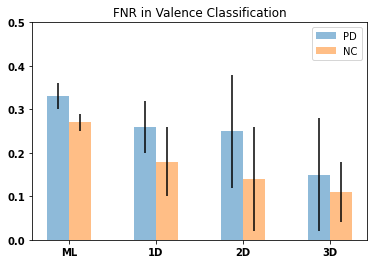

In [ ]:
#Plot comparing FNR of NC and PD.
labels = ['ML', '1D', '2D', '3D']
x_pos = np.arange(len(labels))

fnr_hvlv_pd_m = [hv_lv_pd_ml[0], hv_lv_1pd[0], hv_lv_2pd[0], hv_lv_3pd[0]]
fnr_hvlv_pd_s = [hv_lv_pd_ml[1], hv_lv_1pd[1], hv_lv_2pd[1], hv_lv_3pd[1]]

fnr_hvlv_nc_m = [hv_lv_nc_ml[0], hv_lv_1nc[0], hv_lv_2nc[0], hv_lv_3nc[0]]
fnr_hvlv_nc_s = [hv_lv_nc_ml[1], hv_lv_1nc[1], hv_lv_2nc[1], hv_lv_3nc[1]]

#ax = fig.add_axes([0,0,1,1])
barWidth = 0.25
q3 = plt.bar(x_pos - barWidth/2, fnr_hvlv_pd_m, yerr=fnr_hvlv_pd_s, align='center', alpha=0.5,
             width = barWidth)
q4 = plt.bar(x_pos + barWidth/2, fnr_hvlv_nc_m, yerr=fnr_hvlv_nc_s, align='center', alpha=0.5,
            width = barWidth)
#plt.ylabel('Mean brands recalled',fontsize=14,weight='bold')
#plt.xlabel('Methods',fontsize=14,weight='bold')
plt.ylim(0,0.5)
plt.xticks(ticks=[0,1,2,3], labels=labels, weight='bold')
plt.yticks(ticks=[0,0.1,0.2,0.3,0.4,0.5], weight='bold')
plt.legend((q3[0], q4[0]), ('PD', 'NC'))
plt.title('FNR in Valence Classification')

#plt.savefig('U2_IFbrrec.png',bbox_inches='tight')
#files.download('U2_IFbrrec.png')

Text(0.5, 1.0, 'FPR in Valence Classification')

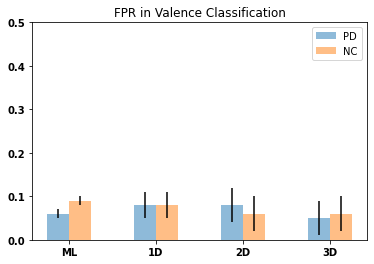

In [ ]:
#Plot comparing FPR of NC and PD.
labels = ['ML', '1D', '2D', '3D']
x_pos = np.arange(len(labels))

fpr_hvlv_pd_m = [lv_hv_pd_ml[0], lv_hv_1pd[0], lv_hv_2pd[0], lv_hv_3pd[0]]
fpr_hvlv_pd_s = [lv_hv_pd_ml[1], lv_hv_1pd[1], lv_hv_2pd[1], lv_hv_3pd[1]]

fpr_hvlv_nc_m = [lv_hv_nc_ml[0], lv_hv_1nc[0], lv_hv_2nc[0], lv_hv_3nc[0]]
fpr_hvlv_nc_s = [lv_hv_nc_ml[1], lv_hv_1nc[1], lv_hv_2nc[1], lv_hv_3nc[1]]

#ax = fig.add_axes([0,0,1,1])
barWidth = 0.25
q1 = plt.bar(x_pos - barWidth/2, fpr_hvlv_pd_m, yerr=fpr_hvlv_pd_s, align='center', alpha=0.5,
             width = barWidth)
q2 = plt.bar(x_pos + barWidth/2, fpr_hvlv_nc_m, yerr=fpr_hvlv_nc_s, align='center', alpha=0.5,
            width = barWidth)
#plt.ylabel('Mean brands recalled',fontsize=14,weight='bold')
#plt.xlabel('Methods',fontsize=14,weight='bold')
plt.ylim(0,0.5)
plt.xticks(ticks=[0,1,2,3], labels=labels, weight='bold')
plt.yticks(ticks=[0,0.1,0.2,0.3,0.4,0.5], weight='bold')
plt.legend((q1[0], q2[0]), ('PD', 'NC'))
plt.title('FPR in Valence Classification')

#plt.savefig('U2_IFbrrec.png',bbox_inches='tight')
#files.download('U2_IFbrrec.png')

Text(0.5, 1.0, 'Sensitivity and Specificity within PD')

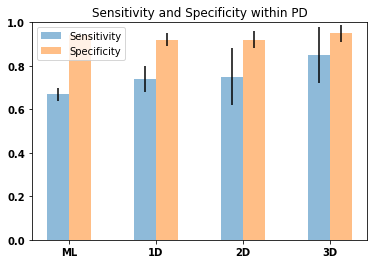

In [ ]:
#Plot comparing sensitivity and specificity within PD.
labels = ['ML', '1D', '2D', '3D']
x_pos = np.arange(len(labels))

sens_hvlv_pd_m = [hv_hv_pd_ml[0], hv_hv_1pd[0], hv_hv_2pd[0], hv_hv_3pd[0]]
sens_hvlv_pd_s = [hv_hv_pd_ml[1], hv_hv_1pd[1], hv_hv_2pd[1], hv_hv_3pd[1]]

spec_hvlv_pd_m = [lv_lv_pd_ml[0], lv_lv_1pd[0], lv_lv_2pd[0], lv_lv_3pd[0]]
spec_hvlv_pd_s = [lv_lv_pd_ml[1], lv_lv_1pd[1], lv_lv_2pd[1], lv_lv_3pd[1]]

#ax = fig.add_axes([0,0,1,1])
barWidth = 0.25
p5 = plt.bar(x_pos - barWidth/2, sens_hvlv_pd_m, yerr=sens_hvlv_pd_s, align='center', alpha=0.5,
             width = barWidth)
p6 = plt.bar(x_pos + barWidth/2, spec_hvlv_pd_m, yerr=spec_hvlv_pd_s, align='center', alpha=0.5,
            width = barWidth)
#plt.ylabel('Mean brands recalled',fontsize=14,weight='bold')
#plt.xlabel('Methods',fontsize=14,weight='bold')
plt.ylim(0,1)
plt.xticks(ticks=[0,1,2,3], labels=labels, weight='bold')
plt.yticks(weight='bold')
plt.legend((p5[0], p6[0]), ('Sensitivity', 'Specificity'))
plt.title('Sensitivity and Specificity within PD')

#plt.savefig('U2_IFbrrec.png',bbox_inches='tight')
#files.download('U2_IFbrrec.png')

Text(0.5, 1.0, 'FNR and FPR within PD')

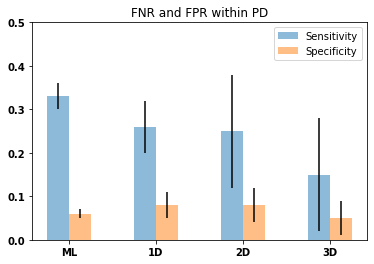

In [ ]:
#Plot comparing FNR and FPR within PD.
labels = ['ML', '1D', '2D', '3D']
x_pos = np.arange(len(labels))

fnr_hvlv_pd_m = [hv_lv_pd_ml[0], hv_lv_1pd[0], hv_lv_2pd[0], hv_lv_3pd[0]]
fnr_hvlv_pd_s = [hv_lv_pd_ml[1], hv_lv_1pd[1], hv_lv_2pd[1], hv_lv_3pd[1]]

fpr_hvlv_pd_m = [lv_hv_pd_ml[0], lv_hv_1pd[0], lv_hv_2pd[0], lv_hv_3pd[0]]
fpr_hvlv_pd_s = [lv_hv_pd_ml[1], lv_hv_1pd[1], lv_hv_2pd[1], lv_hv_3pd[1]]

#ax = fig.add_axes([0,0,1,1])
barWidth = 0.25
p7 = plt.bar(x_pos - barWidth/2, fnr_hvlv_pd_m, yerr=fnr_hvlv_pd_s, align='center', alpha=0.5,
             width = barWidth)
p8 = plt.bar(x_pos + barWidth/2, fpr_hvlv_pd_m, yerr=fpr_hvlv_pd_s, align='center', alpha=0.5,
            width = barWidth)
#plt.ylabel('Mean brands recalled',fontsize=14,weight='bold')
#plt.xlabel('Methods',fontsize=14,weight='bold')
plt.ylim(0,0.5)
plt.xticks(ticks=[0,1,2,3], labels=labels, weight='bold')
plt.yticks(weight='bold')
plt.legend((p7[0], p8[0]), ('Sensitivity', 'Specificity'))
plt.title('FNR and FPR within PD')

#plt.savefig('U2_IFbrrec.png',bbox_inches='tight')
#files.download('U2_IFbrrec.png')

Text(0.5, 1.0, 'Sensitivity in Arousal Classification')

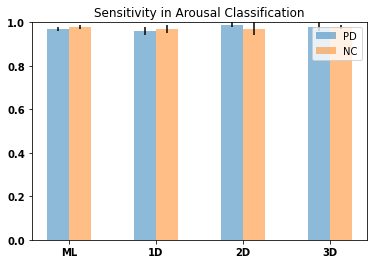

In [ ]:
#Plot comparing sensitivity of NC and PD.
labels = ['ML', '1D', '2D', '3D']
x_pos = np.arange(len(labels))

sens_hala_pd_m = [ha_ha_pd_ml[0], ha_ha_1pd[0], ha_ha_2pd[0], ha_ha_3pd[0]]
sens_hala_pd_s = [ha_ha_pd_ml[1], ha_ha_1pd[1], ha_ha_2pd[1], ha_ha_3pd[1]]

sens_hala_nc_m = [ha_ha_nc_ml[0], ha_ha_1nc[0], ha_ha_2nc[0], ha_ha_3nc[0]]
sens_hala_nc_s = [ha_ha_nc_ml[1], ha_ha_1nc[1], ha_ha_2nc[1], ha_ha_3nc[1]]

#ax = fig.add_axes([0,0,1,1])
barWidth = 0.25
a1 = plt.bar(x_pos - barWidth/2, sens_hala_pd_m, yerr=sens_hala_pd_s, align='center', alpha=0.5,
             width = barWidth)
a2 = plt.bar(x_pos + barWidth/2, sens_hala_nc_m, yerr=sens_hala_nc_s, align='center', alpha=0.5,
            width = barWidth)
#plt.ylabel('Mean brands recalled',fontsize=14,weight='bold')
#plt.xlabel('Methods',fontsize=14,weight='bold')
plt.ylim(0,1)
plt.xticks(ticks=[0,1,2,3], labels=labels, weight='bold')
plt.yticks(weight='bold')
plt.legend((a1[0], a2[0]), ('PD', 'NC'))
plt.title('Sensitivity in Arousal Classification')

#plt.savefig('U2_IFbrrec.png',bbox_inches='tight')
#files.download('U2_IFbrrec.png')

Text(0.5, 1.0, 'Specificity in Arousal Classification')

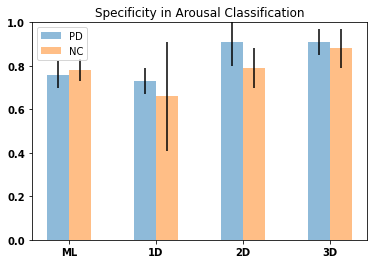

In [ ]:
#Plot comparing Specificity of NC and PD.
labels = ['ML', '1D', '2D', '3D']
x_pos = np.arange(len(labels))

spec_hala_pd_m = [la_la_pd_ml[0], la_la_1pd[0], la_la_2pd[0], la_la_3pd[0]]
spec_hala_pd_s = [la_la_pd_ml[1], la_la_1pd[1], la_la_2pd[1], la_la_3pd[1]]

spec_hala_nc_m = [la_la_nc_ml[0], la_la_1nc[0], la_la_2nc[0], la_la_3nc[0]]
spec_hala_nc_s = [la_la_nc_ml[1], la_la_1nc[1], la_la_2nc[1], la_la_3nc[1]]

#ax = fig.add_axes([0,0,1,1])
barWidth = 0.25
a3 = plt.bar(x_pos - barWidth/2, spec_hala_pd_m, yerr=spec_hala_pd_s, align='center', alpha=0.5,
             width = barWidth)
a4 = plt.bar(x_pos + barWidth/2, spec_hala_nc_m, yerr=spec_hala_nc_s, align='center', alpha=0.5,
            width = barWidth)
#plt.ylabel('Mean brands recalled',fontsize=14,weight='bold')
#plt.xlabel('Methods',fontsize=14,weight='bold')
plt.ylim(0,1)
plt.xticks(ticks=[0,1,2,3], labels=labels, weight='bold')
plt.yticks(weight='bold')
plt.legend((a3[0], a4[0]), ('PD', 'NC'))
plt.title('Specificity in Arousal Classification')

#plt.savefig('U2_IFbrrec.png',bbox_inches='tight')
#files.download('U2_IFbrrec.png')

Text(0.5, 1.0, 'FNR in Valence Classification')

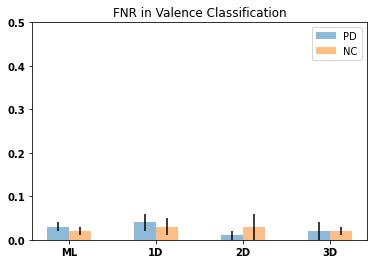

In [ ]:
#Plot comparing FNR of NC and PD.
labels = ['ML', '1D', '2D', '3D']
x_pos = np.arange(len(labels))

fnr_hala_pd_m = [ha_la_pd_ml[0], ha_la_1pd[0], ha_la_2pd[0], ha_la_3pd[0]]
fnr_hala_pd_s = [ha_la_pd_ml[1], ha_la_1pd[1], ha_la_2pd[1], ha_la_3pd[1]]

fnr_hala_nc_m = [ha_la_nc_ml[0], ha_la_1nc[0], ha_la_2nc[0], ha_la_3nc[0]]
fnr_hala_nc_s = [ha_la_nc_ml[1], ha_la_1nc[1], ha_la_2nc[1], ha_la_3nc[1]]

#ax = fig.add_axes([0,0,1,1])
barWidth = 0.25
b1 = plt.bar(x_pos - barWidth/2, fnr_hala_pd_m, yerr=fnr_hala_pd_s, align='center', alpha=0.5,
             width = barWidth)
b2 = plt.bar(x_pos + barWidth/2, fnr_hala_nc_m, yerr=fnr_hala_nc_s, align='center', alpha=0.5,
            width = barWidth)
#plt.ylabel('Mean brands recalled',fontsize=14,weight='bold')
#plt.xlabel('Methods',fontsize=14,weight='bold')
plt.ylim(0,0.5)
plt.xticks(ticks=[0,1,2,3], labels=labels, weight='bold')
plt.yticks(ticks=[0,0.1,0.2,0.3,0.4,0.5], weight='bold')
plt.legend((b1[0], b2[0]), ('PD', 'NC'))
plt.title('FNR in Valence Classification')

#plt.savefig('U2_IFbrrec.png',bbox_inches='tight')
#files.download('U2_IFbrrec.png')

Text(0.5, 1.0, 'FPR in Valence Classification')

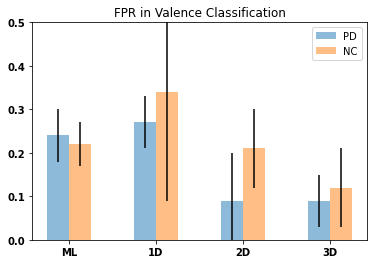

In [ ]:
#Plot comparing FPR of NC and PD.
labels = ['ML', '1D', '2D', '3D']
x_pos = np.arange(len(labels))

fpr_hala_pd_m = [la_ha_pd_ml[0], la_ha_1pd[0], la_ha_2pd[0], la_ha_3pd[0]]
fpr_hala_pd_s = [la_ha_pd_ml[1], la_ha_1pd[1], la_ha_2pd[1], la_ha_3pd[1]]

fpr_hala_nc_m = [la_ha_nc_ml[0], la_ha_1nc[0], la_ha_2nc[0], la_ha_3nc[0]]
fpr_hala_nc_s = [la_ha_nc_ml[1], la_ha_1nc[1], la_ha_2nc[1], la_ha_3nc[1]]

#ax = fig.add_axes([0,0,1,1])
barWidth = 0.25
b3 = plt.bar(x_pos - barWidth/2, fpr_hala_pd_m, yerr=fpr_hala_pd_s, align='center', alpha=0.5,
             width = barWidth)
b4 = plt.bar(x_pos + barWidth/2, fpr_hala_nc_m, yerr=fpr_hala_nc_s, align='center', alpha=0.5,
            width = barWidth)
#plt.ylabel('Mean brands recalled',fontsize=14,weight='bold')
#plt.xlabel('Methods',fontsize=14,weight='bold')
plt.ylim(0,0.5)
plt.xticks(ticks=[0,1,2,3], labels=labels, weight='bold')
plt.yticks(ticks=[0,0.1,0.2,0.3,0.4,0.5], weight='bold')
plt.legend((b1[0], b2[0]), ('PD', 'NC'))
plt.title('FPR in Valence Classification')

#plt.savefig('U2_IFbrrec.png',bbox_inches='tight')
#files.download('U2_IFbrrec.png')

Text(0.5, 1.0, 'Sensitivity and Specificity within PD')

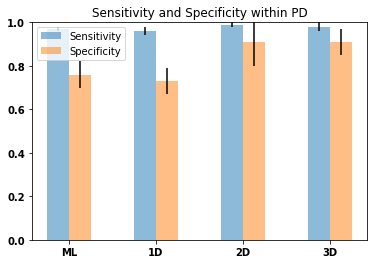

In [ ]:
#Plot comparing sensitivity and specificity within PD.
labels = ['ML', '1D', '2D', '3D']
x_pos = np.arange(len(labels))

sens_hala_pd_m = [ha_ha_pd_ml[0], ha_ha_1pd[0], ha_ha_2pd[0], ha_ha_3pd[0]]
sens_hala_pd_s = [ha_ha_pd_ml[1], ha_ha_1pd[1], ha_ha_2pd[1], ha_ha_3pd[1]]

spec_hala_pd_m = [la_la_pd_ml[0], la_la_1pd[0], la_la_2pd[0], la_la_3pd[0]]
spec_hala_pd_s = [la_la_pd_ml[1], la_la_1pd[1], la_la_2pd[1], la_la_3pd[1]]

#ax = fig.add_axes([0,0,1,1])
barWidth = 0.25
a5 = plt.bar(x_pos - barWidth/2, sens_hala_pd_m, yerr=sens_hala_pd_s, align='center', alpha=0.5,
             width = barWidth)
a6 = plt.bar(x_pos + barWidth/2, spec_hala_pd_m, yerr=spec_hala_pd_s, align='center', alpha=0.5,
            width = barWidth)
#plt.ylabel('Mean brands recalled',fontsize=14,weight='bold')
#plt.xlabel('Methods',fontsize=14,weight='bold')
plt.ylim(0,1)
plt.xticks(ticks=[0,1,2,3], labels=labels, weight='bold')
plt.yticks(weight='bold')
plt.legend((a5[0], a6[0]), ('Sensitivity', 'Specificity'))
plt.title('Sensitivity and Specificity within PD')

#plt.savefig('U2_IFbrrec.png',bbox_inches='tight')
#files.download('U2_IFbrrec.png')

Text(0.5, 1.0, 'FNR and FPR within PD')

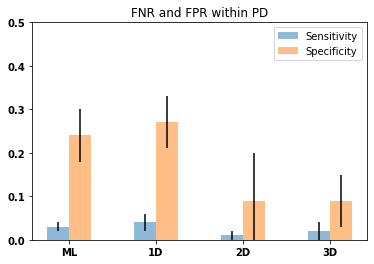

In [ ]:
#Plot comparing FNR and FPR within PD.
labels = ['ML', '1D', '2D', '3D']
x_pos = np.arange(len(labels))

fnr_hala_pd_m = [ha_la_pd_ml[0], ha_la_1pd[0], ha_la_2pd[0], ha_la_3pd[0]]
fnr_hala_pd_s = [ha_la_pd_ml[1], ha_la_1pd[1], ha_la_2pd[1], ha_la_3pd[1]]

fpr_hala_pd_m = [la_ha_pd_ml[0], la_ha_1pd[0], la_ha_2pd[0], la_ha_3pd[0]]
fpr_hala_pd_s = [la_ha_pd_ml[1], la_ha_1pd[1], la_ha_2pd[1], la_ha_3pd[1]]

#ax = fig.add_axes([0,0,1,1])
barWidth = 0.25
a7 = plt.bar(x_pos - barWidth/2, fnr_hala_pd_m, yerr=fnr_hala_pd_s, align='center', alpha=0.5,
             width = barWidth)
a8 = plt.bar(x_pos + barWidth/2, fpr_hala_pd_m, yerr=fpr_hala_pd_s, align='center', alpha=0.5,
            width = barWidth)
#plt.ylabel('Mean brands recalled',fontsize=14,weight='bold')
#plt.xlabel('Methods',fontsize=14,weight='bold')
plt.ylim(0,0.5)
plt.xticks(ticks=[0,1,2,3], labels=labels, weight='bold')
plt.yticks(weight='bold')
plt.legend((a7[0], a8[0]), ('FNR', 'FPR'))
plt.title('FNR and FPR within PD')

#plt.savefig('U2_IFbrrec.png',bbox_inches='tight')
#files.download('U2_IFbrrec.png')

# Result - Plots

## Valence

In [ ]:
def get_metric(dataPath, metric):
  matContent = sio.loadmat(dataPath)
  metric = matContent[metric]
  return metric

def specificity(metric):
  pos_list = [i[0][0] for i in metric]
  pos_list_m = round(np.mean(pos_list),2)
  pos_list_s = round(np.std(pos_list),2)
  return [pos_list_m, pos_list_s] 

def sensitivity(metric):
  neg_list = [i[1][1] for i in metric]
  neg_list_m = round(np.mean(neg_list),2)
  neg_list_s = round(np.std(neg_list),2)
  return [neg_list_m, neg_list_s] 

def fpr(metric):
  fpr_list = [i[0][1] for i in metric]
  fpr_list_m = round(np.mean(fpr_list),2)
  fpr_list_s = round(np.std(fpr_list),2)
  return [fpr_list_m, fpr_list_s]

def fnr(metric):
  fnr_list = [i[1][0] for i in metric]
  fnr_list_m = round(np.mean(fnr_list),2)
  fnr_list_s = round(np.std(fnr_list),2)
  return [fnr_list_m, fnr_list_s]


data = 'PD'
print("-----", data, "----")
print("-----3D----")
hvlv_pd_3d = get_metric('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/CNN_3D_our/CNN_3D_results_HVLV_'+str(data)+'.mat', 'conf_mat_list')
hv_hv_3pd = sensitivity(hvlv_pd_3d)
lv_lv_3pd = specificity(hvlv_pd_3d)
hv_lv_3pd = fnr(hvlv_pd_3d)
lv_hv_3pd = fpr(hvlv_pd_3d)
print('Sensitivity:',hv_hv_3pd[0],'+-',hv_hv_3pd[1])
print('Specificity:',lv_lv_3pd[0],'+-',lv_lv_3pd[1])
print('FPR:',lv_hv_3pd[0],'+-',lv_hv_3pd[1])
print('FNR:',hv_lv_3pd[0],'+-',hv_lv_3pd[1])

print("-----2D----")
hvlv_pd_2d = get_metric('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/CNN_2D_our/CNN_2D_results_HVLV_'+str(data)+'.mat', 'conf_mat_list')
hv_hv_2pd = sensitivity(hvlv_pd_2d)
lv_lv_2pd = specificity(hvlv_pd_2d)
hv_lv_2pd = fnr(hvlv_pd_2d)
lv_hv_2pd = fpr(hvlv_pd_2d)
print('Sensitivity:',hv_hv_2pd[0],'+-',hv_hv_2pd[1])
print('Specificity:',lv_lv_2pd[0],'+-',lv_lv_2pd[1])
print('FPR:',lv_hv_2pd[0],'+-',lv_hv_2pd[1])
print('FNR:',hv_lv_2pd[0],'+-',hv_lv_2pd[1])

print("-----1D----")
hvlv_pd_1d = get_metric('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/1D_CNN_Results/CSP/CNN_1D_results_HVLV_CSP_'+str(data)+'.mat', 'conf_mat_list')
hv_hv_1pd = sensitivity(hvlv_pd_1d)
lv_lv_1pd = specificity(hvlv_pd_1d)
hv_lv_1pd = fnr(hvlv_pd_1d)
lv_hv_1pd = fpr(hvlv_pd_1d)
print('Sensitivity:',hv_hv_1pd[0],'+-',hv_hv_1pd[1])
print('Specificity:',lv_lv_1pd[0],'+-',lv_lv_1pd[1])
print('FPR:',lv_hv_1pd[0],'+-',lv_hv_1pd[1])
print('FNR:',hv_lv_1pd[0],'+-',hv_lv_1pd[1])

print("-----ML----")
hvlv_pd_ml = get_metric('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/MLResults/CSP/ML_HVLV_CSP_'+str(data)+'.mat', 'conf_mat_list')
hv_hv_pd_ml = sensitivity(hvlv_pd_ml)
lv_lv_pd_ml = specificity(hvlv_pd_ml)
hv_lv_pd_ml = fnr(hvlv_pd_ml)
lv_hv_pd_ml = fpr(hvlv_pd_ml)
print('Sensitivity:',hv_hv_pd_ml[0],'+-',hv_hv_pd_ml[1])
print('Specificity:',lv_lv_pd_ml[0],'+-',lv_lv_pd_ml[1])
print('FPR:',lv_hv_pd_ml[0],'+-',lv_hv_pd_ml[1])
print('FNR:',hv_lv_pd_ml[0],'+-',hv_lv_pd_ml[1])

data = 'NC'
print("-----", data, "----")
print("-----3D----")
hvlv_nc_3d = get_metric('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/CNN_3D_our/CNN_3D_results_HVLV_'+str(data)+'.mat', 'conf_mat_list')
hv_hv_3nc = sensitivity(hvlv_nc_3d)
lv_lv_3nc = specificity(hvlv_nc_3d)
hv_lv_3nc = fnr(hvlv_nc_3d)
lv_hv_3nc = fpr(hvlv_nc_3d)
print('Sensitivity:',hv_hv_3nc[0],'+-',hv_hv_3nc[1])
print('Specificity:',lv_lv_3nc[0],'+-',lv_lv_3nc[1])
print('FPR:',lv_hv_3nc[0],'+-',lv_hv_3nc[1])
print('FNR:',hv_lv_3nc[0],'+-',hv_lv_3nc[1])

print("-----2D----")
hvlv_nc_2d = get_metric('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/CNN_2D_our/CNN_2D_results_HVLV_'+str(data)+'.mat', 'conf_mat_list')
hv_hv_2nc = sensitivity(hvlv_nc_2d)
lv_lv_2nc = specificity(hvlv_nc_2d)
hv_lv_2nc = fnr(hvlv_nc_2d)
lv_hv_2nc = fpr(hvlv_nc_2d)
print('Sensitivity:',hv_hv_2nc[0],'+-',hv_hv_2nc[1])
print('Specificity:',lv_lv_2nc[0],'+-',lv_lv_2nc[1])
print('FPR:',lv_hv_2nc[0],'+-',lv_hv_2nc[1])
print('FNR:',hv_lv_2nc[0],'+-',hv_lv_2nc[1])

print("-----1D----")
hvlv_nc_1d = get_metric('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/1D_CNN_Results/CSP/CNN_1D_results_HVLV_CSP_'+str(data)+'.mat', 'conf_mat_list')
hv_hv_1nc = sensitivity(hvlv_nc_1d)
lv_lv_1nc = specificity(hvlv_nc_1d)
hv_lv_1nc = fnr(hvlv_nc_1d)
lv_hv_1nc = fpr(hvlv_nc_1d)
print('Sensitivity:',hv_hv_1nc[0],'+-',hv_hv_1nc[1])
print('Specificity:',lv_lv_1nc[0],'+-',lv_lv_1nc[1])
print('FPR:',lv_hv_1nc[0],'+-',lv_hv_1nc[1])
print('FNR:',hv_lv_1nc[0],'+-',hv_lv_1nc[1])

print("-----ML----")
hvlv_nc_ml = get_metric('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/MLResults/CSP/ML_HVLV_CSP_'+str(data)+'.mat', 'conf_mat_list')
hv_hv_nc_ml = sensitivity(hvlv_nc_ml)
lv_lv_nc_ml = specificity(hvlv_nc_ml)
hv_lv_nc_ml = fnr(hvlv_nc_ml)
lv_hv_nc_ml = fpr(hvlv_nc_ml)
print('Sensitivity:',hv_hv_nc_ml[0],'+-',hv_hv_nc_ml[1])
print('Specificity:',lv_lv_nc_ml[0],'+-',lv_lv_nc_ml[1])
print('FPR:',lv_hv_nc_ml[0],'+-',lv_hv_nc_ml[1])
print('FNR:',hv_lv_nc_ml[0],'+-',hv_lv_nc_ml[1])



----- PD ----
-----3D----
Sensitivity: 0.85 +- 0.13
Specificity: 0.95 +- 0.04
FPR: 0.05 +- 0.04
FNR: 0.15 +- 0.13
-----2D----
Sensitivity: 0.75 +- 0.13
Specificity: 0.92 +- 0.04
FPR: 0.08 +- 0.04
FNR: 0.25 +- 0.13
-----1D----
Sensitivity: 0.74 +- 0.06
Specificity: 0.92 +- 0.03
FPR: 0.08 +- 0.03
FNR: 0.26 +- 0.06
-----ML----
Sensitivity: 0.67 +- 0.03
Specificity: 0.94 +- 0.01
FPR: 0.06 +- 0.01
FNR: 0.33 +- 0.03
----- NC ----
-----3D----
Sensitivity: 0.89 +- 0.07
Specificity: 0.94 +- 0.04
FPR: 0.06 +- 0.04
FNR: 0.11 +- 0.07
-----2D----
Sensitivity: 0.86 +- 0.12
Specificity: 0.94 +- 0.04
FPR: 0.06 +- 0.04
FNR: 0.14 +- 0.12
-----1D----
Sensitivity: 0.82 +- 0.08
Specificity: 0.92 +- 0.03
FPR: 0.08 +- 0.03
FNR: 0.18 +- 0.08
-----ML----
Sensitivity: 0.73 +- 0.02
Specificity: 0.91 +- 0.01
FPR: 0.09 +- 0.01
FNR: 0.27 +- 0.02


In [ ]:
data1 = {'Sensitivity': [i[1][1] for i in hvlv_nc_ml], 'Specificity': [i[0][0] for i in hvlv_nc_ml],
          'Data': len([i[1][1] for i in hvlv_nc_ml])*['NC'], 'Model': len([i[1][1] for i in hvlv_nc_ml])*['ML']}
df1 = pd.DataFrame(data1)
data2 = {'Sensitivity': [i[1][1] for i in hvlv_pd_ml], 'Specificity': [i[0][0] for i in hvlv_pd_ml],
          'Data': len([i[1][1] for i in hvlv_pd_ml])*['PD'], 'Model': len([i[1][1] for i in hvlv_pd_ml])*['ML']}
df2 = pd.DataFrame(data2)
data3 = {'Sensitivity': [i[1][1] for i in hvlv_pd_1d], 'Specificity': [i[0][0] for i in hvlv_pd_1d],
          'Data': len([i[1][1] for i in hvlv_pd_1d])*['PD'], 'Model': len([i[1][1] for i in hvlv_pd_1d])*['1D CNN']}
df3 = pd.DataFrame(data3)
data4 = {'Sensitivity': [i[1][1] for i in hvlv_nc_1d], 'Specificity': [i[0][0] for i in hvlv_nc_1d],
          'Data': len([i[1][1] for i in hvlv_nc_1d])*['NC'], 'Model': len([i[1][1] for i in hvlv_nc_1d])*['1D CNN']}
df4 = pd.DataFrame(data4)
data5 = {'Sensitivity': [i[1][1] for i in hvlv_pd_2d], 'Specificity': [i[0][0] for i in hvlv_pd_2d],
          'Data': len([i[1][1] for i in hvlv_pd_2d])*['PD'], 'Model': len([i[1][1] for i in hvlv_pd_2d])*['2D CNN']}
df5 = pd.DataFrame(data5)
data6 = {'Sensitivity': [i[1][1] for i in hvlv_nc_2d], 'Specificity': [i[0][0] for i in hvlv_nc_2d],
          'Data': len([i[1][1] for i in hvlv_nc_2d])*['NC'], 'Model': len([i[1][1] for i in hvlv_nc_2d])*['2D CNN']}
df6 = pd.DataFrame(data6)
data7 = {'Sensitivity': [i[1][1] for i in hvlv_pd_3d], 'Specificity': [i[0][0] for i in hvlv_pd_3d],
          'Data': len([i[1][1] for i in hvlv_pd_3d])*['PD'], 'Model': len([i[1][1] for i in hvlv_pd_3d])*['3D CNN']}
df7 = pd.DataFrame(data7)
data8 = {'Sensitivity': [i[1][1] for i in hvlv_nc_3d], 'Specificity': [i[0][0] for i in hvlv_nc_3d],
          'Data': len([i[1][1] for i in hvlv_nc_3d])*['NC'], 'Model': len([i[1][1] for i in hvlv_nc_3d])*['3D CNN']}
df8 = pd.DataFrame(data8)

valence_df = pd.concat([df1, df2, df3, df4, df5, df6, df7, df8], axis=0).reset_index()
print(valence_df)

    index  Sensitivity  Specificity Data   Model
0       0     0.696000     0.892116   NC      ML
1       1     0.736000     0.917012   NC      ML
2       2     0.736000     0.898340   NC      ML
3       3     0.712000     0.908714   NC      ML
4       4     0.724000     0.900415   NC      ML
..    ...          ...          ...  ...     ...
75      5     0.956693     0.971253   NC  3D CNN
76      6     0.913386     0.963039   NC  3D CNN
77      7     0.933071     0.977413   NC  3D CNN
78      8     0.937008     0.981520   NC  3D CNN
79      9     0.964567     0.956879   NC  3D CNN

[80 rows x 5 columns]


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

1D CNN_NC v.s. 1D CNN_PD: t-test independent samples with Bonferroni correction, P_val=1.059e-01 stat=2.417e+00
ML_NC v.s. ML_PD: t-test independent samples with Bonferroni correction, P_val=1.600e-04 stat=5.393e+00
2D CNN_NC v.s. 2D CNN_PD: t-test independent samples with Bonferroni correction, P_val=2.958e-01 stat=1.897e+00
3D CNN_NC v.s. 3D CNN_PD: t-test independent samples with Bonferroni correction, P_val=1.000e+00 stat=1.042e+00


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


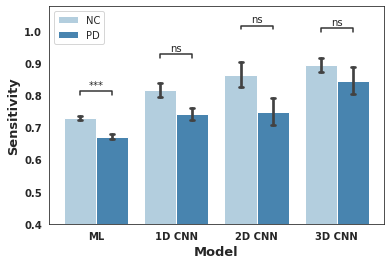

In [ ]:
x = "Model"
y = "Sensitivity"
hue = "Data"
sns.set_style("white")
ax = sns.barplot(data=valence_df, x=x, y=y, hue=hue, palette = "Blues", capsize=.05, ci=68)
ax.set_ylim(bottom=0.4)
ax.legend(loc='upper left', bbox_to_anchor=(0, 1))
ax.set_xlabel('Model',fontsize = 13, weight='bold')
ax.set_ylabel('Sensitivity',fontsize = 13, weight='bold' )
ax.set_xticklabels(["ML", "1D CNN", "2D CNN", "3D CNN"], rotation=0, fontsize = 10, weight = 'bold')
#_, ylabels = plt.yticks()
#ax.set_yticklabels(ylabels, fontsize = 10, weight = 'bold');
ax.set_yticklabels(["0.4", "0.5", "0.6", "0.7", "0.8", "0.9", "1.0"], size= 10, weight='bold')
add_stat_annotation(ax, data=valence_df, x=x, y=y, hue=hue,
                    box_pairs=[(("ML", "PD"), ("ML", "NC")),
                                 (("1D CNN", "PD"), ("1D CNN", "NC")),
                                 (("2D CNN", "PD"), ("2D CNN", "NC")),
                               (("3D CNN", "PD"), ("3D CNN", "NC"))
                                ],
                    test='t-test_ind', text_format='star', loc='inside', verbose=2)


plt.savefig('sensitivity_valence.eps', format='eps', bbox_inches='tight')
#FILE.download('sensitivity_valence.eps')

In [ ]:
list(ax.get_yticklabels())

[Text(0, 0.4, '0.4'),
 Text(0, 0.5, '0.5'),
 Text(0, 0.6000000000000001, '0.6000000000000001'),
 Text(0, 0.7000000000000001, '0.7000000000000001'),
 Text(0, 0.8, '0.8'),
 Text(0, 0.9, '0.9'),
 Text(0, 1.0, '1.0'),
 Text(0, 1.1, '')]

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

1D CNN_NC v.s. 1D CNN_PD: t-test independent samples with Bonferroni correction, P_val=1.000e+00 stat=-4.614e-01
ML_NC v.s. ML_PD: t-test independent samples with Bonferroni correction, P_val=4.051e-07 stat=-8.506e+00
2D CNN_NC v.s. 2D CNN_PD: t-test independent samples with Bonferroni correction, P_val=6.461e-01 stat=1.460e+00
3D CNN_NC v.s. 3D CNN_PD: t-test independent samples with Bonferroni correction, P_val=1.000e+00 stat=-1.727e-01


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


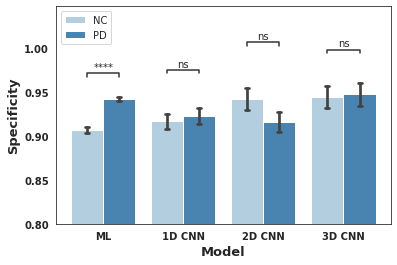

In [ ]:
x = "Model"
y = "Specificity"
hue = "Data"
ax = sns.barplot(data=valence_df, x=x, y=y, hue=hue, palette = "Blues", capsize=.05, ci=68)
ax.set_ylim(bottom=0.8)
ax.legend(loc='upper left', bbox_to_anchor=(0,1))
ax.set_xlabel('Model',fontsize = 13, weight='bold')
ax.set_ylabel('Specificity',fontsize = 13, weight='bold')
ax.set_xticklabels(["ML", "1D CNN", "2D CNN", "3D CNN"], rotation=0, fontsize = 10, weight='bold')
#_, ylabels = plt.yticks()
#ax.set_yticklabels(ylabels, fontsize = 10, weight = 'bold');
#ax.set_yticklabels(ax.get_yticklabels(), size= 10, weight='bold')
ax.set_yticklabels(["0.80", "0.85", "0.90", "0.95", "1.00"], size= 10, weight='bold')
add_stat_annotation(ax, data=valence_df, x=x, y=y, hue=hue,
                    box_pairs=[(("ML", "PD"), ("ML", "NC")),
                                 (("1D CNN", "PD"), ("1D CNN", "NC")),
                                 (("2D CNN", "PD"), ("2D CNN", "NC")),
                               (("3D CNN", "PD"), ("3D CNN", "NC"))
                                ],
                    test='t-test_ind', text_format='star', loc='inside', verbose=2)

plt.savefig('specificity_valence.eps', format='eps', bbox_inches='tight')
#FILE.download('sensitivity_valence.eps')

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

1D CNN_Sensitivity v.s. 1D CNN_Specificity: t-test independent samples with Bonferroni correction, P_val=3.192e-07 stat=-8.645e+00
ML_Sensitivity v.s. ML_Specificity: t-test independent samples with Bonferroni correction, P_val=2.091e-16 stat=-3.073e+01
2D CNN_Sensitivity v.s. 2D CNN_Specificity: t-test independent samples with Bonferroni correction, P_val=8.861e-03 stat=-3.565e+00
3D CNN_Sensitivity v.s. 3D CNN_Specificity: t-test independent samples with Bonferroni correction, P_val=1.403e-01 stat=-2.279e+00


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


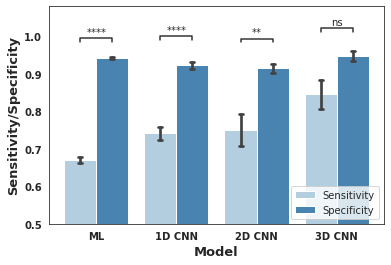

In [ ]:
valence_df_new = pd.melt(valence_df[valence_df['Data']=='PD'], id_vars=['Model'], value_vars=['Sensitivity', 'Specificity'],
        var_name='Test', value_name='Value')
x = "Model"
y = "Value"
hue = "Test"
ax = sns.barplot(data=valence_df_new, x=x, y=y, hue = hue, palette = "Blues", capsize=.05, ci=68)
ax.set_ylim(bottom=0.5)
ax.legend(loc='lower right', bbox_to_anchor=(1,0))
ax.set_xlabel('Model',fontsize = 13, weight='bold')
ax.set_ylabel('Sensitivity/Specificity',fontsize = 13, weight='bold')
ax.set_xticklabels(["ML", "1D CNN", "2D CNN", "3D CNN"], rotation=0, fontsize = 10, weight='bold');
ax.set_yticklabels(["0.5", "0.6", "0.7", "0.8", "0.9", "1.0"], size= 10, weight='bold')
#ax.set_yticklabels(ax.get_yticklabels(), size= 10, weight='bold')
add_stat_annotation(ax, data=valence_df_new, x=x, y=y, hue=hue,
                    box_pairs=[(("ML", "Sensitivity"), ("ML", "Specificity")),
                                 (("1D CNN", "Sensitivity"), ("1D CNN", "Specificity")),
                                 (("2D CNN", "Sensitivity"), ("2D CNN", "Specificity")),
                               (("3D CNN", "Sensitivity"), ("3D CNN", "Specificity"))
                                ],
                    test='t-test_ind', text_format='star', loc='inside', verbose=2)

plt.savefig('sens_and_speci_valence.eps', format='eps', bbox_inches='tight')
#FILE.download('sensitivity_valence.eps')

In [ ]:
data = 'PD'
print("-----", data, "----")
hvlv_pd_3d = get_metric('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/CNN_3D_our/CNN_3D_results_HVLV_'+str(data)+'.mat', 'f1_weightedNet')
hvlv_pd_2d = get_metric('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/CNN_2D_our/CNN_2D_results_HVLV_'+str(data)+'.mat', 'f1_weightedNet')
hvlv_pd_1d = get_metric('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/1D_CNN_Results/CSP/CNN_1D_results_HVLV_CSP_'+str(data)+'.mat', 'f1_weightedNet')
hvlv_pd_ml = get_metric('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/MLResults/CSP/ML_HVLV_CSP_'+str(data)+'.mat', 'wtd_f1_list')

data = 'NC'
hvlv_nc_3d = get_metric('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/CNN_3D_our/CNN_3D_results_HVLV_'+str(data)+'.mat', 'f1_weightedNet')
hvlv_nc_2d = get_metric('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/CNN_2D_our/CNN_2D_results_HVLV_'+str(data)+'.mat', 'f1_weightedNet')
hvlv_nc_1d = get_metric('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/1D_CNN_Results/CSP/CNN_1D_results_HVLV_CSP_'+str(data)+'.mat', 'f1_weightedNet')
hvlv_nc_ml = get_metric('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/MLResults/CSP/ML_HVLV_CSP_'+str(data)+'.mat', 'wtd_f1_list')

data1 = {'F-Score': hvlv_nc_ml[0], 'Data': len(hvlv_nc_ml[0])*['NC'], 'Model': len(hvlv_nc_ml[0])*['ML']}
df1 = pd.DataFrame(data1)
data2 = {'F-Score': hvlv_pd_ml[0], 'Data': len(hvlv_pd_ml[0])*['PD'], 'Model': len(hvlv_pd_ml[0])*['ML']}
df2 = pd.DataFrame(data2)
data3 = {'F-Score': hvlv_nc_1d[0], 'Data': len(hvlv_nc_1d[0])*['NC'], 'Model': len(hvlv_nc_1d[0])*['1D CNN']}
df3 = pd.DataFrame(data3)
data4 = {'F-Score': hvlv_pd_1d[0], 'Data': len(hvlv_pd_1d[0])*['PD'], 'Model': len(hvlv_pd_1d[0])*['1D CNN']}
df4 = pd.DataFrame(data4)
data5 = {'F-Score': hvlv_nc_2d[0], 'Data': len(hvlv_nc_2d[0])*['NC'], 'Model': len(hvlv_nc_2d[0])*['2D CNN']}
df5 = pd.DataFrame(data5)
data6 = {'F-Score': hvlv_pd_2d[0], 'Data': len(hvlv_pd_2d[0])*['PD'], 'Model': len(hvlv_pd_2d[0])*['2D CNN']}
df6 = pd.DataFrame(data6)
data7 = {'F-Score': hvlv_nc_3d[0], 'Data': len(hvlv_nc_3d[0])*['NC'], 'Model': len(hvlv_nc_3d[0])*['3D CNN']}
df7 = pd.DataFrame(data7)
data8 = {'F-Score': hvlv_pd_3d[0], 'Data': len(hvlv_pd_3d[0])*['PD'], 'Model': len(hvlv_pd_3d[0])*['3D CNN']}
df8 = pd.DataFrame(data8)

valence_fscore_df = pd.concat([df1, df2, df3, df4, df5, df6, df7, df8], axis=0).reset_index()
print(valence_fscore_df)


----- PD ----
    index   F-Score Data   Model
0       0  0.822852   NC      ML
1       1  0.853121   NC      ML
2       2  0.841493   NC      ML
3       3  0.839066   NC      ML
4       4  0.838364   NC      ML
..    ...       ...  ...     ...
75      5  0.951466   PD  3D CNN
76      6  0.956859   PD  3D CNN
77      7  0.960814   PD  3D CNN
78      8  0.968789   PD  3D CNN
79      9  0.952308   PD  3D CNN

[80 rows x 4 columns]


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

1D CNN_NC v.s. 1D CNN_PD: t-test independent samples with Bonferroni correction, P_val=5.603e-01 stat=1.544e+00
ML_NC v.s. ML_PD: t-test independent samples with Bonferroni correction, P_val=1.000e+00 stat=-5.793e-02
2D CNN_NC v.s. 2D CNN_PD: t-test independent samples with Bonferroni correction, P_val=3.132e-01 stat=1.867e+00
3D CNN_NC v.s. 3D CNN_PD: t-test independent samples with Bonferroni correction, P_val=1.000e+00 stat=5.571e-01


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


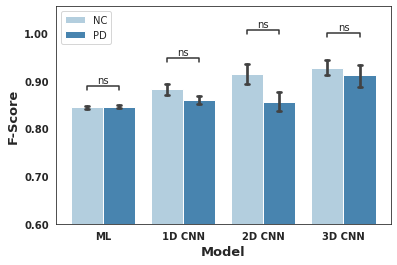

In [ ]:
x = "Model"
y = "F-Score"
hue = "Data"
ax = sns.barplot(data=valence_fscore_df, x=x, y=y, hue=hue, palette = "Blues", capsize=.05, ci=68)
ax.set_ylim(bottom=0.6)
ax.legend(loc='upper left', bbox_to_anchor=(0,1))
ax.set_xlabel('Model',fontsize = 13, weight='bold')
ax.set_ylabel('F-Score',fontsize = 13, weight='bold')
ax.set_xticklabels(["ML", "1D CNN", "2D CNN", "3D CNN"], rotation=0, fontsize = 10, weight='bold')
#_, ylabels = plt.yticks()
#ax.set_yticklabels(ylabels, fontsize = 10, weight = 'bold');
#ax.set_yticklabels(ax.get_yticklabels(), size= 10, weight='bold')
ax.set_yticklabels(["0.60", "0.70", "0.80", "0.90", "1.00"], size= 10, weight='bold')
add_stat_annotation(ax, data=valence_fscore_df, x=x, y=y, hue=hue,
                    box_pairs=[(("ML", "PD"), ("ML", "NC")),
                                 (("1D CNN", "PD"), ("1D CNN", "NC")),
                                 (("2D CNN", "PD"), ("2D CNN", "NC")),
                               (("3D CNN", "PD"), ("3D CNN", "NC"))
                                ],
                    test='t-test_ind', text_format='star', loc='inside', verbose=2)

plt.savefig('f-score_valence.eps', format='eps', bbox_inches='tight')
#FILE.download('sensitivity_valence.eps')

## Arousal

In [ ]:
def get_metric(dataPath, metric):
  matContent = sio.loadmat(dataPath)
  metric = matContent[metric]
  return metric

def specificity(metric):
  pos_list = [i[0][0] for i in metric]
  pos_list_m = round(np.mean(pos_list),2)
  pos_list_s = round(np.std(pos_list),2)
  return [pos_list_m, pos_list_s] 

def sensitivity(metric):
  neg_list = [i[1][1] for i in metric]
  neg_list_m = round(np.mean(neg_list),2)
  neg_list_s = round(np.std(neg_list),2)
  return [neg_list_m, neg_list_s] 

def fpr(metric):
  fpr_list = [i[0][1] for i in metric]
  fpr_list_m = round(np.mean(fpr_list),2)
  fpr_list_s = round(np.std(fpr_list),2)
  return [fpr_list_m, fpr_list_s]

def fnr(metric):
  fnr_list = [i[1][0] for i in metric]
  fnr_list_m = round(np.mean(fnr_list),2)
  fnr_list_s = round(np.std(fnr_list),2)
  return [fnr_list_m, fnr_list_s]


data = 'PD'
print("-----", data, "----")
print("-----3D----")
hala_pd_3d = get_metric('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/CNN_3D_our/CNN_3D_results_HALA_'+str(data)+'.mat', 'conf_mat_list')
ha_ha_3pd = sensitivity(hala_pd_3d)
la_la_3pd = specificity(hala_pd_3d)
ha_la_3pd = fnr(hala_pd_3d)
la_ha_3pd = fpr(hala_pd_3d)
print('Sensitivity:',ha_ha_3pd[0],'+-',ha_ha_3pd[1])
print('Specificity:',la_la_3pd[0],'+-',la_la_3pd[1])
print('FPR:',la_ha_3pd[0],'+-',la_ha_3pd[1])
print('FNR:',ha_la_3pd[0],'+-',ha_la_3pd[1])

print("-----2D----")
hala_pd_2d = get_metric('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/CNN_2D_our/CNN_2D_results_HALA_'+str(data)+'.mat', 'conf_mat_list')
ha_ha_2pd = sensitivity(hala_pd_2d)
la_la_2pd = specificity(hala_pd_2d)
ha_la_2pd = fnr(hala_pd_2d)
la_ha_2pd = fpr(hala_pd_2d)
print('Sensitivity:',ha_ha_2pd[0],'+-',ha_ha_2pd[1])
print('Specificity:',la_la_2pd[0],'+-',la_la_2pd[1])
print('FPR:',la_ha_2pd[0],'+-',la_ha_2pd[1])
print('FNR:',ha_la_2pd[0],'+-',ha_la_2pd[1])

print("-----1D----")
hala_pd_1d = get_metric('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/1D_CNN_Results/CSP/CNN_1D_results_HALA_CSP_'+str(data)+'.mat', 'conf_mat_list')
ha_ha_1pd = sensitivity(hala_pd_1d)
la_la_1pd = specificity(hala_pd_1d)
ha_la_1pd = fnr(hala_pd_1d)
la_ha_1pd = fpr(hala_pd_1d)
print('Sensitivity:',ha_ha_1pd[0],'+-',ha_ha_1pd[1])
print('Specificity:',la_la_1pd[0],'+-',la_la_1pd[1])
print('FPR:',la_ha_1pd[0],'+-',la_ha_1pd[1])
print('FNR:',ha_la_1pd[0],'+-',ha_la_1pd[1])

print("-----ML----")
hala_pd_ml = get_metric('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/MLResults/CSP/ML_HALA_CSP_'+str(data)+'.mat', 'conf_mat_list')
ha_ha_pd_ml = sensitivity(hala_pd_ml)
la_la_pd_ml = specificity(hala_pd_ml)
ha_la_pd_ml = fnr(hala_pd_ml)
la_ha_pd_ml = fpr(hala_pd_ml)
print('Sensitivity:',ha_ha_pd_ml[0],'+-',ha_ha_pd_ml[1])
print('Specificity:',la_la_pd_ml[0],'+-',la_la_pd_ml[1])
print('FPR:',la_ha_pd_ml[0],'+-',la_ha_pd_ml[1])
print('FNR:',ha_la_pd_ml[0],'+-',ha_la_pd_ml[1])

data = 'NC'
print("-----", data, "----")
print("-----3D----")
hala_nc_3d = get_metric('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/CNN_3D_our/CNN_3D_results_HALA_'+str(data)+'.mat', 'conf_mat_list')
ha_ha_3nc = sensitivity(hala_nc_3d)
la_la_3nc = specificity(hala_nc_3d)
ha_la_3nc = fnr(hala_nc_3d)
la_ha_3nc = fpr(hala_nc_3d)
print('Sensitivity:',ha_ha_3nc[0],'+-',ha_ha_3nc[1])
print('Specificity:',la_la_3nc[0],'+-',la_la_3nc[1])
print('FPR:',la_ha_3nc[0],'+-',la_ha_3nc[1])
print('FNR:',ha_la_3nc[0],'+-',ha_la_3nc[1])

print("-----2D----")
hala_nc_2d = get_metric('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/CNN_2D_our/CNN_2D_results_HALA_'+str(data)+'.mat', 'conf_mat_list')
ha_ha_2nc = sensitivity(hala_nc_2d)
la_la_2nc = specificity(hala_nc_2d)
ha_la_2nc = fnr(hala_nc_2d)
la_ha_2nc = fpr(hala_nc_2d)
print('Sensitivity:',ha_ha_2nc[0],'+-',ha_ha_2nc[1])
print('Specificity:',la_la_2nc[0],'+-',la_la_2nc[1])
print('FPR:',la_ha_2nc[0],'+-',la_ha_2nc[1])
print('FNR:',ha_la_2nc[0],'+-',ha_la_2nc[1])

print("-----1D----")
hala_nc_1d = get_metric('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/1D_CNN_Results/Spectral/CNN_1D_results_HALA_Spectral_'+str(data)+'.mat', 'conf_mat_list')
ha_ha_1nc = sensitivity(hala_nc_1d)
la_la_1nc = specificity(hala_nc_1d)
ha_la_1nc = fnr(hala_nc_1d)
la_ha_1nc = fpr(hala_nc_1d)
print('Sensitivity:',ha_ha_1nc[0],'+-',ha_ha_1nc[1])
print('Specificity:',la_la_1nc[0],'+-',la_la_1nc[1])
print('FPR:',la_ha_1nc[0],'+-',la_ha_1nc[1])
print('FNR:',ha_la_1nc[0],'+-',ha_la_1nc[1])

print("-----ML----")
hala_nc_ml = get_metric('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/MLResults/CSP/ML_HALA_CSP_'+str(data)+'.mat', 'conf_mat_list')
ha_ha_nc_ml = sensitivity(hala_nc_ml)
la_la_nc_ml = specificity(hala_nc_ml)
ha_la_nc_ml = fnr(hala_nc_ml)
la_ha_nc_ml = fpr(hala_nc_ml)
print('Sensitivity:',ha_ha_nc_ml[0],'+-',ha_ha_nc_ml[1])
print('Specificity:',la_la_nc_ml[0],'+-',la_la_nc_ml[1])
print('FPR:',la_ha_nc_ml[0],'+-',la_ha_nc_ml[1])
print('FNR:',ha_la_nc_ml[0],'+-',ha_la_nc_ml[1])

----- PD ----
-----3D----
Sensitivity: 0.98 +- 0.02
Specificity: 0.91 +- 0.06
FPR: 0.09 +- 0.06
FNR: 0.02 +- 0.02
-----2D----
Sensitivity: 0.99 +- 0.01
Specificity: 0.91 +- 0.11
FPR: 0.09 +- 0.11
FNR: 0.01 +- 0.01
-----1D----
Sensitivity: 0.96 +- 0.02
Specificity: 0.73 +- 0.06
FPR: 0.27 +- 0.06
FNR: 0.04 +- 0.02
-----ML----
Sensitivity: 0.97 +- 0.01
Specificity: 0.76 +- 0.06
FPR: 0.24 +- 0.06
FNR: 0.03 +- 0.01
----- NC ----
-----3D----
Sensitivity: 0.98 +- 0.01
Specificity: 0.88 +- 0.09
FPR: 0.12 +- 0.09
FNR: 0.02 +- 0.01
-----2D----
Sensitivity: 0.97 +- 0.03
Specificity: 0.79 +- 0.09
FPR: 0.21 +- 0.09
FNR: 0.03 +- 0.03
-----1D----
Sensitivity: 0.97 +- 0.02
Specificity: 0.66 +- 0.25
FPR: 0.34 +- 0.25
FNR: 0.03 +- 0.02
-----ML----
Sensitivity: 0.98 +- 0.01
Specificity: 0.78 +- 0.05
FPR: 0.22 +- 0.05
FNR: 0.02 +- 0.01


In [ ]:
data1 = {'Sensitivity': [i[1][1] for i in hala_nc_ml], 'Specificity': [i[0][0] for i in hala_nc_ml],
          'Data': len([i[1][1] for i in hala_nc_ml])*['NC'], 'Model': len([i[1][1] for i in hala_nc_ml])*['ML']}
df1 = pd.DataFrame(data1)
data2 = {'Sensitivity': [i[1][1] for i in hala_pd_ml], 'Specificity': [i[0][0] for i in hala_pd_ml],
          'Data': len([i[1][1] for i in hala_pd_ml])*['PD'], 'Model': len([i[1][1] for i in hala_pd_ml])*['ML']}
df2 = pd.DataFrame(data2)
data3 = {'Sensitivity': [i[1][1] for i in hala_pd_1d], 'Specificity': [i[0][0] for i in hala_pd_1d],
          'Data': len([i[1][1] for i in hala_pd_1d])*['PD'], 'Model': len([i[1][1] for i in hala_pd_1d])*['1D CNN']}
df3 = pd.DataFrame(data3)
data4 = {'Sensitivity': [i[1][1] for i in hala_nc_1d], 'Specificity': [i[0][0] for i in hala_nc_1d],
          'Data': len([i[1][1] for i in hala_nc_1d])*['NC'], 'Model': len([i[1][1] for i in hala_nc_1d])*['1D CNN']}
df4 = pd.DataFrame(data4)
data5 = {'Sensitivity': [i[1][1] for i in hala_pd_2d], 'Specificity': [i[0][0] for i in hala_pd_2d],
          'Data': len([i[1][1] for i in hala_pd_2d])*['PD'], 'Model': len([i[1][1] for i in hala_pd_2d])*['2D CNN']}
df5 = pd.DataFrame(data5)
data6 = {'Sensitivity': [i[1][1] for i in hala_nc_2d], 'Specificity': [i[0][0] for i in hala_nc_2d],
          'Data': len([i[1][1] for i in hala_nc_2d])*['NC'], 'Model': len([i[1][1] for i in hala_nc_2d])*['2D CNN']}
df6 = pd.DataFrame(data6)
data7 = {'Sensitivity': [i[1][1] for i in hala_pd_3d], 'Specificity': [i[0][0] for i in hala_pd_3d],
          'Data': len([i[1][1] for i in hala_pd_3d])*['PD'], 'Model': len([i[1][1] for i in hala_pd_3d])*['3D CNN']}
df7 = pd.DataFrame(data7)
data8 = {'Sensitivity': [i[1][1] for i in hala_nc_3d], 'Specificity': [i[0][0] for i in hala_nc_3d],
          'Data': len([i[1][1] for i in hala_nc_3d])*['NC'], 'Model': len([i[1][1] for i in hala_nc_3d])*['3D CNN']}
df8 = pd.DataFrame(data8)

arousal_df = pd.concat([df1, df2, df3, df4, df5, df6, df7, df8], axis=0).reset_index()
print(arousal_df)

    index  Sensitivity  Specificity Data   Model
0       0     0.978723     0.702479   NC      ML
1       1     0.980392     0.800000   NC      ML
2       2     0.978758     0.700000   NC      ML
3       3     0.959150     0.858333   NC      ML
4       4     0.982026     0.800000   NC      ML
..    ...          ...          ...  ...     ...
75      5     0.993548     0.892562   NC  3D CNN
76      6     0.988710     0.884298   NC  3D CNN
77      7     0.977419     0.917355   NC  3D CNN
78      8     0.993548     0.958678   NC  3D CNN
79      9     0.991935     0.942149   NC  3D CNN

[80 rows x 5 columns]


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

1D CNN_NC v.s. 1D CNN_PD: t-test independent samples with Bonferroni correction, P_val=1.000e+00 stat=1.073e+00
ML_NC v.s. ML_PD: t-test independent samples with Bonferroni correction, P_val=5.130e-01 stat=1.594e+00
2D CNN_NC v.s. 2D CNN_PD: t-test independent samples with Bonferroni correction, P_val=3.125e-01 stat=-1.868e+00
3D CNN_NC v.s. 3D CNN_PD: t-test independent samples with Bonferroni correction, P_val=1.000e+00 stat=4.760e-02


(<matplotlib.axes._subplots.AxesSubplot at 0x7f260edadb90>,
  <statannot.StatResult.StatResult at 0x7f260ebb2390>])

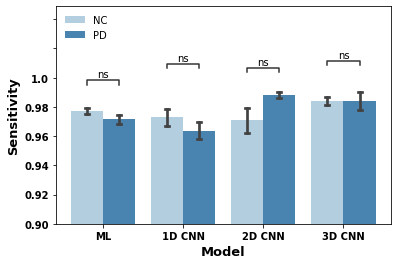

In [ ]:
x = "Model"
y = "Sensitivity"
hue = "Data"
ax = sns.barplot(data=arousal_df, x=x, y=y, hue=hue, palette = "Blues", capsize=0.05, ci=68)
ax.set_ylim(bottom=0.9)
ax.legend(loc='upper left', bbox_to_anchor=(0, 1))
ax.set_xlabel('Model',fontsize = 13, weight='bold' )
ax.set_ylabel('Sensitivity',fontsize = 13 , weight='bold')
ax.set_xticklabels(["ML", "1D CNN", "2D CNN", "3D CNN"], rotation=0, fontsize = 10, weight='bold');
ax.set_yticklabels(["0.90", "0.92", "0.94", "0.96", "0.98", "1.0"], size= 10, weight='bold')
#ax.set_yticklabels(ax.get_yticklabels(), size= 10, weight='bold')
add_stat_annotation(ax, data=arousal_df, x=x, y=y, hue=hue,
                    box_pairs=[(("ML", "PD"), ("ML", "NC")),
                                 (("1D CNN", "PD"), ("1D CNN", "NC")),
                                 (("2D CNN", "PD"), ("2D CNN", "NC")),
                               (("3D CNN", "PD"), ("3D CNN", "NC"))
                                ],
                    test='t-test_ind', text_format='star', loc='inside', verbose=2)

#plt.savefig('sensitivity_arousal.eps', format='eps', bbox_inches='tight')
#FILE.download('sensitivity_valence.eps')

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

1D CNN_NC v.s. 1D CNN_PD: t-test independent samples with Bonferroni correction, P_val=1.000e+00 stat=-7.771e-01
ML_NC v.s. ML_PD: t-test independent samples with Bonferroni correction, P_val=1.000e+00 stat=6.178e-01
2D CNN_NC v.s. 2D CNN_PD: t-test independent samples with Bonferroni correction, P_val=8.325e-02 stat=-2.533e+00
3D CNN_NC v.s. 3D CNN_PD: t-test independent samples with Bonferroni correction, P_val=1.000e+00 stat=-8.230e-01


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


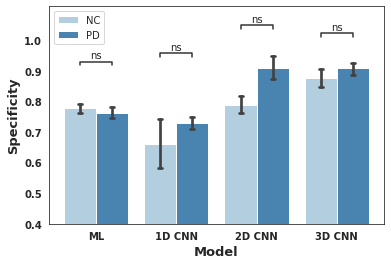

In [ ]:
x = "Model"
y = "Specificity"
hue = "Data"
ax = sns.barplot(data=arousal_df, x=x, y=y, hue=hue, palette = "Blues", capsize=0.05, ci=68)
ax.set_ylim(bottom=0.4)
ax.legend(loc='upper left', bbox_to_anchor=(0, 1))
ax.set_xlabel('Model',fontsize = 13, weight='bold')
ax.set_ylabel('Specificity',fontsize = 13, weight='bold')
ax.set_xticklabels(["ML", "1D CNN", "2D CNN", "3D CNN"], rotation=0, fontsize = 10, weight='bold');
ax.set_yticklabels(["0.4", "0.5", "0.6", "0.7", "0.8", "0.9", "1.0"], size= 10, weight='bold')
add_stat_annotation(ax, data=arousal_df, x=x, y=y, hue=hue,
                    box_pairs=[(("ML", "PD"), ("ML", "NC")),
                                 (("1D CNN", "PD"), ("1D CNN", "NC")),
                                 (("2D CNN", "PD"), ("2D CNN", "NC")),
                               (("3D CNN", "PD"), ("3D CNN", "NC"))
                                ],
                    test='t-test_ind', text_format='star', loc='inside', verbose=2)

plt.savefig('specificity_arousal.eps', format='eps', bbox_inches='tight')
#FILE.download('sensitivity_valence.eps')

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

1D CNN_Sensitivity v.s. 1D CNN_Specificity: t-test independent samples with Bonferroni correction, P_val=1.449e-08 stat=1.060e+01
ML_Sensitivity v.s. ML_Specificity: t-test independent samples with Bonferroni correction, P_val=6.295e-09 stat=1.118e+01
2D CNN_Sensitivity v.s. 2D CNN_Specificity: t-test independent samples with Bonferroni correction, P_val=2.136e-01 stat=2.067e+00
3D CNN_Sensitivity v.s. 3D CNN_Specificity: t-test independent samples with Bonferroni correction, P_val=8.291e-03 stat=3.594e+00


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


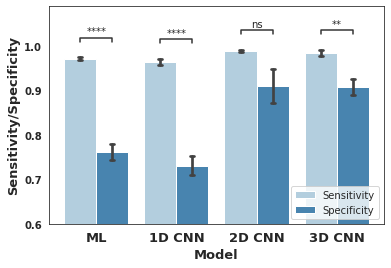

In [ ]:
arousal_df_new = pd.melt(arousal_df[valence_df['Data']=='PD'], id_vars=['Model'], value_vars=['Sensitivity', 'Specificity'],
        var_name='Test', value_name='Value')
x = "Model"
y = "Value"
hue = "Test"
ax = sns.barplot(data=arousal_df_new, x=x, y=y, hue = hue, palette = "Blues", capsize=0.05, ci=68)
ax.set_ylim(bottom=0.6)
ax.legend(loc='lower right', bbox_to_anchor=(1,0))
ax.set_xlabel('Model',fontsize = 13, weight='bold')
ax.set_ylabel('Sensitivity/Specificity',fontsize = 13, weight='bold')
ax.set_xticklabels(["ML", "1D CNN", "2D CNN", "3D CNN"], rotation=0, fontsize = 13, weight='bold');
ax.set_yticklabels(["0.6", "0.7", "0.8", "0.9", "1.0"], size= 10, weight='bold')
add_stat_annotation(ax, data=arousal_df_new, x=x, y=y, hue=hue,
                    box_pairs=[(("ML", "Sensitivity"), ("ML", "Specificity")),
                                 (("1D CNN", "Sensitivity"), ("1D CNN", "Specificity")),
                                 (("2D CNN", "Sensitivity"), ("2D CNN", "Specificity")),
                               (("3D CNN", "Sensitivity"), ("3D CNN", "Specificity"))
                                ],
                    test='t-test_ind', text_format='star', loc='inside', verbose=2)

plt.savefig('sens_and_speci_arousal.eps', format='eps', bbox_inches='tight')
#FILE.download('sensitivity_valence.eps')

In [ ]:
data = 'PD'
print("-----", data, "----")
hala_pd_3d = get_metric('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/CNN_3D_our/CNN_3D_results_HALA_'+str(data)+'.mat', 'f1_weightedNet')
hala_pd_2d = get_metric('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/CNN_2D_our/CNN_2D_results_HALA_'+str(data)+'.mat', 'f1_weightedNet')
hala_pd_1d = get_metric('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/1D_CNN_Results/CSP/CNN_1D_results_HALA_CSP_'+str(data)+'.mat', 'f1_weightedNet')
hala_pd_ml = get_metric('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/MLResults/CSP/ML_HALA_CSP_'+str(data)+'.mat', 'wtd_f1_list')

data = 'NC'
hala_nc_3d = get_metric('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/CNN_3D_our/CNN_3D_results_HALA_'+str(data)+'.mat', 'f1_weightedNet')
hala_nc_2d = get_metric('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/CNN_2D_our/CNN_2D_results_HALA_'+str(data)+'.mat', 'f1_weightedNet')
hala_nc_1d = get_metric('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/1D_CNN_Results/CSP/CNN_1D_results_HALA_CSP_'+str(data)+'.mat', 'f1_weightedNet')
hala_nc_ml = get_metric('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/MLResults/CSP/ML_HALA_CSP_'+str(data)+'.mat', 'wtd_f1_list')

data1 = {'F-Score': hala_nc_ml[0], 'Data': len(hala_nc_ml[0])*['NC'], 'Model': len(hala_nc_ml[0])*['ML']}
df1 = pd.DataFrame(data1)
data2 = {'F-Score': hala_pd_ml[0], 'Data': len(hala_pd_ml[0])*['PD'], 'Model': len(hala_pd_ml[0])*['ML']}
df2 = pd.DataFrame(data2)
data3 = {'F-Score': hala_nc_1d[0], 'Data': len(hala_nc_1d[0])*['NC'], 'Model': len(hala_nc_1d[0])*['1D CNN']}
df3 = pd.DataFrame(data3)
data4 = {'F-Score': hala_pd_1d[0], 'Data': len(hala_pd_1d[0])*['PD'], 'Model': len(hala_pd_1d[0])*['1D CNN']}
df4 = pd.DataFrame(data4)
data5 = {'F-Score': hala_nc_2d[0], 'Data': len(hala_nc_2d[0])*['NC'], 'Model': len(hala_nc_2d[0])*['2D CNN']}
df5 = pd.DataFrame(data5)
data6 = {'F-Score': hala_pd_2d[0], 'Data': len(hala_pd_2d[0])*['PD'], 'Model': len(hala_pd_2d[0])*['2D CNN']}
df6 = pd.DataFrame(data6)
data7 = {'F-Score': hala_nc_3d[0], 'Data': len(hala_nc_3d[0])*['NC'], 'Model': len(hala_nc_3d[0])*['3D CNN']}
df7 = pd.DataFrame(data7)
data8 = {'F-Score': hala_pd_3d[0], 'Data': len(hala_pd_3d[0])*['PD'], 'Model': len(hala_pd_3d[0])*['3D CNN']}
df8 = pd.DataFrame(data8)

arousal_fscore_df = pd.concat([df1, df2, df3, df4, df5, df6, df7, df8], axis=0).reset_index()
print(arousal_fscore_df)


----- PD ----
    index   F-Score Data   Model
0       0  0.930163   NC      ML
1       1  0.949764   NC      ML
2       2  0.930130   NC      ML
3       3  0.943360   NC      ML
4       4  0.951068   NC      ML
..    ...       ...  ...     ...
75      5  0.977965   PD  3D CNN
76      6  0.980991   PD  3D CNN
77      7  0.980991   PD  3D CNN
78      8  0.991870   PD  3D CNN
79      9  0.982039   PD  3D CNN

[80 rows x 4 columns]


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

1D CNN_NC v.s. 1D CNN_PD: t-test independent samples with Bonferroni correction, P_val=4.918e-04 stat=4.871e+00
ML_NC v.s. ML_PD: t-test independent samples with Bonferroni correction, P_val=5.793e-01 stat=1.524e+00
2D CNN_NC v.s. 2D CNN_PD: t-test independent samples with Bonferroni correction, P_val=2.404e-02 stat=-3.113e+00
3D CNN_NC v.s. 3D CNN_PD: t-test independent samples with Bonferroni correction, P_val=1.000e+00 stat=-4.937e-01


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


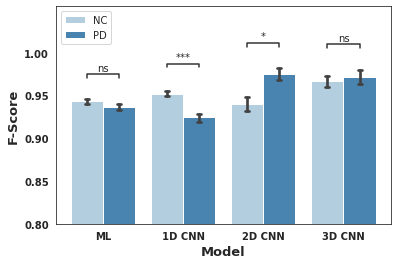

In [ ]:
x = "Model"
y = "F-Score"
hue = "Data"
ax = sns.barplot(data=arousal_fscore_df, x=x, y=y, hue=hue, palette = "Blues", capsize=.05, ci=68)
ax.set_ylim(bottom=0.8)
ax.legend(loc='upper left', bbox_to_anchor=(0,1))
ax.set_xlabel('Model',fontsize = 13, weight='bold')
ax.set_ylabel('F-Score',fontsize = 13, weight='bold')
ax.set_xticklabels(["ML", "1D CNN", "2D CNN", "3D CNN"], rotation=0, fontsize = 10, weight='bold')
#_, ylabels = plt.yticks()
#ax.set_yticklabels(ylabels, fontsize = 10, weight = 'bold');
#ax.set_yticklabels(ax.get_yticklabels(), size= 10, weight='bold')
ax.set_yticklabels(["0.80", "0.85", "0.90", "0.95", "1.00"], size= 10, weight='bold')
add_stat_annotation(ax, data=arousal_fscore_df, x=x, y=y, hue=hue,
                    box_pairs=[(("ML", "PD"), ("ML", "NC")),
                                 (("1D CNN", "PD"), ("1D CNN", "NC")),
                                 (("2D CNN", "PD"), ("2D CNN", "NC")),
                               (("3D CNN", "PD"), ("3D CNN", "NC"))
                                ],
                    test='t-test_ind', text_format='star', loc='inside', verbose=2)

plt.savefig('f-score_arousal.eps', format='eps', bbox_inches='tight')
#FILE.download('sensitivity_valence.eps')

## Multiclass

In [ ]:
def get_metric(dataPath, metric):
  matContent = sio.loadmat(dataPath)
  metric = matContent[metric]
  return metric

def sad_acc(metric):
  pos_list = [i[0][0] for i in metric]
  pos_list_m = round(np.mean(pos_list),2)
  pos_list_s = round(np.std(pos_list),2)
  return [pos_list_m, pos_list_s] 

def happy_acc(metric):
  pos_list = [i[1][1] for i in metric]
  pos_list_m = round(np.mean(pos_list),2)
  pos_list_s = round(np.std(pos_list),2)
  return [pos_list_m, pos_list_s]

def fear_acc(metric):
  pos_list = [i[2][2] for i in metric]
  pos_list_m = round(np.mean(pos_list),2)
  pos_list_s = round(np.std(pos_list),2)
  return [pos_list_m, pos_list_s]

def disgust_acc(metric):
  pos_list = [i[3][3] for i in metric]
  pos_list_m = round(np.mean(pos_list),2)
  pos_list_s = round(np.std(pos_list),2)
  return [pos_list_m, pos_list_s] 

def surprise_acc(metric):
  pos_list = [i[4][4] for i in metric]
  pos_list_m = round(np.mean(pos_list),2)
  pos_list_s = round(np.std(pos_list),2)
  return [pos_list_m, pos_list_s]  

def anger_acc(metric):
  pos_list = [i[5][5] for i in metric]
  pos_list_m = round(np.mean(pos_list),2)
  pos_list_s = round(np.std(pos_list),2)
  return [pos_list_m, pos_list_s]  


data = 'PD'
print("-----", data, "----")
print("-----3D----")
multi_pd_3d = get_metric('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/CNN_3D_our/CNN_3D_results_MultiClass_'+str(data)+'.mat', 'conf_mat_list')
sad_3pd = sad_acc(multi_pd_3d)
happy_3pd = happy_acc(multi_pd_3d)
fear_3pd = fear_acc(multi_pd_3d)
disgust_3pd = disgust_acc(multi_pd_3d)
surprise_3pd = surprise_acc(multi_pd_3d)
anger_3pd = anger_acc(multi_pd_3d)
print('Sad:',sad_3pd[0],'+-',sad_3pd[1])
print('Happy:',happy_3pd[0],'+-',happy_3pd[1])
print('Fear:',fear_3pd[0],'+-',fear_3pd[1])
print('Disgust:',disgust_3pd[0],'+-',disgust_3pd[1])
print('Surprise:',surprise_3pd[0],'+-',surprise_3pd[1])
print('Anger:',anger_3pd[0],'+-',anger_3pd[1])

print("-----2D----")
multi_pd_2d = get_metric('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/CNN_2D_our/CNN_2D_results_MultiClass_'+str(data)+'.mat', 'conf_mat_list')
sad_2pd = sad_acc(multi_pd_2d)
happy_2pd = happy_acc(multi_pd_2d)
fear_2pd = fear_acc(multi_pd_2d)
disgust_2pd = disgust_acc(multi_pd_2d)
surprise_2pd = surprise_acc(multi_pd_2d)
anger_2pd = anger_acc(multi_pd_2d)
print('Sad:',sad_2pd[0],'+-',sad_2pd[1])
print('Happy:',happy_2pd[0],'+-',happy_2pd[1])
print('Fear:',fear_2pd[0],'+-',fear_2pd[1])
print('Disgust:',disgust_2pd[0],'+-',disgust_2pd[1])
print('Surprise:',surprise_2pd[0],'+-',surprise_2pd[1])
print('Anger:',anger_2pd[0],'+-',anger_2pd[1])

print("-----1D----")
multi_pd_1d = get_metric('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/1D_CNN_Results/IIR/CNN_1D_results_MultiClass_IIR_'+str(data)+'.mat', 'conf_mat_list')
sad_1pd = sad_acc(multi_pd_1d)
happy_1pd = happy_acc(multi_pd_1d)
fear_1pd = fear_acc(multi_pd_1d)
disgust_1pd = disgust_acc(multi_pd_1d)
surprise_1pd = surprise_acc(multi_pd_1d)
anger_1pd = anger_acc(multi_pd_1d)
print('Sad:',sad_1pd[0],'+-',sad_1pd[1])
print('Happy:',happy_1pd[0],'+-',happy_1pd[1])
print('Fear:',fear_1pd[0],'+-',fear_1pd[1])
print('Disgust:',disgust_1pd[0],'+-',disgust_1pd[1])
print('Surprise:',surprise_1pd[0],'+-',surprise_1pd[1])
print('Anger:',anger_1pd[0],'+-',anger_1pd[1])

print("-----ML----")
multi_pd_ml = get_metric('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/MLResults/CSP/ML_MultiClass_CSP_'+str(data)+'.mat', 'conf_mat_list')
sad_pd_ml = sad_acc(multi_pd_ml)
happy_pd_ml = happy_acc(multi_pd_ml)
fear_pd_ml = fear_acc(multi_pd_ml)
disgust_pd_ml = disgust_acc(multi_pd_ml)
surprise_pd_ml = surprise_acc(multi_pd_ml)
anger_pd_ml = anger_acc(multi_pd_ml)
print('Sad:',sad_pd_ml[0],'+-',sad_pd_ml[1])
print('Happy:',happy_pd_ml[0],'+-',happy_pd_ml[1])
print('Fear:',fear_pd_ml[0],'+-',fear_pd_ml[1])
print('Disgust:',disgust_pd_ml[0],'+-',disgust_pd_ml[1])
print('Surprise:',surprise_pd_ml[0],'+-',surprise_pd_ml[1])
print('Anger:',anger_pd_ml[0],'+-',anger_pd_ml[1])

data = 'NC'
print("-----", data, "----")
print("-----3D----")
multi_nc_3d = get_metric('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/CNN_3D_our/CNN_3D_results_MultiClass_'+str(data)+'.mat', 'conf_mat_list')
sad_3nc = sad_acc(multi_nc_3d)
happy_3nc = happy_acc(multi_nc_3d)
fear_3nc = fear_acc(multi_nc_3d)
disgust_3nc = disgust_acc(multi_nc_3d)
surprise_3nc = surprise_acc(multi_nc_3d)
anger_3nc = anger_acc(multi_nc_3d)
print('Sad:',sad_3nc[0],'+-',sad_3nc[1])
print('Happy:',happy_3nc[0],'+-',happy_3nc[1])
print('Fear:',fear_3nc[0],'+-',fear_3nc[1])
print('Disgust:',disgust_3nc[0],'+-',disgust_3nc[1])
print('Surprise:',surprise_3nc[0],'+-',surprise_3nc[1])
print('Anger:',anger_3nc[0],'+-',anger_3nc[1])

print("-----2D----")
multi_nc_2d = get_metric('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/CNN_2D_our/CNN_2D_results_MultiClass_'+str(data)+'.mat', 'conf_mat_list')
sad_2nc = sad_acc(multi_nc_2d)
happy_2nc = happy_acc(multi_nc_2d)
fear_2nc = fear_acc(multi_nc_2d)
disgust_2nc = disgust_acc(multi_nc_2d)
surprise_2nc = surprise_acc(multi_nc_2d)
anger_2nc = anger_acc(multi_nc_2d)
print('Sad:',sad_2nc[0],'+-',sad_2nc[1])
print('Happy:',happy_2nc[0],'+-',happy_2nc[1])
print('Fear:',fear_2nc[0],'+-',fear_2nc[1])
print('Disgust:',disgust_2nc[0],'+-',disgust_2nc[1])
print('Surprise:',surprise_2nc[0],'+-',surprise_2nc[1])
print('Anger:',anger_2nc[0],'+-',anger_2nc[1])

print("-----1D----")
multi_nc_1d = get_metric('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/1D_CNN_Results/IIR/CNN_1D_results_MultiClass_IIR_'+str(data)+'.mat', 'conf_mat_list')
sad_1nc = sad_acc(multi_nc_1d)
happy_1nc = happy_acc(multi_nc_1d)
fear_1nc = fear_acc(multi_nc_1d)
disgust_1nc = disgust_acc(multi_nc_1d)
surprise_1nc = surprise_acc(multi_nc_1d)
anger_1nc = anger_acc(multi_nc_1d)
print('Sad:',sad_1nc[0],'+-',sad_1nc[1])
print('Happy:',happy_1nc[0],'+-',happy_1nc[1])
print('Fear:',fear_1nc[0],'+-',fear_1nc[1])
print('Disgust:',disgust_1nc[0],'+-',disgust_1nc[1])
print('Surprise:',surprise_1nc[0],'+-',surprise_1nc[1])
print('Anger:',anger_1nc[0],'+-',anger_1nc[1])

print("-----ML----")
multi_nc_ml = get_metric('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/MLResults/CSP/ML_MultiClass_CSP_'+str(data)+'.mat', 'conf_mat_list')
sad_nc_ml = sad_acc(multi_nc_ml)
happy_nc_ml = happy_acc(multi_nc_ml)
fear_nc_ml = fear_acc(multi_nc_ml)
disgust_nc_ml = disgust_acc(multi_nc_ml)
surprise_nc_ml = surprise_acc(multi_nc_ml)
anger_nc_ml = anger_acc(multi_nc_ml)
print('Sad:',sad_nc_ml[0],'+-',sad_nc_ml[1])
print('Happy:',happy_nc_ml[0],'+-',happy_nc_ml[1])
print('Fear:',fear_nc_ml[0],'+-',fear_nc_ml[1])
print('Disgust:',disgust_nc_ml[0],'+-',disgust_nc_ml[1])
print('Surprise:',surprise_nc_ml[0],'+-',surprise_nc_ml[1])
print('Anger:',anger_nc_ml[0],'+-',anger_nc_ml[1])

----- PD ----
-----3D----
Sad: 0.94 +- 0.08
Happy: 0.87 +- 0.11
Fear: 0.85 +- 0.12
Disgust: 0.87 +- 0.12
Surprise: 0.87 +- 0.09
Anger: 0.88 +- 0.11
-----2D----
Sad: 0.93 +- 0.05
Happy: 0.86 +- 0.11
Fear: 0.81 +- 0.13
Disgust: 0.82 +- 0.14
Surprise: 0.8 +- 0.13
Anger: 0.83 +- 0.11
-----1D----
Sad: 0.87 +- 0.15
Happy: 0.84 +- 0.18
Fear: 0.8 +- 0.21
Disgust: 0.78 +- 0.22
Surprise: 0.79 +- 0.25
Anger: 0.81 +- 0.24
-----ML----
Sad: 0.81 +- 0.02
Happy: 0.77 +- 0.04
Fear: 0.75 +- 0.03
Disgust: 0.76 +- 0.03
Surprise: 0.71 +- 0.04
Anger: 0.75 +- 0.03
----- NC ----
-----3D----
Sad: 0.93 +- 0.07
Happy: 0.92 +- 0.07
Fear: 0.89 +- 0.09
Disgust: 0.88 +- 0.09
Surprise: 0.89 +- 0.08
Anger: 0.91 +- 0.06
-----2D----
Sad: 0.9 +- 0.08
Happy: 0.91 +- 0.07
Fear: 0.82 +- 0.08
Disgust: 0.85 +- 0.08
Surprise: 0.83 +- 0.12
Anger: 0.88 +- 0.07
-----1D----
Sad: 0.75 +- 0.25
Happy: 0.76 +- 0.27
Fear: 0.82 +- 0.24
Disgust: 0.8 +- 0.17
Surprise: 0.76 +- 0.22
Anger: 0.79 +- 0.22
-----ML----
Sad: 0.83 +- 0.03
Happy: 0

In [ ]:
data1 = {'Sad': [i[0][0] for i in multi_nc_ml], 'Happy': [i[1][1] for i in multi_nc_ml],
         'Fear': [i[2][2] for i in multi_nc_ml], 'Disgust':[i[3][3] for i in multi_nc_ml],
         'Surprise': [i[4][4] for i in multi_nc_ml], 'Anger': [i[5][5] for i in multi_nc_ml],
          'Data': len([i[1][1] for i in multi_nc_ml])*['NC'], 'Model': len([i[1][1] for i in multi_nc_ml])*['ML']}
df1 = pd.DataFrame(data1)
data2 = {'Sad': [i[0][0] for i in multi_pd_ml], 'Happy': [i[1][1] for i in multi_pd_ml],
         'Fear': [i[2][2] for i in multi_pd_ml], 'Disgust':[i[3][3] for i in multi_pd_ml],
         'Surprise': [i[4][4] for i in multi_pd_ml], 'Anger': [i[5][5] for i in multi_pd_ml],
          'Data': len([i[1][1] for i in multi_pd_ml])*['PD'], 'Model': len([i[1][1] for i in multi_pd_ml])*['ML']}
df2 = pd.DataFrame(data2)
data3 = {'Sad': [i[0][0] for i in multi_pd_1d], 'Happy': [i[1][1] for i in multi_pd_1d],
         'Fear': [i[2][2] for i in multi_pd_1d], 'Disgust':[i[3][3] for i in multi_pd_1d],
         'Surprise': [i[4][4] for i in multi_pd_1d], 'Anger': [i[5][5] for i in multi_pd_1d],
          'Data': len([i[1][1] for i in multi_pd_1d])*['PD'], 'Model': len([i[1][1] for i in multi_pd_1d])*['1D CNN']}
df3 = pd.DataFrame(data3)
data4 = {'Sad': [i[0][0] for i in multi_nc_1d], 'Happy': [i[1][1] for i in multi_nc_1d],
         'Fear': [i[2][2] for i in multi_nc_1d], 'Disgust':[i[3][3] for i in multi_nc_1d],
         'Surprise': [i[4][4] for i in multi_nc_1d], 'Anger': [i[5][5] for i in multi_nc_1d],
          'Data': len([i[1][1] for i in multi_nc_1d])*['NC'], 'Model': len([i[1][1] for i in multi_nc_1d])*['1D CNN']}
df4 = pd.DataFrame(data4)
data5 = {'Sad': [i[0][0] for i in multi_pd_2d], 'Happy': [i[1][1] for i in multi_pd_2d],
         'Fear': [i[2][2] for i in multi_pd_2d], 'Disgust':[i[3][3] for i in multi_pd_2d],
         'Surprise': [i[4][4] for i in multi_pd_2d], 'Anger': [i[5][5] for i in multi_pd_2d],
          'Data': len([i[1][1] for i in multi_pd_2d])*['PD'], 'Model': len([i[1][1] for i in multi_pd_2d])*['2D CNN']}
df5 = pd.DataFrame(data5)
data6 = {'Sad': [i[0][0] for i in multi_nc_2d], 'Happy': [i[1][1] for i in multi_nc_2d],
         'Fear': [i[2][2] for i in multi_nc_2d], 'Disgust':[i[3][3] for i in multi_nc_2d],
         'Surprise': [i[4][4] for i in multi_nc_2d], 'Anger': [i[5][5] for i in multi_nc_2d],
          'Data': len([i[1][1] for i in multi_nc_2d])*['NC'], 'Model': len([i[1][1] for i in multi_nc_2d])*['2D CNN']}
df6 = pd.DataFrame(data6)
data7 = {'Sad': [i[0][0] for i in multi_pd_3d], 'Happy': [i[1][1] for i in multi_pd_3d],
         'Fear': [i[2][2] for i in multi_pd_3d], 'Disgust':[i[3][3] for i in multi_pd_3d],
         'Surprise': [i[4][4] for i in multi_pd_3d], 'Anger': [i[5][5] for i in multi_pd_3d],
          'Data': len([i[1][1] for i in multi_pd_3d])*['PD'], 'Model': len([i[1][1] for i in multi_pd_3d])*['3D CNN']}
df7 = pd.DataFrame(data7)
data8 = {'Sad': [i[0][0] for i in multi_nc_3d], 'Happy': [i[1][1] for i in multi_nc_3d],
         'Fear': [i[2][2] for i in multi_nc_3d], 'Disgust':[i[3][3] for i in multi_nc_3d],
         'Surprise': [i[4][4] for i in multi_nc_3d], 'Anger': [i[5][5] for i in multi_nc_3d],
          'Data': len([i[1][1] for i in multi_nc_3d])*['NC'], 'Model': len([i[1][1] for i in multi_nc_3d])*['3D CNN']}
df8 = pd.DataFrame(data8)

multi_df = pd.concat([df1, df2, df3, df4, df5, df6, df7, df8], axis=0).reset_index()
print(multi_df)

    index       Sad     Happy      Fear  ...  Surprise     Anger  Data   Model
0       0  0.867769  0.744000  0.680672  ...  0.800000  0.739837    NC      ML
1       1  0.816667  0.769841  0.652542  ...  0.664000  0.707317    NC      ML
2       2  0.783333  0.769841  0.677966  ...  0.629032  0.774194    NC      ML
3       3  0.825000  0.769841  0.593220  ...  0.701613  0.830645    NC      ML
4       4  0.833333  0.785714  0.635593  ...  0.758065  0.774194    NC      ML
..    ...       ...       ...       ...  ...       ...       ...   ...     ...
75      5  0.966942  0.930233  0.883333  ...  0.928000  0.912698    NC  3D CNN
76      6  0.958678  0.953488  0.900000  ...  0.936000  0.920635    NC  3D CNN
77      7  0.933884  0.961240  0.941667  ...  0.952000  0.952381    NC  3D CNN
78      8  0.983471  0.968992  0.950000  ...  0.904000  0.968254    NC  3D CNN
79      9  0.958678  0.976744  0.941667  ...  0.952000  0.984127    NC  3D CNN

[80 rows x 9 columns]


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Happy_NC v.s. Happy_PD: t-test independent samples with Bonferroni correction, P_val=1.000e+00 stat=6.064e-01
Sad_NC v.s. Sad_PD: t-test independent samples with Bonferroni correction, P_val=2.467e-01 stat=2.200e+00
Fear_NC v.s. Fear_PD: t-test independent samples with Bonferroni correction, P_val=9.158e-05 stat=-5.853e+00
Disgust_NC v.s. Disgust_PD: t-test independent samples with Bonferroni correction, P_val=3.458e-03 stat=-4.169e+00
Surprise_NC v.s. Surprise_PD: t-test independent samples with Bonferroni correction, P_val=1.000e+00 stat=7.104e-01
Anger_NC v.s. Anger_PD: t-test independent samples with Bonferroni correction, P_val=1.000e+00 stat=-6.714e-01
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Happy

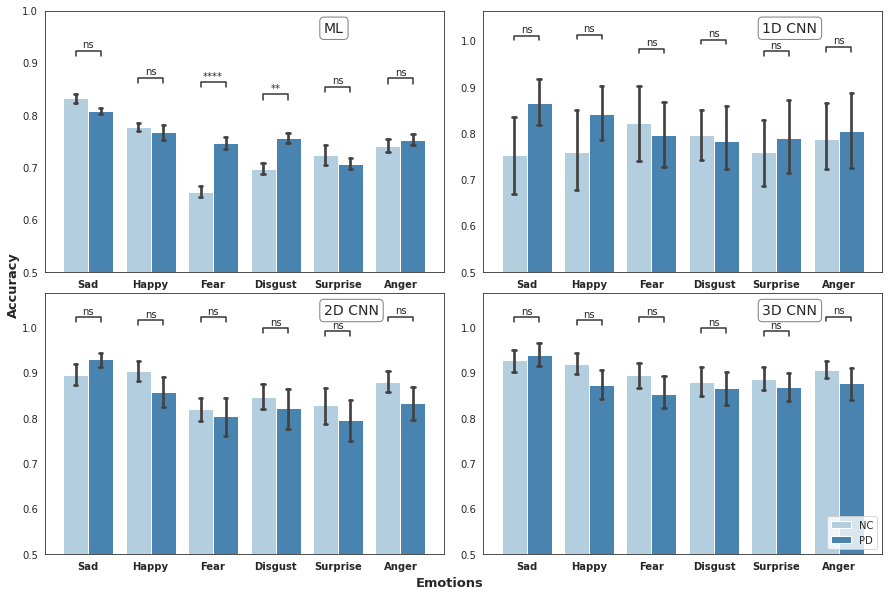

<Figure size 432x288 with 0 Axes>

In [ ]:
multi_df_new = pd.melt(multi_df, id_vars=['Model', 'Data'], value_vars=['Sad', 'Happy', 'Fear', 'Disgust',
                                                                'Surprise', 'Anger'],
        var_name='Emotions', value_name='Accuracy')

x = "Emotions"
y = "Accuracy"
hue = "Data"


fig = plt.figure(figsize=(15, 10))
fig.subplots_adjust(hspace=0.08, wspace=0.1)
ax = fig.add_subplot(2, 2, 1)
plt.setp(ax, ylim=(0.5, 1.0))
g1 = sns.barplot(data=multi_df_new[multi_df_new['Model']=='ML'], x=x, y=y, hue=hue,
                 ax=ax, palette = "Blues", capsize=0.05, ci=68, hue_order = ["NC", "PD"])
#g1.set_ylim(bottom=0.55, top=1.0)
#g1.legend(loc='upper left', bbox_to_anchor=(0,1))
#g.set_xlabel('',fontsize = 13, weight='bold')
#g1.set_ylabel('Accuracy',fontsize = 13, weight='bold')
#g.set_xticklabels(["ML", "1D CNN", "2D CNN", "3D CNN"], rotation=0, fontsize = 10, weight='bold')
#_, ylabels = plt.yticks()
#ax.set_yticklabels(ylabels, fontsize = 10, weight = 'bold');
#ax.set_yticklabels(ax.get_yticklabels(), size= 10, weight='bold')
#ax.set_yticklabels(["0.80", "0.85", "0.90", "0.95", "1.00"], size= 10, weight='bold')
add_stat_annotation(g1, data=multi_df_new[multi_df_new['Model']=='ML'], x=x, y=y, hue=hue,
                    box_pairs=[(("Sad", "PD"), ("Sad", "NC")),
                                 (("Happy", "PD"), ("Happy", "NC")),
                                 (("Fear", "PD"), ("Fear", "NC")),
                               (("Disgust", "PD"), ("Disgust", "NC")),
                               (("Surprise", "PD"), ("Surprise", "NC")),
                               (("Anger", "PD"), ("Anger", "NC"))
                                ],
                    test='t-test_ind', text_format='star', loc='inside', verbose=2)
ax.set_ylabel('')    
ax.set_xlabel('')
g1.legend_.remove()

ax = fig.add_subplot(2, 2, 2)
plt.setp(ax, ylim=(0.5, 1.0))
g2 = sns.barplot(data=multi_df_new[multi_df_new['Model']=='1D CNN'], x=x, y=y,
                 hue=hue, ax=ax, palette = "Blues", capsize=0.05, ci=68, hue_order = ["NC", "PD"])
#g2.set_ylim(bottom=0.55, top=1.0)
#g2.legend(loc='upper left', bbox_to_anchor=(0,1))
#g.set_xlabel('',fontsize = 13, weight='bold')
#g1.set_ylabel('Accuracy',fontsize = 13, weight='bold')
#g.set_xticklabels(["ML", "1D CNN", "2D CNN", "3D CNN"], rotation=0, fontsize = 10, weight='bold')
#_, ylabels = plt.yticks()
#ax.set_yticklabels(ylabels, fontsize = 10, weight = 'bold');
#ax.set_yticklabels(ax.get_yticklabels(), size= 10, weight='bold')
#ax.set_yticklabels(["0.80", "0.85", "0.90", "0.95", "1.00"], size= 10, weight='bold')
add_stat_annotation(g2, data=multi_df_new[multi_df_new['Model']=='1D CNN'], x=x, y=y, hue=hue,
                    box_pairs=[(("Sad", "PD"), ("Sad", "NC")),
                                 (("Happy", "PD"), ("Happy", "NC")),
                                 (("Fear", "PD"), ("Fear", "NC")),
                               (("Disgust", "PD"), ("Disgust", "NC")),
                               (("Surprise", "PD"), ("Surprise", "NC")),
                               (("Anger", "PD"), ("Anger", "NC"))
                                ],
                    test='t-test_ind', text_format='star', loc='inside', verbose=2)

ax.set_ylabel('')    
ax.set_xlabel('')
g2.legend_.remove()

ax = fig.add_subplot(2, 2, 3)
plt.setp(ax, ylim=(0.5, 1.0))
g3 = sns.barplot(data=multi_df_new[multi_df_new['Model']=='2D CNN'], x=x, y=y,
                 hue=hue, ax=ax, palette = "Blues", capsize=0.05, ci=68, hue_order = ["NC", "PD"])
#g3.set_ylim(bottom=0.55, top=1.0)
#g2.legend(loc='upper left', bbox_to_anchor=(0,1))
#g.set_xlabel('',fontsize = 13, weight='bold')
#g1.set_ylabel('Accuracy',fontsize = 13, weight='bold')
#_, ylabels = plt.yticks()
#ax.set_yticklabels(ylabels, fontsize = 10, weight = 'bold');
#ax.set_yticklabels(ax.get_yticklabels(), size= 10, weight='bold')
#ax.set_yticklabels(["0.80", "0.85", "0.90", "0.95", "1.00"], size= 10, weight='bold')
add_stat_annotation(g3, data=multi_df_new[multi_df_new['Model']=='3D CNN'], x=x, y=y, hue=hue,
                    box_pairs=[(("Sad", "PD"), ("Sad", "NC")),
                                 (("Happy", "PD"), ("Happy", "NC")),
                                 (("Fear", "PD"), ("Fear", "NC")),
                               (("Disgust", "PD"), ("Disgust", "NC")),
                               (("Surprise", "PD"), ("Surprise", "NC")),
                               (("Anger", "PD"), ("Anger", "NC"))
                                ],
                    test='t-test_ind', text_format='star', loc='inside', verbose=2)

ax.set_ylabel('')    
ax.set_xlabel('')
g3.legend_.remove()

#ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax = fig.add_subplot(2, 2, 4)
plt.setp(ax, ylim=(0.5, 1.0))
g4 = sns.barplot(data=multi_df_new[multi_df_new['Model']=='3D CNN'], x=x, y=y,
                 hue=hue, ax=ax, palette = "Blues", capsize=0.05, ci=68, hue_order = ["NC", "PD"])
#g4.set_ylim(bottom=0.55, top=1.0)
g4.legend(loc='lower right', bbox_to_anchor=(1,0))
#g.set_xlabel('',fontsize = 13, weight='bold')
#g1.set_ylabel('Accuracy',fontsize = 13, weight='bold')
#g.set_xticklabels(["ML", "1D CNN", "2D CNN", "3D CNN"], rotation=0, fontsize = 10, weight='bold')
#_, ylabels = plt.yticks()
#ax.set_yticklabels(ylabels, fontsize = 10, weight = 'bold');
#g4.set_yticklabels(g4.get_yticklabels(), size= 10, weight='bold')
#ax.set_yticklabels(["0.80", "0.85", "0.90", "0.95", "1.00"], size= 10, weight='bold')
add_stat_annotation(g4, data=multi_df_new[multi_df_new['Model']=='3D CNN'], x=x, y=y, hue=hue,
                    box_pairs=[(("Sad", "PD"), ("Sad", "NC")),
                                 (("Happy", "PD"), ("Happy", "NC")),
                                 (("Fear", "PD"), ("Fear", "NC")),
                               (("Disgust", "PD"), ("Disgust", "NC")),
                               (("Surprise", "PD"), ("Surprise", "NC")),
                               (("Anger", "PD"), ("Anger", "NC"))
                                ],
                    test='t-test_ind', text_format='star', loc='inside', verbose=2)
ax.set_ylabel('')    
ax.set_xlabel('')

props = dict(boxstyle='round', facecolor='none', edgecolor='black', alpha=0.5)

# place a text box in upper left in axes coords
g1.text(0.7, 0.96, "ML", transform=g1.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
g2.text(0.7, 0.96, "1D CNN", transform=g2.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
g3.text(0.7, 0.96, "2D CNN", transform=g3.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
g4.text(0.7, 0.96, "3D CNN", transform=g4.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

g1.set_xticklabels(["Sad", "Happy", "Fear", "Disgust", "Surprise", "Anger"], rotation=0, fontsize = 10, weight='bold')
g2.set_xticklabels(["Sad", "Happy", "Fear", "Disgust", "Surprise", "Anger"], rotation=0, fontsize = 10, weight='bold')
g3.set_xticklabels(["Sad", "Happy", "Fear", "Disgust", "Surprise", "Anger"], rotation=0, fontsize = 10, weight='bold')
g4.set_xticklabels(["Sad", "Happy", "Fear", "Disgust", "Surprise", "Anger"], rotation=0, fontsize = 10, weight='bold')
#plt.setp(ax, ylim=(0.5, 1.0))

fig.text(0.5, 0.08, 'Emotions', ha='center', fontsize = 13, weight='bold')
fig.text(0.09, 0.5, 'Accuracy', va='center', rotation='vertical', fontsize = 13, weight='bold')

plt.show()

plt.savefig('multi_class.eps', format='eps', bbox_inches='tight')
#FILE.download('sensitivity_valence.eps')

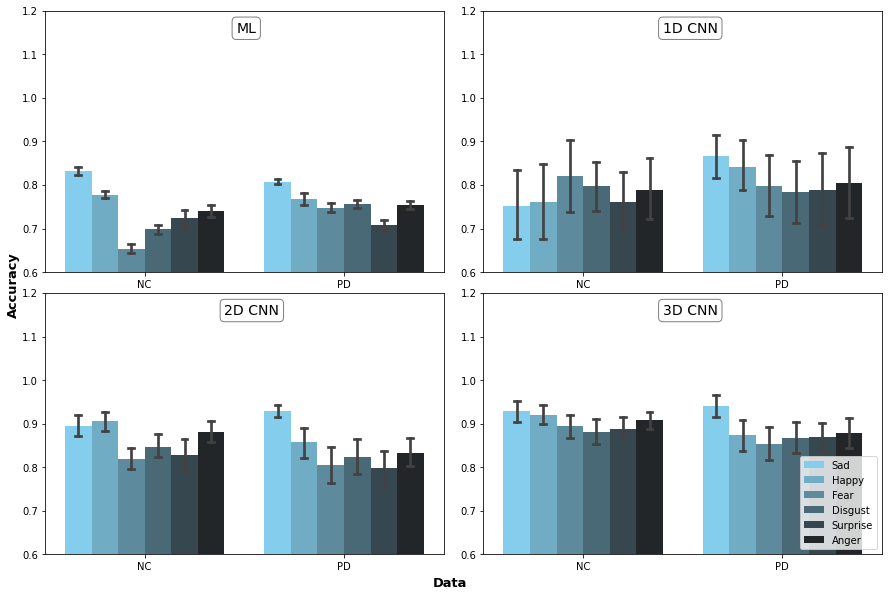

In [ ]:
from itertools import combinations

multi_df_new = pd.melt(multi_df, id_vars=['Model', 'Data'], value_vars=['Sad', 'Happy', 'Fear', 'Disgust',
                                                                'Surprise', 'Anger'],
        var_name='Emotions', value_name='Accuracy')

x = "Data"
y = "Accuracy"
hue = "Emotions"
order = ["NC", "PD"]
hue_order = ['Sad', 'Happy', 'Fear', 'Disgust','Surprise', 'Anger']
box_pairs=[]
box_pairs1 = [(('PD', emot[0]), ('PD', emot[1])) for emot in list(combinations(multi_df_new['Emotions'].unique(), 2))]
box_pairs2 = [(('NC', emot[0]), ('NC', emot[1])) for emot in list(combinations(multi_df_new['Emotions'].unique(), 2))]


fig = plt.figure(figsize=(15, 10))
fig.subplots_adjust(hspace=0.08, wspace=0.1)
ax = fig.add_subplot(2, 2, 1)
plt.setp(ax, ylim=(0.6, 1.2))
#palette = "ch:start=.2,rot=-.3"
#palette = "ch:s=.2,r=-.2"
palette = "dark:#73D4FE_r"
g1 = sns.barplot(data=multi_df_new[multi_df_new['Model']=='ML'], x=x, y=y, hue=hue, order=order,
                 ax=ax, capsize=0.03,palette = palette, ci=68, hue_order = hue_order)

#add_stat_annotation(g1, data=multi_df_new[multi_df_new['Model']=='ML'], x=x, y=y, hue=hue,
#                    box_pairs=box_pairs1,line_offset_to_box=0.2, line_offset=0.1, line_height=0.05,
#                    test='t-test_ind', text_format='star', loc='inside', verbose=2)
#add_stat_annotation(g1, data=multi_df_new[multi_df_new['Model']=='ML'], x=x, y=y, hue=hue,
#                    box_pairs=box_pairs2,line_offset_to_box=0.2, line_offset=0.1, line_height=0.05,
#                    test='t-test_ind', text_format='star', loc='inside', verbose=2)


ax.set_ylabel('')    
ax.set_xlabel('')
g1.legend_.remove()

ax = fig.add_subplot(2, 2, 2)
plt.setp(ax, ylim=(0.6, 1.2))
g2 = sns.barplot(data=multi_df_new[multi_df_new['Model']=='1D CNN'], x=x, y=y, order=order,
                 hue=hue, ax=ax, palette = palette, capsize=0.03, ci=68, hue_order = hue_order)
#add_stat_annotation(g2, data=multi_df_new[multi_df_new['Model']=='1D CNN'], x=x, y=y, hue=hue,
#                    box_pairs=box_pairs1,line_offset_to_box=0.2, line_offset=0.1, line_height=0.05,
#                    test='t-test_ind', text_format='star', loc='inside', verbose=2)
#
#add_stat_annotation(g2, data=multi_df_new[multi_df_new['Model']=='1D CNN'], x=x, y=y, hue=hue,
#                    box_pairs=box_pairs2,line_offset_to_box=0.2, line_offset=0.1, line_height=0.05,
#                    test='t-test_ind', text_format='star', loc='inside', verbose=2)

ax.set_ylabel('')    
ax.set_xlabel('')
g2.legend_.remove()

ax = fig.add_subplot(2, 2, 3)
plt.setp(ax, ylim=(0.6, 1.2))
g3 = sns.barplot(data=multi_df_new[multi_df_new['Model']=='2D CNN'], x=x, y=y, order=order,
                 hue=hue, ax=ax, palette = palette, capsize=0.03, ci=68, hue_order = hue_order)
#add_stat_annotation(g3, data=multi_df_new[multi_df_new['Model']=='2D CNN'], x=x, y=y, hue=hue,
#                    box_pairs=box_pairs1,line_offset_to_box=0.2, line_offset=0.1, line_height=0.05,
#                    test='t-test_ind', text_format='star', loc='inside', verbose=2)
#add_stat_annotation(g3, data=multi_df_new[multi_df_new['Model']=='2D CNN'], x=x, y=y, hue=hue,
#                    box_pairs=box_pairs2,line_offset_to_box=0.2, line_offset=0.1, line_height=0.05,
#                    test='t-test_ind', text_format='star', loc='inside', verbose=2)

ax.set_ylabel('')    
ax.set_xlabel('')
g3.legend_.remove()

#ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax = fig.add_subplot(2, 2, 4)
plt.setp(ax, ylim=(0.6, 1.2))
g4 = sns.barplot(data=multi_df_new[multi_df_new['Model']=='3D CNN'], x=x, y=y, order=order,
                 hue=hue, ax=ax, palette = palette, capsize=0.03, ci=68, hue_order = hue_order)
#g4.set_ylim(bottom=0.55, top=1.0)
g4.legend(loc='lower right', bbox_to_anchor=(1,0))
#add_stat_annotation(g4, data=multi_df_new[multi_df_new['Model']=='3D CNN'], x=x, y=y, hue=hue,
#                    box_pairs=box_pairs1,line_offset_to_box=0.2, line_offset=0.1, line_height=0.05,
#                    test='t-test_ind', text_format='star', loc='inside', verbose=2)
#add_stat_annotation(g4, data=multi_df_new[multi_df_new['Model']=='3D CNN'], x=x, y=y, hue=hue,
#                    box_pairs=box_pairs2,line_offset_to_box=0.2, line_offset=0.1, line_height=0.05,
#                    test='t-test_ind', text_format='star', loc='inside', verbose=2)
ax.set_ylabel('')    
ax.set_xlabel('')

props = dict(boxstyle='round', facecolor='none', edgecolor='black', alpha=0.5)

# place a text box in upper left in axes coords
g1.text(0.48, 0.96, "ML", transform=g1.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
g2.text(0.45, 0.96, "1D CNN", transform=g2.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
g3.text(0.45, 0.96, "2D CNN", transform=g3.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
g4.text(0.45, 0.96, "3D CNN", transform=g4.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
'''
g1.set_xticklabels(["Sad", "Happy", "Fear", "Disgust", "Surprise", "Anger"], rotation=0, fontsize = 10, weight='bold')
g2.set_xticklabels(["Sad", "Happy", "Fear", "Disgust", "Surprise", "Anger"], rotation=0, fontsize = 10, weight='bold')
g3.set_xticklabels(["Sad", "Happy", "Fear", "Disgust", "Surprise", "Anger"], rotation=0, fontsize = 10, weight='bold')
g4.set_xticklabels(["Sad", "Happy", "Fear", "Disgust", "Surprise", "Anger"], rotation=0, fontsize = 10, weight='bold')
#plt.setp(ax, ylim=(0.5, 1.0))
'''
fig.text(0.5, 0.08, 'Data', ha='center', fontsize = 13, weight='bold')
fig.text(0.09, 0.5, 'Accuracy', va='center', rotation='vertical', fontsize = 13, weight='bold')

plt.show()

fig.savefig('multi_class.jpg', format='jpg', bbox_inches='tight')
#FILE.download('sensitivity_valence.eps')


AttributeError: ignored

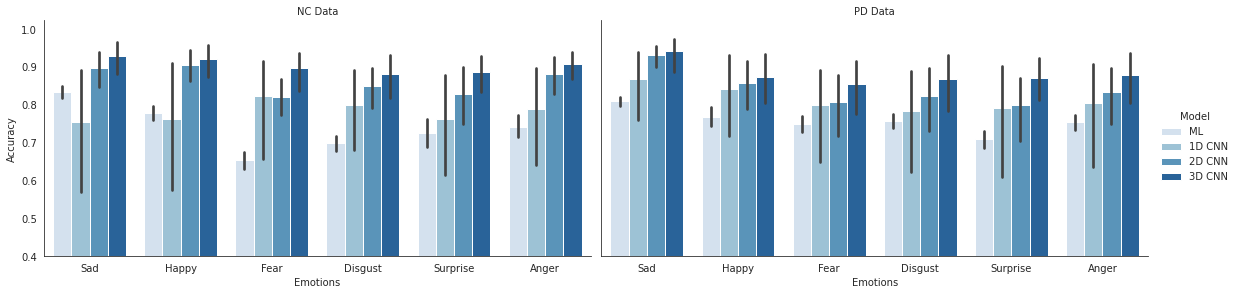

In [ ]:
2multi_df_new = pd.melt(multi_df, id_vars=['Model', 'Data'], value_vars=['Sad', 'Happy', 'Fear', 'Disgust',
                                                                'Surprise', 'Anger'],
        var_name='Emotions', value_name='Accuracy')
x = "Emotions"
y = "Accuracy"
hue = "Model"

g = sns.catplot(data=multi_df_new, x=x, y=y, hue = hue, palette = "Blues",
                 col="Data", kind="bar", height=4, aspect=2)
g.set(ylim=(0.4, None))
g.set_titles("{col_name} {col_var}")
g.set_axis_lables("Emotions", "Accuracy")
#ax.legend(loc='upper left', bbox_to_anchor=(0, 1))
ax.set_xlabel('Emotions',fontsize = 15, )
#ax.set_ylabel('Sensitivity',fontsize = 15 )
#ax.set_xticklabels(["ML", "1D CNN", "2D CNN", "3D CNN"], rotation=0, fontsize = 13);
'''
add_stat_annotation(ax, data=arousal_df_new, x=x, y=y, hue=hue,
                    box_pairs=[(("ML", "PD"), ("ML", "NC")),
                                 (("1D CNN", "PD"), ("1D CNN", "NC")),
                                 (("2D CNN", "PD"), ("2D CNN", "NC")),
                               (("3D CNN", "PD"), ("3D CNN", "NC"))
                                ],
                    test='t-test_ind', text_format='star', loc='inside', verbose=2)
                    '''

Text(0.5, 1.0, 'MultiClass Classification')

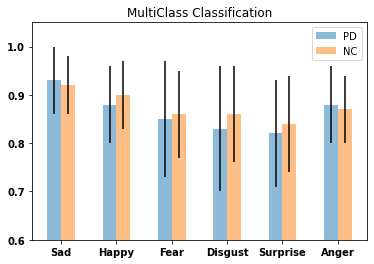

In [ ]:
#Plot comparing sensitivity of NC and PD.
labels = ['Sad', 'Happy', 'Fear', 'Disgust', 'Surprise', 'Anger']
x_pos = np.arange(len(labels))

multi_pd_m = [sad_3pd[0], happy_3pd[0], fear_3pd[0], disgust_3pd[0], surprise_3pd[0], anger_3pd[0]]
multi_pd_s = [sad_3pd[1], happy_3pd[1], fear_3pd[1], disgust_3pd[1], surprise_3pd[1], anger_3pd[1]]

multi_nc_m = [sad_3nc[0], happy_3nc[0], fear_3nc[0], disgust_3nc[0], surprise_3nc[0], anger_3nc[0]]
multi_nc_s = [sad_3nc[1], happy_3nc[1], fear_3nc[1], disgust_3nc[1], surprise_3nc[1], anger_3nc[1]]

#ax = fig.add_axes([0,0,1,1])
barWidth = 0.25
m1 = plt.bar(x_pos - barWidth/2, multi_pd_m, yerr=multi_pd_s, align='center', alpha=0.5,
             width = barWidth)
m2 = plt.bar(x_pos + barWidth/2, multi_nc_m, yerr=multi_nc_s, align='center', alpha=0.5,
            width = barWidth)
#plt.ylabel('Mean brands recalled',fontsize=14,weight='bold')
#plt.xlabel('Methods',fontsize=14,weight='bold')
plt.ylim(0,1.05)
plt.ylim(bottom = 0.6)
plt.xticks(ticks=[0,1,2,3,4,5], labels=labels, weight='bold')
plt.yticks(weight='bold')
plt.legend((m1[0], m2[0]), ('PD', 'NC'))
plt.title('MultiClass Classification')

#plt.savefig('U2_IFbrrec.png',bbox_inches='tight')
#files.download('U2_IFbrrec.png')

## PDNC

In [ ]:
def get_metric(dataPath, metric):
  matContent = sio.loadmat(dataPath)
  metric = matContent[metric]
  return metric

data = 'Full'
pdnc_Full_ml = get_metric('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/MLResults/Spectral/ML_PDNC_spectral_'+str(data)+'.mat', 'conf_mat_list')
pdnc_Full_1d = get_metric('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/1D_CNN_Results/Spectral/CNN_1D_results_PDNC_Spectral_'+str(data)+'.mat', 'conf_mat_list')
pdnc_Full_2d = get_metric('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/CNN_2D_our/CNN_2D_results_PDNC_'+str(data)+'.mat', 'conf_mat_list')

data = 'E1'
pdnc_E1_ml = get_metric('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/MLResults/Spectral/ML_PDNC_spectral_'+str(data)+'.mat', 'conf_mat_list')
pdnc_E1_1d = get_metric('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/1D_CNN_Results/Spectral/CNN_1D_results_PDNC_Spectral_'+str(data)+'.mat', 'conf_mat_list')
pdnc_E1_2d = get_metric('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/CNN_2D_our/CNN_2D_results_PDNC_'+str(data)+'.mat', 'conf_mat_list')

data = 'E2'
pdnc_E2_ml = get_metric('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/MLResults/Spectral/ML_PDNC_spectral_'+str(data)+'.mat', 'conf_mat_list')
pdnc_E2_1d = get_metric('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/1D_CNN_Results/IIR/CNN_1D_results_PDNC_IIR_'+str(data)+'.mat', 'conf_mat_list')
pdnc_E2_2d = get_metric('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/CNN_2D_our/CNN_2D_results_PDNC_'+str(data)+'.mat', 'conf_mat_list')

data = 'E3'
pdnc_E3_ml = get_metric('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/MLResults/Spectral/ML_PDNC_spectral_'+str(data)+'.mat', 'conf_mat_list')
pdnc_E3_1d = get_metric('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/1D_CNN_Results/Spectral/CNN_1D_results_PDNC_Spectral_'+str(data)+'.mat', 'conf_mat_list')
pdnc_E3_2d = get_metric('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/CNN_2D_our/CNN_2D_results_PDNC_'+str(data)+'.mat', 'conf_mat_list')

data = 'E4'
pdnc_E4_ml = get_metric('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/MLResults/Spectral/ML_PDNC_spectral_'+str(data)+'.mat', 'conf_mat_list')
pdnc_E4_1d = get_metric('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/1D_CNN_Results/Spectral/CNN_1D_results_PDNC_Spectral_'+str(data)+'.mat', 'conf_mat_list')
pdnc_E4_2d = get_metric('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/CNN_2D_our/CNN_2D_results_PDNC_'+str(data)+'.mat', 'conf_mat_list')

data = 'E5'
pdnc_E5_ml = get_metric('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/MLResults/Spectral/ML_PDNC_spectral_'+str(data)+'.mat', 'conf_mat_list')
pdnc_E5_1d = get_metric('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/1D_CNN_Results/IIR/CNN_1D_results_PDNC_IIR_'+str(data)+'.mat', 'conf_mat_list')
pdnc_E5_2d = get_metric('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/CNN_2D_our/CNN_2D_results_PDNC_'+str(data)+'.mat', 'conf_mat_list')

data = 'E6'
pdnc_E6_ml = get_metric('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/MLResults/Spectral/ML_PDNC_spectral_'+str(data)+'.mat', 'conf_mat_list')
pdnc_E6_1d = get_metric('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/1D_CNN_Results/Spectral/CNN_1D_results_PDNC_Spectral_'+str(data)+'.mat', 'conf_mat_list')
pdnc_E6_2d = get_metric('/content/drive/MyDrive/EEG_Analysis_PD_NC/Results/CNN_2D_our/CNN_2D_results_PDNC_'+str(data)+'.mat', 'conf_mat_list')


In [ ]:
data1 = {'Sensitivity': [i[1][1] for i in pdnc_Full_ml], 'Specificity': [i[0][0] for i in pdnc_Full_ml],
          'Data': len([i[1][1] for i in pdnc_Full_ml])*['Full'], 'Model': len([i[1][1] for i in pdnc_Full_ml])*['ML']}
df1 = pd.DataFrame(data1)
data2 = {'Sensitivity': [i[1][1] for i in pdnc_Full_1d], 'Specificity': [i[0][0] for i in pdnc_Full_1d],
          'Data': len([i[1][1] for i in pdnc_Full_1d])*['Full'], 'Model': len([i[1][1] for i in pdnc_Full_1d])*['1D CNN']}
df2 = pd.DataFrame(data2)
data3 = {'Sensitivity': [i[1][1] for i in pdnc_Full_2d], 'Specificity': [i[0][0] for i in pdnc_Full_2d],
          'Data': len([i[1][1] for i in pdnc_Full_2d])*['Full'], 'Model': len([i[1][1] for i in pdnc_Full_2d])*['2D CNN']}
df3 = pd.DataFrame(data3)

data4 = {'Sensitivity': [i[1][1] for i in pdnc_E1_ml], 'Specificity': [i[0][0] for i in pdnc_E1_ml],
          'Data': len([i[1][1] for i in pdnc_E1_ml])*['Sad'], 'Model': len([i[1][1] for i in pdnc_E1_ml])*['ML']}
df4 = pd.DataFrame(data4)
data5 = {'Sensitivity': [i[1][1] for i in pdnc_E1_1d], 'Specificity': [i[0][0] for i in pdnc_E1_1d],
          'Data': len([i[1][1] for i in pdnc_E1_1d])*['Sad'], 'Model': len([i[1][1] for i in pdnc_E1_1d])*['1D CNN']}
df5 = pd.DataFrame(data5)
data6 = {'Sensitivity': [i[1][1] for i in pdnc_E1_2d], 'Specificity': [i[0][0] for i in pdnc_E1_2d],
          'Data': len([i[1][1] for i in pdnc_E1_2d])*['Sad'], 'Model': len([i[1][1] for i in pdnc_E1_2d])*['2D CNN']}
df6 = pd.DataFrame(data6)

data7 = {'Sensitivity': [i[1][1] for i in pdnc_E2_ml], 'Specificity': [i[0][0] for i in pdnc_E2_ml],
          'Data': len([i[1][1] for i in pdnc_E2_ml])*['Happy'], 'Model': len([i[1][1] for i in pdnc_E2_ml])*['ML']}
df7 = pd.DataFrame(data7)
data8 = {'Sensitivity': [i[1][1] for i in pdnc_E2_1d], 'Specificity': [i[0][0] for i in pdnc_E2_1d],
          'Data': len([i[1][1] for i in pdnc_E2_1d])*['Happy'], 'Model': len([i[1][1] for i in pdnc_E2_1d])*['1D CNN']}
df8 = pd.DataFrame(data8)
data9 = {'Sensitivity': [i[1][1] for i in pdnc_E2_2d], 'Specificity': [i[0][0] for i in pdnc_E2_2d],
          'Data': len([i[1][1] for i in pdnc_E2_2d])*['Happy'], 'Model': len([i[1][1] for i in pdnc_E2_2d])*['2D CNN']}
df9 = pd.DataFrame(data9)

data10 = {'Sensitivity': [i[1][1] for i in pdnc_E3_ml], 'Specificity': [i[0][0] for i in pdnc_E3_ml],
          'Data': len([i[1][1] for i in pdnc_E3_ml])*['Fear'], 'Model': len([i[1][1] for i in pdnc_E3_ml])*['ML']}
df10 = pd.DataFrame(data10)
data11 = {'Sensitivity': [i[1][1] for i in pdnc_E3_1d], 'Specificity': [i[0][0] for i in pdnc_E3_1d],
          'Data': len([i[1][1] for i in pdnc_E3_1d])*['Fear'], 'Model': len([i[1][1] for i in pdnc_E3_1d])*['1D CNN']}
df11 = pd.DataFrame(data11)
data12 = {'Sensitivity': [i[1][1] for i in pdnc_E3_2d], 'Specificity': [i[0][0] for i in pdnc_E3_2d],
          'Data': len([i[1][1] for i in pdnc_E3_2d])*['Fear'], 'Model': len([i[1][1] for i in pdnc_E3_2d])*['2D CNN']}
df12 = pd.DataFrame(data12)

data13 = {'Sensitivity': [i[1][1] for i in pdnc_E4_ml], 'Specificity': [i[0][0] for i in pdnc_E4_ml],
          'Data': len([i[1][1] for i in pdnc_E4_ml])*['Disgust'], 'Model': len([i[1][1] for i in pdnc_E4_ml])*['ML']}
df13 = pd.DataFrame(data13)
data14 = {'Sensitivity': [i[1][1] for i in pdnc_E4_1d], 'Specificity': [i[0][0] for i in pdnc_E4_1d],
          'Data': len([i[1][1] for i in pdnc_E4_1d])*['Disgust'], 'Model': len([i[1][1] for i in pdnc_E4_1d])*['1D CNN']}
df14 = pd.DataFrame(data14)
data15 = {'Sensitivity': [i[1][1] for i in pdnc_E4_2d], 'Specificity': [i[0][0] for i in pdnc_E4_2d],
          'Data': len([i[1][1] for i in pdnc_E4_2d])*['Disgust'], 'Model': len([i[1][1] for i in pdnc_E4_2d])*['2D CNN']}
df15 = pd.DataFrame(data15)

data16 = {'Sensitivity': [i[1][1] for i in pdnc_E5_ml], 'Specificity': [i[0][0] for i in pdnc_E5_ml],
          'Data': len([i[1][1] for i in pdnc_E5_ml])*['Surprise'], 'Model': len([i[1][1] for i in pdnc_E5_ml])*['ML']}
df16 = pd.DataFrame(data16)
data17 = {'Sensitivity': [i[1][1] for i in pdnc_E5_1d], 'Specificity': [i[0][0] for i in pdnc_E5_1d],
          'Data': len([i[1][1] for i in pdnc_E5_1d])*['Surprise'], 'Model': len([i[1][1] for i in pdnc_E5_1d])*['1D CNN']}
df17 = pd.DataFrame(data17)
data18 = {'Sensitivity': [i[1][1] for i in pdnc_E5_2d], 'Specificity': [i[0][0] for i in pdnc_E5_2d],
          'Data': len([i[1][1] for i in pdnc_E5_2d])*['Surprise'], 'Model': len([i[1][1] for i in pdnc_E5_2d])*['2D CNN']}
df18 = pd.DataFrame(data18)

data19 = {'Sensitivity': [i[1][1] for i in pdnc_E6_ml], 'Specificity': [i[0][0] for i in pdnc_E6_ml],
          'Data': len([i[1][1] for i in pdnc_E6_ml])*['Anger'], 'Model': len([i[1][1] for i in pdnc_E6_ml])*['ML']}
df19 = pd.DataFrame(data19)
data20 = {'Sensitivity': [i[1][1] for i in pdnc_E6_1d], 'Specificity': [i[0][0] for i in pdnc_E6_1d],
          'Data': len([i[1][1] for i in pdnc_E6_1d])*['Anger'], 'Model': len([i[1][1] for i in pdnc_E6_1d])*['1D CNN']}
df20 = pd.DataFrame(data20)
data21 = {'Sensitivity': [i[1][1] for i in pdnc_E6_2d], 'Specificity': [i[0][0] for i in pdnc_E6_2d],
          'Data': len([i[1][1] for i in pdnc_E6_2d])*['Anger'], 'Model': len([i[1][1] for i in pdnc_E6_2d])*['2D CNN']}
df21 = pd.DataFrame(data21)


pdnc_df = pd.concat([df1, df2, df3, df4, df5, df6, df7, df8, df9, df10,
                        df11, df12, df13, df14, df15, df16, df17, df18, df19,
                        df20, df21], axis=0).reset_index()
print(pdnc_df)

     index  Sensitivity  Specificity   Data   Model
0        0     0.971545     0.967655   Full      ML
1        1     0.975610     0.963612   Full      ML
2        2     0.976996     0.971660   Full      ML
3        3     0.967524     0.970310   Full      ML
4        4     0.964817     0.962213   Full      ML
..     ...          ...          ...    ...     ...
205      5     0.984252     0.992063  Anger  2D CNN
206      6     0.976378     0.992063  Anger  2D CNN
207      7     1.000000     1.000000  Anger  2D CNN
208      8     0.984127     0.992063  Anger  2D CNN
209      9     1.000000     1.000000  Anger  2D CNN

[210 rows x 5 columns]


In [ ]:
pdnc_df_new = pd.melt(pdnc_df[pdnc_df['Model']=='ML'], id_vars=['Data'], value_vars=['Sensitivity', 'Specificity'],
        var_name='Test', value_name='Value')
temp = pdnc_df_new[pdnc_df_new['Data']=='Full']
print("Sensitivity for full data")
print(temp[temp['Test']=='Sensitivity'].mean())
print(temp[temp['Test']=='Sensitivity'].std())

print("Specificity for full data")
print(temp[temp['Test']=='Specificity'].mean())
print(temp[temp['Test']=='Specificity'].std())

Sensitivity for full data
Value    0.971847
dtype: float64
Value    0.007541
dtype: float64
Specificity for full data
Value    0.963032
dtype: float64
Value    0.006308
dtype: float64


In [ ]:
#print mean and std sensitivity or specificity for each data
pdnc_df_new = pd.melt(pdnc_df[pdnc_df['Model']=='ML'], id_vars=['Data'], value_vars=['Sensitivity', 'Specificity'],
        var_name='Test', value_name='Value')
print(pdnc_df_new)

df_dummy_ml = pdnc_df_new.groupby(['Data','Test']).mean().round(2)
print(df_dummy_ml)
df_dummy_ml['SE'] = pdnc_df_new.groupby(['Data','Test']).sem().round(3)
print(df_dummy_ml)
pdnc_df_new.groupby(['Data','Test']).mean().round(3)

      Data         Test     Value
0     Full  Sensitivity  0.971545
1     Full  Sensitivity  0.975610
2     Full  Sensitivity  0.976996
3     Full  Sensitivity  0.967524
4     Full  Sensitivity  0.964817
..     ...          ...       ...
135  Anger  Specificity  0.952381
136  Anger  Specificity  0.968254
137  Anger  Specificity  0.976190
138  Anger  Specificity  0.944444
139  Anger  Specificity  0.976000

[140 rows x 3 columns]
                      Value
Data     Test              
Anger    Sensitivity   0.97
         Specificity   0.96
Disgust  Sensitivity   0.96
         Specificity   0.96
Fear     Sensitivity   0.98
         Specificity   0.95
Full     Sensitivity   0.97
         Specificity   0.96
Happy    Sensitivity   0.95
         Specificity   0.98
Sad      Sensitivity   0.98
         Specificity   0.97
Surprise Sensitivity   0.97
         Specificity   0.94
                      Value     SE
Data     Test                     
Anger    Sensitivity   0.97  0.006
         Specif

Value
Data     Test              
Anger    Sensitivity  0.966
         Specificity  0.959
Disgust  Sensitivity  0.964
         Specificity  0.960
Fear     Sensitivity  0.977
         Specificity  0.952
Full     Sensitivity  0.972
         Specificity  0.963
Happy    Sensitivity  0.952
         Specificity  0.982
Sad      Sensitivity  0.977
         Specificity  0.971
Surprise Sensitivity  0.968
         Specificity  0.937

      Data         Test     Value
0     Full  Sensitivity  0.971545
1     Full  Sensitivity  0.975610
2     Full  Sensitivity  0.976996
3     Full  Sensitivity  0.967524
4     Full  Sensitivity  0.964817
..     ...          ...       ...
135  Anger  Specificity  0.952381
136  Anger  Specificity  0.968254
137  Anger  Specificity  0.976190
138  Anger  Specificity  0.944444
139  Anger  Specificity  0.976000

[140 rows x 3 columns]
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Sad_Sensitivity v.s. Sad_Specificity: t-test independent samples with Bonferroni correction, P_val=1.000e+00 stat=8.543e-01
Full_Sensitivity v.s. Full_Specificity: t-test independent samples with Bonferroni correction, P_val=7.683e-02 stat=2.835e+00
Happy_Sensitivity v.s. Happy_Specificity: t-test independent samples with Bonferroni correction, P_val=4.699e-03 stat=-4.101e+00
Fear_Sensitivity v.s. Fea

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


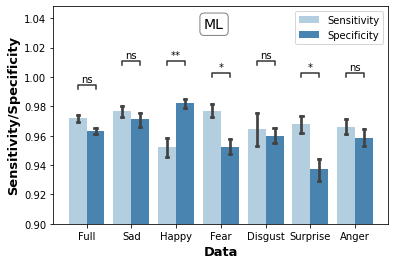

In [ ]:
pdnc_df_new = pd.melt(pdnc_df[pdnc_df['Model']=='ML'], id_vars=['Data'], value_vars=['Sensitivity', 'Specificity'],
        var_name='Test', value_name='Value')
print(pdnc_df_new)


x = "Data"
y = "Value"
hue = "Test"

ax = sns.barplot(data=pdnc_df_new, x=x, y=y, hue = hue, palette = "Blues", capsize=.05, ci=68)
ax.set_ylim(bottom=0.9)
ax.legend(loc='upper right', bbox_to_anchor=(1,1))
ax.set_xlabel('Data',fontsize = 13, weight='bold')
ax.set_ylabel('Sensitivity/Specificity',fontsize = 13, weight='bold')
#ax.set_xticklabels(["Full", "Sad", "Happy", "Fear", "Disgust", "Surprise", "Anger"], rotation=0, fontsize = 10, weight='bold');
#ax.set_yticklabels(["0.5", "0.6", "0.7", "0.8", "0.9", "1.0"], size= 10, weight='bold')
#ax.set_yticklabels(ax.get_yticklabels(), size= 10, weight='bold')
add_stat_annotation(ax, data=pdnc_df_new, x=x, y=y, hue=hue,
                    box_pairs=[(("Full", "Sensitivity"), ("Full", "Specificity")),
                                (("Sad", "Sensitivity"), ("Sad", "Specificity")),
                                 (("Happy", "Sensitivity"), ("Happy", "Specificity")),
                               (("Fear", "Sensitivity"), ("Fear", "Specificity")),
                               (("Disgust", "Sensitivity"), ("Disgust", "Specificity")),
                               (("Surprise", "Sensitivity"), ("Surprise", "Specificity")),
                               (("Anger", "Sensitivity"), ("Anger", "Specificity"))
                                ],
                    test='t-test_ind', text_format='star', loc='inside', verbose=2)


props = dict(boxstyle='round', facecolor='none', edgecolor='black', alpha=0.5)

# place a text box in upper left in axes coords
ax.text(0.45, 0.95, "ML", transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

plt.savefig('sens_and_speci_pdnc_ml.eps', format='eps', bbox_inches='tight')
#FILE.download('sensitivity_valence.eps')

In [ ]:
#print mean and std sensitivity or specificity for each data
pdnc_df_new = pd.melt(pdnc_df[pdnc_df['Model']=='1D CNN'], id_vars=['Data'], value_vars=['Sensitivity', 'Specificity'],
        var_name='Test', value_name='Value')
print(pdnc_df_new)

df_dummy = pdnc_df_new.groupby(['Data','Test']).mean().round(2)
print(df_dummy)
df_dummy['SE'] = pdnc_df_new.groupby(['Data','Test']).sem().round(3)
print(df_dummy)

#pdnc_df_new.groupby(['Data','Test']).mean().round(2)
pdnc_df_new.groupby(['Data','Test']).sem().round(3)

      Data         Test     Value
0     Full  Sensitivity  0.966125
1     Full  Sensitivity  0.933604
2     Full  Sensitivity  0.968877
3     Full  Sensitivity  0.986468
4     Full  Sensitivity  0.994587
..     ...          ...       ...
135  Anger  Specificity  0.992063
136  Anger  Specificity  0.825397
137  Anger  Specificity  1.000000
138  Anger  Specificity  0.976000
139  Anger  Specificity  1.000000

[140 rows x 3 columns]
                      Value
Data     Test              
Anger    Sensitivity   0.90
         Specificity   0.93
Disgust  Sensitivity   0.98
         Specificity   0.97
Fear     Sensitivity   0.96
         Specificity   0.96
Full     Sensitivity   0.98
         Specificity   0.99
Happy    Sensitivity   0.92
         Specificity   0.98
Sad      Sensitivity   0.95
         Specificity   0.98
Surprise Sensitivity   0.95
         Specificity   0.93
                      Value     SE
Data     Test                     
Anger    Sensitivity   0.90  0.047
         Specif

Value
Data     Test              
Anger    Sensitivity  0.047
         Specificity  0.037
Disgust  Sensitivity  0.008
         Specificity  0.014
Fear     Sensitivity  0.016
         Specificity  0.008
Full     Sensitivity  0.007
         Specificity  0.001
Happy    Sensitivity  0.059
         Specificity  0.012
Sad      Sensitivity  0.016
         Specificity  0.008
Surprise Sensitivity  0.029
         Specificity  0.060

In [ ]:
pdnc_df_new = pd.melt(pdnc_df[pdnc_df['Model']=='1D CNN'], id_vars=['Data'], value_vars=['Sensitivity', 'Specificity'],
        var_name='Test', value_name='Value')
temp = pdnc_df_new[pdnc_df_new['Data']=='Full']
print("Sensitivity for full data")
print(temp[temp['Test']=='Sensitivity'].mean())
print(temp[temp['Test']=='Sensitivity'].std())

print("Specificity for full data")
print(temp[temp['Test']=='Specificity'].mean())
print(temp[temp['Test']=='Specificity'].std())

Sensitivity for full data
Value    0.979283
dtype: float64
Value    0.021028
dtype: float64
Specificity for full data
Value    0.993661
dtype: float64
Value    0.004493
dtype: float64


      Data         Test     Value
0     Full  Sensitivity  0.966125
1     Full  Sensitivity  0.933604
2     Full  Sensitivity  0.968877
3     Full  Sensitivity  0.986468
4     Full  Sensitivity  0.994587
..     ...          ...       ...
135  Anger  Specificity  0.992063
136  Anger  Specificity  0.825397
137  Anger  Specificity  1.000000
138  Anger  Specificity  0.976000
139  Anger  Specificity  1.000000

[140 rows x 3 columns]
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Sad_Sensitivity v.s. Sad_Specificity: t-test independent samples with Bonferroni correction, P_val=1.000e+00 stat=-1.357e+00
Full_Sensitivity v.s. Full_Specificity: t-test independent samples with Bonferroni correction, P_val=3.408e-01 stat=-2.115e+00
Happy_Sensitivity v.s. Happy_Specificity: t-test independent samples with Bonferroni correction, P_val=1.000e+00 stat=-9.185e-01
Fear_Sensitivity v.s. F

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


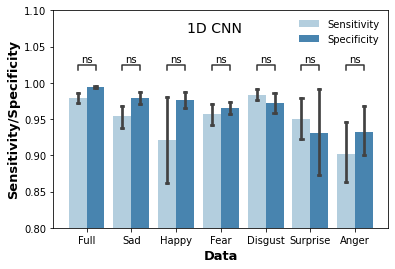

In [ ]:
pdnc_df_new = pd.melt(pdnc_df[pdnc_df['Model']=='1D CNN'], id_vars=['Data'], value_vars=['Sensitivity', 'Specificity'],
        var_name='Test', value_name='Value')
print(pdnc_df_new)

x = "Data"
y = "Value"
hue = "Test"

ax = sns.barplot(data=pdnc_df_new, x=x, y=y, hue = hue, palette = "Blues", capsize=.05, ci=68)
ax.set_ylim(bottom=0.80, top = 1.10)
ax.legend(loc='upper right', bbox_to_anchor=(1,1))
ax.set_xlabel('Data',fontsize = 13, weight='bold')
ax.set_ylabel('Sensitivity/Specificity',fontsize = 13, weight='bold')
add_stat_annotation(ax, data=pdnc_df_new, x=x, y=y, hue=hue,
                    box_pairs=[(("Full", "Sensitivity"), ("Full", "Specificity")),
                                (("Sad", "Sensitivity"), ("Sad", "Specificity")),
                                 (("Happy", "Sensitivity"), ("Happy", "Specificity")),
                               (("Fear", "Sensitivity"), ("Fear", "Specificity")),
                               (("Disgust", "Sensitivity"), ("Disgust", "Specificity")),
                               (("Surprise", "Sensitivity"), ("Surprise", "Specificity")),
                               (("Anger", "Sensitivity"), ("Anger", "Specificity"))
                                ],
                    test='t-test_ind', text_format='star', loc='inside', verbose=2)


props = dict(boxstyle='round', facecolor='none', edgecolor='black', alpha=0.5)

# place a text box in upper left in axes coords
ax.text(0.40, 0.95, "1D CNN", transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

plt.savefig('sens_and_speci_pdnc_1d.eps', format='eps', bbox_inches='tight')
#FILE.download('sensitivity_valence.eps')

In [ ]:
#print mean and std sensitivity or specificity for each data
pdnc_df_new = pd.melt(pdnc_df[pdnc_df['Model']=='2D CNN'], id_vars=['Data'], value_vars=['Sensitivity', 'Specificity'],
        var_name='Test', value_name='Value')
print(pdnc_df_new)

df_dummy = pdnc_df_new.groupby(['Data','Test']).mean().round(2)
print(df_dummy)
df_dummy['SE'] = pdnc_df_new.groupby(['Data','Test']).sem().round(3)
print(df_dummy)

#pdnc_df_new.groupby(['Data','Test']).mean().round(2)
pdnc_df_new.groupby(['Data','Test']).sem().round(3)

      Data         Test     Value
0     Full  Sensitivity  0.970230
1     Full  Sensitivity  0.985115
2     Full  Sensitivity  0.994587
3     Full  Sensitivity  0.994587
4     Full  Sensitivity  0.990528
..     ...          ...       ...
135  Anger  Specificity  0.992063
136  Anger  Specificity  0.992063
137  Anger  Specificity  1.000000
138  Anger  Specificity  0.992063
139  Anger  Specificity  1.000000

[140 rows x 3 columns]
                      Value
Data     Test              
Anger    Sensitivity   0.99
         Specificity   0.98
Disgust  Sensitivity   0.98
         Specificity   0.98
Fear     Sensitivity   0.99
         Specificity   0.98
Full     Sensitivity   0.99
         Specificity   0.99
Happy    Sensitivity   0.99
         Specificity   0.97
Sad      Sensitivity   0.99
         Specificity   0.99
Surprise Sensitivity   0.97
         Specificity   0.98
                      Value     SE
Data     Test                     
Anger    Sensitivity   0.99  0.003
         Specif

Value
Data     Test              
Anger    Sensitivity  0.003
         Specificity  0.012
Disgust  Sensitivity  0.010
         Specificity  0.006
Fear     Sensitivity  0.004
         Specificity  0.006
Full     Sensitivity  0.003
         Specificity  0.004
Happy    Sensitivity  0.003
         Specificity  0.012
Sad      Sensitivity  0.006
         Specificity  0.004
Surprise Sensitivity  0.016
         Specificity  0.004

In [ ]:
pdnc_df_new = pd.melt(pdnc_df[pdnc_df['Model']=='2D CNN'], id_vars=['Data'], value_vars=['Sensitivity', 'Specificity'],
        var_name='Test', value_name='Value')
temp = pdnc_df_new[pdnc_df_new['Data']=='Full']
print("Sensitivity for full data")
print(temp[temp['Test']=='Sensitivity'].mean())
print(temp[temp['Test']=='Sensitivity'].std())

print("Specificity for full data")
print(temp[temp['Test']=='Specificity'].mean())
print(temp[temp['Test']=='Specificity'].std())

Sensitivity for full data
Value    0.990526
dtype: float64
Value    0.007916
dtype: float64
Specificity for full data
Value    0.987719
dtype: float64
Value    0.012873
dtype: float64


      Data         Test     Value
0     Full  Sensitivity  0.970230
1     Full  Sensitivity  0.985115
2     Full  Sensitivity  0.994587
3     Full  Sensitivity  0.994587
4     Full  Sensitivity  0.990528
..     ...          ...       ...
135  Anger  Specificity  0.992063
136  Anger  Specificity  0.992063
137  Anger  Specificity  1.000000
138  Anger  Specificity  0.992063
139  Anger  Specificity  1.000000

[140 rows x 3 columns]
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Sad_Sensitivity v.s. Sad_Specificity: t-test independent samples with Bonferroni correction, P_val=1.000e+00 stat=-1.382e-01
Full_Sensitivity v.s. Full_Specificity: t-test independent samples with Bonferroni correction, P_val=1.000e+00 stat=5.873e-01
Happy_Sensitivity v.s. Happy_Specificity: t-test independent samples with Bonferroni correction, P_val=1.000e+00 stat=1.391e+00
Fear_Sensitivity v.s. Fea

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


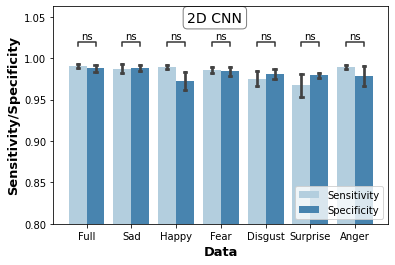

In [ ]:
pdnc_df_new = pd.melt(pdnc_df[pdnc_df['Model']=='2D CNN'], id_vars=['Data'], value_vars=['Sensitivity', 'Specificity'],
        var_name='Test', value_name='Value')
print(pdnc_df_new)

x = "Data"
y = "Value"
hue = "Test"

ax = sns.barplot(data=pdnc_df_new, x=x, y=y, hue = hue, palette = "Blues", capsize=.05, ci=68)
ax.set_ylim(bottom=0.80)
ax.legend(loc='lower right', bbox_to_anchor=(1,0))
ax.set_xlabel('Data',fontsize = 13, weight='bold')
ax.set_ylabel('Sensitivity/Specificity',fontsize = 13, weight='bold')
add_stat_annotation(ax, data=pdnc_df_new, x=x, y=y, hue=hue,
                    box_pairs=[(("Full", "Sensitivity"), ("Full", "Specificity")),
                                (("Sad", "Sensitivity"), ("Sad", "Specificity")),
                                 (("Happy", "Sensitivity"), ("Happy", "Specificity")),
                               (("Fear", "Sensitivity"), ("Fear", "Specificity")),
                               (("Disgust", "Sensitivity"), ("Disgust", "Specificity")),
                               (("Surprise", "Sensitivity"), ("Surprise", "Specificity")),
                               (("Anger", "Sensitivity"), ("Anger", "Specificity"))
                                ],
                    test='t-test_ind', text_format='star', loc='inside', verbose=2)


props = dict(boxstyle='round', facecolor='none', edgecolor='black', alpha=0.5)

# place a text box in upper left in axes coords
ax.text(0.4, 0.98, "2D CNN", transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

plt.savefig('sens_and_speci_pdnc_2d.eps', format='eps', bbox_inches='tight')
#FILE.download('sensitivity_valence.eps')